  # Metrics for hierarchical classification (model 2)
  
  
  This model uses four layers. In the first layer, every source is classified hierarchically as Stochastic, Transient or Periodic. Then, every source pass trough the next layers (Stochastic, Transient and Periodic). The final classification is dertermined by multiplying the probabilities of the first layer, with their correspondant probabilites of the Stochastic, Transient and Periodic layers. For instance, the probability of being RRL corresponds to the product of the probability of being periodic (according to the first layer) and the probability of being RRL (according to the periodic layer): 
 
 $$Prob_{final}(RRL) = Prob_{first \: layer}(Periodic)* Prob_{periodic \: layer}(RRL)$$
 
 And the probability of being a Blazar is computed as:
 
  $$Prob_{final}(Blazar) = Prob_{first \: layer}(Stochastic)* Prob_{stochastic \: layer}(Blazar)$$


 
 The final classification is definded by the maximum $Prob_{final}$
 


In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedShuffleSplit

  ### Definition of names for plots and files

In [2]:
morethan5 = False

extragalactic = False
galactic = False

date = '20191119'

#names of files with detections, features and labels for the training set (v3)
labels_file = '../alerce_trainingset/training_set_v5.1/dfcrossmatches_prioritized_v5.1.csv'
#detections_file = '../alerce_trainingset/training_set_v3/detections.pkl'
#features_file = '../alerce_trainingset/training_set_v3/features.pkl'
features_file = '../ZTF_data/features_20200109_with_WISE.csv'
#features_file = '../ZTF_data/features_20191017_filtered.pkl'
#non_detections_file = '../alerce_trainingset/training_set_v3/training_non_det_v3.h5'

features_paps = '../ZTF_data/paps_features_all_with_mean.pkl'
features_wise = '../ZTF_data/WISE_SDSS_data_20191119.csv'
class_output = '../ZTF_classifications/classification_unlabelled_set_with_TSvs5_20191119.csv'

#where the RF models are saved
if morethan5:
    model_first_layer = 'stat_prob_hierRF_model_2/rf_model_2_hierarchical_layer_morethan5gr_'+date
    model_periodic_layer = 'stat_prob_hierRF_model_2/rf_model_2_periodic_layer_morethan5gr_'+date
    model_transient_layer = 'stat_prob_hierRF_model_2/rf_model_2_transient_layer_morethan5gr_'+date
    model_stochastic_layer = 'stat_prob_hierRF_model_2/rf_model_2_stochastic_layer_morethan5gr_'+date

else: 
    model_first_layer = 'stat_prob_hierRF_model_2/rf_model_2_hierarchical_layer_'+date
    model_periodic_layer = 'stat_prob_hierRF_model_2/rf_model_2_periodic_layer_'+date
    model_transient_layer = 'stat_prob_hierRF_model_2/rf_model_2_transient_layer_'+date
    model_stochastic_layer = 'stat_prob_hierRF_model_2/rf_model_2_stochastic_layer_'+date

#confusion matrixes
if morethan5:
    conf_matrix_name_first_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_hierarchical_layer_morethan5gr_'+date
    conf_matrix_name_second_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_multiclass_morethan5gr_'+date

else:
    conf_matrix_name_first_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_hierarchical_layer_'+date
    conf_matrix_name_second_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_multiclass_'+date


#feature importances
if morethan5:
    feature_importance_name_first_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_hierarchical_layer_morethan5gr_'+date
    feature_importance_name_periodic_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_periodic_layer_morethan5gr_'+date
    feature_importance_name_transient_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_transient_layer_morethan5gr_'+date
    feature_importance_name_stochastic_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_stochastic_layer_morethan5gr_'+date
    
else: 
    feature_importance_name_first_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_hierarchical_layer_'+date
    feature_importance_name_periodic_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_periodic_layer_'+date
    feature_importance_name_transient_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_transient_layer_'+date
    feature_importance_name_stochastic_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_stochastic_layer_'+date

### reading the training set files 

In [3]:
#df_nd = pd.read_hdf(non_detections_file)
df_feat = pd.read_csv(features_file,index_col='oid')
df_labels = pd.read_csv(labels_file,index_col='oid')


#df_wise = pd.read_csv(features_wise,index_col='oid')

#'''
df_feat['W2-W3']=df_feat['W2']-df_feat['W3']
df_feat.loc[(df_feat['W3']==np.nan) |(df_feat['W2']==np.nan) |(df_feat['W2']==-999)|(df_feat['W3']==-999), 'W2-W3']=-999

df_feat['r-W3']=df_feat['Mean_2']-df_feat['W3']
df_feat.loc[(df_feat['Mean_2']==np.nan) |(df_feat['W3']==np.nan) | (df_feat['Mean_2']==-999)|(df_feat['W3']==-999) , 'r-W3']=-999
df_feat.loc[(df_feat['r-W3']>500) | (df_feat['r-W3']<-500) ,'r-W3']=-999 

df_feat['r-W2']=df_feat['Mean_2']-df_feat['W2']
df_feat.loc[(df_feat['Mean_2']==np.nan) |(df_feat['W2']==np.nan) | (df_feat['Mean_2']==-999)|(df_feat['W2']==-999), 'r-W2']=-999
df_feat.loc[(df_feat['r-W2']>500) | (df_feat['r-W3']<-500),'r-W2']=-999 

df_feat['g-W3']=df_feat['Mean_1']-df_feat['W3']
df_feat.loc[(df_feat['Mean_1']==np.nan) |(df_feat['W3']==np.nan) | (df_feat['Mean_1']==-999)|(df_feat['W3']==-999) , 'g-W3']=-999
df_feat.loc[(df_feat['g-W3']>500) | (df_feat['g-W3']<-500) ,'g-W3']=-999 

df_feat['g-W2']=df_feat['Mean_1']-df_feat['W2']
df_feat.loc[(df_feat['Mean_1']==np.nan) |(df_feat['W2']==np.nan) | (df_feat['Mean_1']==-999)|(df_feat['W2']==-999), 'g-W2']=-999
df_feat.loc[(df_feat['g-W2']>500) | (df_feat['g-W3']<-500),'g-W2']=-999
#'''

#df_detections = pd.read_pickle(detections_file)
'''
df_paps = pd.read_pickle(features_paps)
df_paps = df_paps.set_index('oid')
df_paps.paps_ratio_1=df_paps.paps_ratio_1.astype(float)
df_paps.paps_ratio_2=df_paps.paps_ratio_2.astype(float)
df_paps.paps_high_2=df_paps.paps_high_2.astype(float)
df_paps.paps_high_1=df_paps.paps_high_1.astype(float)
df_paps.paps_low_2=df_paps.paps_low_2.astype(float)
df_paps.paps_low_1=df_paps.paps_low_1.astype(float)

print(df_paps.dtypes)

df_paps = df_paps.replace([np.inf, -np.inf], np.nan)
df_paps.replace([-99], -999,inplace=True)
df_paps.fillna(-999,inplace=True)
print(np.max(df_paps['paps_ratio_2']))

'''

#deleting columns in df_nd with name ending in "_3"
#for col in list(df_nd):
#    if col[-2:] == "_3":
#        df_nd.drop(col, inplace=True, axis=1)

#getting gscore from the detections file
#df_det = df_detections.groupby(['oid'])
#df_sgscore = df_det['sgscore1'].median()
#df_sgscore = df_sgscore.to_frame()

#creating color features
#df_nd["g_r_max"] = df_nd.min_mag_fid_1 - df_nd.min_mag_fid_2
#df_feat["g_r_mean"] = df_feat.Mean_1 - df_feat.Mean_2

#discarging infinite values
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

df_feat_for_stats = df_feat.copy()
print(df_labels['class_source'].values.size)
print(df_feat.head())

170976
              Amplitude_1  Amplitude_2  AndersonDarling_1  AndersonDarling_2  \
oid                                                                            
ZTF17aaaaaxg     0.200738     0.215184                1.0           1.000000   
ZTF17aaaadvq          NaN     0.316305                NaN           1.000000   
ZTF17aaaadyl          NaN     0.326172                NaN           1.000000   
ZTF17aaaafce     0.207151     0.198148                1.0           0.999998   
ZTF17aaaajfv     0.656590     0.488236                1.0           1.000000   

              Autocor_length_1  Autocor_length_2  Beyond1Std_1  Beyond1Std_2  \
oid                                                                            
ZTF17aaaaaxg               1.0               1.0      0.452381      0.450000   
ZTF17aaaadvq               NaN               1.0           NaN      0.055556   
ZTF17aaaadyl               NaN               1.0           NaN      0.151515   
ZTF17aaaafce               1.0  

In [4]:
#creating new labels to combine SNII and SNIIb classes, and to add RS-CVn as a new class
df_labels['class_original'] = df_labels['classALeRCE']
df_labels.loc[(df_labels['class_original'] == 'RSCVn'), 'class_original'] = 'Periodic-Other'
df_labels.loc[(df_labels['class_original'] == 'SNIIn'), 'class_original'] = 'SNII'
df_labels.loc[(df_labels['class_original'] == 'EA'), 'class_original'] = 'EB'
df_labels.loc[(df_labels['class_original'] == 'EB/EW'), 'class_original'] = 'EB'
#df_labels.loc[(df_labels['class_original'] == 'AGN-I'), 'class_original'] = 'QSO-I'
#df_labels.loc[(df_labels['class_source'] == 'A') | (df_labels['class_source'] == 'AGN_galaxy_dominated'), 'class_original'] = 'AGN-I'





#defining the classes included in the RF model
#label_order = ['QSO','AGN', 'Blazar', 'CV/Nova', 'YSO', 'SNIa', 'SNIbc', 'SNII',
#               'SLSN', 'EA', 'EB/EW', 'DSCT', 'RRL', 'Ceph', 'LPV','RSCVn','Periodic-Other']

label_order = ['QSO','AGN', 'Blazar', 'CV/Nova', 'YSO','LPV', 'SNIa', 'SNIbc', 'SNII',
               'SLSN', 'EB', 'DSCT', 'RRL', 'Ceph','Periodic-Other']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

#defining hierarchical classes:

labels['class_hierachical'] = labels['class_original']

#labels.loc[(labels['class_hierachical'] == 'RSCVn') | (labels['class_hierachical'] == 'Periodic-Other') | (labels['class_hierachical'] == 'EA') | (labels['class_hierachical'] == 'EB/EW')  | (labels['class_hierachical'] == 'DSCT') | (labels['class_hierachical'] == 'RRL') | (labels['class_hierachical'] == 'Ceph') , 'class_hierachical'] = 'Periodic'
labels.loc[(labels['class_hierachical'] == 'RSCVn') | (labels['class_hierachical'] == 'Periodic-Other') | (labels['class_hierachical'] == 'EB')  | (labels['class_hierachical'] == 'DSCT') | (labels['class_hierachical'] == 'RRL') | (labels['class_hierachical'] == 'Ceph') , 'class_hierachical'] = 'Periodic'

labels.loc[(labels['class_hierachical'] == 'SNIa') | (labels['class_hierachical'] == 'SNIbc') | (labels['class_hierachical'] == 'SNII') | (labels['class_hierachical'] == 'SLSN'), 'class_hierachical'] = 'Transient'

labels.loc[(labels['class_hierachical'] == 'YSO') | (labels['class_hierachical'] == 'LPV') | (labels['class_hierachical'] == 'CV/Nova')  |   (labels['class_hierachical'] == 'AGN') |  (labels['class_hierachical'] == 'QSO') | (labels['class_hierachical'] == 'Blazar')  , 'class_hierachical'] = 'Stochastic'

cm_classes_hierachical = ['Stochastic','Transient','Periodic']
cm_classes_original = label_order

print(labels['class_hierachical'].values.shape)
labels.head()

(170948,)


,class_original,class_hierachical
oid,,
ZTF19aavdfaf,CV/Nova,Stochastic
ZTF19aaniokz,CV/Nova,Stochastic
ZTF18accatjz,CV/Nova,Stochastic
ZTF19aarfrrf,CV/Nova,Stochastic
ZTF19aarfrre,CV/Nova,Stochastic


In [5]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
'n_det_1',
'n_det_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'first_mag_1',
'first_mag_2',
'aps_non_zero_1',
'aps_non_zero_2',
'mean_mag_1',
'mean_mag_2',
'min_mag_1',
'min_mag_2',
'W1','W2','W3','W4','u','g','r','i','z','u_g','g_r','r_i','i_z',  
'iqr_1',
'iqr_2',   
'delta_mjd_fid_1',
'delta_mjd_fid_2',  
]
'''
'max_mjd_fid_1',
'max_mjd_fid_2',
'min_mjd_fid_1',
'min_mjd_fid_2',
'max_mag_fid_1',
'max_mag_fid_2',
'min_mag_fid_1',
'min_mag_fid_2',
'first_mag_fid_1',
'first_mag_fid_2',
'first_mjd_fid_1',
'first_mjd_fid_2']
'''

#print(df_paps.columns)
#paps_drop = ['paps_non_zero_1','paps_PN_flag_1','paps_non_zero_2','paps_PN_flag_2']
#paps_drop = ['paps_non_zero_1','paps_non_zero_2']

wise_drop = ['W1','W2','W3','W4','u','g','r','i','z','u_g','g_r','r_i','i_z']

#rm_nd_cols = rm_nd_cols + wise_drop


#combining all the DF
#df = labels.join(df_sgscore).join(df_feat).join(df_nd.drop(rm_nd_cols, axis=1))
#df = labels.join(df_sgscore).join(df_feat.drop(rm_nd_cols, axis=1))

df = labels.join(df_feat.drop(rm_nd_cols, axis=1),how='inner')#.join(df_wise.drop(wise_drop, axis=1),how='left')
print(df['g-r_max'].values.size)
#df = df.join(df_wise.drop(wise_drop, axis=1),how='left')
#print(df['g-r_max'].values.size)
df = df.replace([np.inf, -np.inf], np.nan)
print(df['g-r_max'].values.size)
df_train = df.copy()
df_train = df_train.fillna(-999)
labels = df[['class_original','class_hierachical']]
df.drop(['Mean_1','Mean_2','class_original','class_hierachical'], axis=1, inplace=True)
df = df.fillna(-999)

#print(np.max(df['paps_ratio_2'].values))
#print(len(labels['class_original'].values))
#labels = labels.loc[df.index.values]
print(len(labels['class_original'].values))



print(df['g-r_max'].values.size)
df.head()

116753
116753
116753
116753


,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,positive_fraction_1,positive_fraction_2,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18abcoxgp,1.777660,1.612033,1.0,1.0,6.0,8.0,0.607143,0.626866,0.018519,0.000000,...,0.125000,0.194030,0.886667,0.983125,-999.000,-999.000,-999.000000,-999.000000,-999.000000,-999.000000
ZTF18aaavxnm,1.545494,1.355183,1.0,1.0,1.0,1.0,0.100000,0.163636,0.000000,0.018868,...,0.700000,0.763636,0.808571,1.000000,0.439,1.925,4.700925,2.775925,4.654902,2.729902
ZTF18abmefme,1.741148,1.508885,1.0,1.0,1.0,1.0,0.529412,0.521739,0.000000,0.000000,...,0.431373,0.413043,0.912857,0.996042,0.168,2.829,4.799764,1.970764,4.865939,2.036939
ZTF17aabumpu,1.689769,1.102787,1.0,1.0,1.0,1.0,0.176471,0.315789,0.000000,0.000000,...,0.735294,0.631579,0.846667,0.790198,0.026,0.576,2.432245,1.856245,2.667624,2.091624
ZTF18aazmwvg,2.734478,2.477687,1.0,1.0,2.0,3.0,0.428571,0.442623,0.021277,0.000000,...,0.571429,0.655738,0.807857,0.980625,0.440,3.472,4.365933,0.893933,4.910711,1.438711


In [6]:
print(df.columns)

Index(['Amplitude_1', 'Amplitude_2', 'AndersonDarling_1', 'AndersonDarling_2',
       'Autocor_length_1', 'Autocor_length_2', 'Beyond1Std_1', 'Beyond1Std_2',
       'Con_1', 'Con_2',
       ...
       'positive_fraction_1', 'positive_fraction_2', 'rb', 'sgscore1', 'W1-W2',
       'W2-W3', 'r-W3', 'r-W2', 'g-W3', 'g-W2'],
      dtype='object', length=136)


In [7]:
for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(cl, labels['class_original'][labels['class_original']==cl].shape[0])

QSO 11216
AGN 2369
Blazar 985
CV/Nova 794
YSO 1517
LPV 33157
SNIa 799
SNIbc 51
SNII 218
SLSN 21
EB 33455
DSCT 663
RRL 29868
Ceph 567
Periodic-Other 1073


  ### Defining functions to plot the confusion matrix and the feature importance

In [45]:
def plot_confusion_matrix(cm,cm_low,cm_high, classes, plot_name,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues,font=20,fig_x = 20, fig_y = 12):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm_aux = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        cm_low = np.round((cm_low.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        cm_high = np.round((cm_high.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        cm = cm_aux
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    if morethan5: title='Confusion matrix for more than 5 samples per band'
    if extragalactic: title='Confusion matrix for |gal_b|>20'
    if galactic: title='Confusion matrix for |gal_b|<=20'


    fig, ax = plt.subplots(figsize=(fig_x, fig_y))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = font+1)
    plt.yticks(tick_marks, classes, fontsize = font+1)

    #fmt = '.2f' if normalize else 'd'
    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        #plt.text(j, i, format(cm[i, j], fmt),
        if cm_high[i, j]>100: cm_high[i, j]=100
        plt.text(j, i,r"$%d^{+%d}_{-%d}$"%  (cm[i, j],cm_high[i, j]-cm[i, j],cm[i, j]-cm_low[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize = font)

    plt.tight_layout()
    plt.ylabel('True label', fontsize = font+2)
    plt.xlabel('Predicted label',fontsize = font+2)
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    
    
def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    I = I[0:60]
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(I))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name)
    #plt.close()

### Pre-processing training data

In [9]:
def compute_accuracy_periodic_transient_1band(min_bin,max_bin,dbin,feature,X_test_hierarchical_gr,original_class,predicted_class):
    bins_mag = np.arange(min_bin,max_bin,dbin)
    
    
    if 'n_det' in feature: 
        
        bins_mag = np.logspace(np.log10(min_bin),np.log10(max_bin),dbin, base=10.0,endpoint=True)
        #bins_mag = np.power(10,bins_mag)
        
        
    
    df_test_1band = X_test_hierarchical_gr.copy()
    df_test_1band['class_original'] = original_class
    df_test_1band['predicted_class'] = predicted_class

    acc_mag_1band_AQB=[]    
    acc_mag_1band_AGN=[]
    acc_mag_1band_QSO=[]
    acc_mag_1band_Blazar=[]
    acc_mag_1band_LPV=[]
    acc_mag_1band_YSO=[]
    acc_mag_1band_CV=[]
    
    nsamp_mag_1band_AQB=[]
    nsamp_mag_1band_AGN=[]
    nsamp_mag_1band_QSO=[]
    nsamp_mag_1band_Blazar=[]
    nsamp_mag_1band_LPV=[]
    nsamp_mag_1band_YSO=[]
    nsamp_mag_1band_CV=[]
    
    
    for i in range(len(bins_mag)-1):
        
        #'''
        if 'n_det' in feature:
            
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i])) & (df_test_1band[feature]<(bins_mag[i+1])))]
            
        else:    
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]
        #'''        
        
        #df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]

        #Transients (all together)
        
        #df_test_1band_aux_AQB = df_test_1band_aux.iloc[(np.flatnonzero(np.core.defchararray.find(df_test_1band_aux['class_original'].values,"SN")!=-1)),:]                                                                                           
        df_test_1band_aux_AQB = df_test_1band_aux[df_test_1band_aux['class_original'].str.contains("SN")]     
        true_y_AQB = np.array(df_test_1band_aux_AQB['class_original'].values)
        if len(true_y_AQB)>0:
            true_y_AQB[np.where((true_y_AQB=="SNIa") |(true_y_AQB=="SNIbc") | (true_y_AQB=="SNII")  | (true_y_AQB=="SLSN"))]="SN"
            pred_y_AQB = np.array(df_test_1band_aux_AQB['predicted_class'].values)
            pred_y_AQB[np.where((pred_y_AQB=="SNIa") |(pred_y_AQB=="SNIbc") | (pred_y_AQB=="SNII")  | (pred_y_AQB=="SLSN"))]="SN"
            print(bins_mag[i])
            print("true SN: ",true_y_AQB)
            print("pred SN: ",pred_y_AQB)       
            
            true_y_AQB[np.where((true_y_AQB!="SN"))]="Other"
            pred_y_AQB[np.where((pred_y_AQB!="SN"))]="Other"

                                                                     

            acc_AQB = metrics.recall_score(true_y_AQB, pred_y_AQB,pos_label="SN")
            nsamples_AQB = len(pred_y_AQB)
        else: 
            nsamples_AQB = 0
            acc_AQB = np.nan
            
        nsamp_mag_1band_AQB.append(nsamples_AQB)
        acc_mag_1band_AQB.append(acc_AQB)
            
        #AGN:
        df_test_1band_aux_AGN = df_test_1band_aux[df_test_1band_aux['class_original']=='EB']
        true_y_AGN = df_test_1band_aux_AGN['class_original'].values
        true_y_AGN[np.where((true_y_AGN!="EB"))]="Other"
        pred_y_AGN = df_test_1band_aux_AGN['predicted_class'].values
        pred_y_AGN[np.where((pred_y_AGN!="EB"))]="Other"
        acc_AGN = metrics.recall_score(true_y_AGN, pred_y_AGN,pos_label="EB")
        nsamples_AGN = len(pred_y_AGN)
        acc_mag_1band_AGN.append(acc_AGN)
        nsamp_mag_1band_AGN.append(nsamples_AGN)
        #print("True AGN",true_y_AGN)
        #print("pred AGN",pred_y_AGN)
        

        #QSO:
        df_test_1band_aux_QSO = df_test_1band_aux[df_test_1band_aux['class_original']=='DSCT']
        true_y_QSO = df_test_1band_aux_QSO['class_original'].values
        pred_y_QSO = df_test_1band_aux_QSO['predicted_class'].values
        true_y_QSO[np.where((true_y_QSO!="DSCT"))]="Other"
        pred_y_QSO[np.where((pred_y_QSO!="DSCT"))]="Other"
        acc_QSO = metrics.recall_score(true_y_QSO, pred_y_QSO,pos_label="DSCT")
        nsamples_QSO = len(pred_y_QSO)
        acc_mag_1band_QSO.append(acc_QSO)
        nsamp_mag_1band_QSO.append(nsamples_QSO)
        '''
        print("True QSO",bins_mag[i],bins_mag[i+1],len(true_y_QSO))
        print("pred QSO",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]))
        print("pred AGN",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]))
        print("pred qso+agn", len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]) + len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]) )
        '''



        #Blazar:
        df_test_1band_aux_Blazar = df_test_1band_aux[df_test_1band_aux['class_original']=='RRL']
        true_y_Blazar = df_test_1band_aux_Blazar['class_original'].values
        pred_y_Blazar = df_test_1band_aux_Blazar['predicted_class'].values
        true_y_Blazar[np.where((true_y_Blazar!="RRL"))]="Other"
        pred_y_Blazar[np.where((pred_y_Blazar!="RRL"))]="Other"
        acc_Blazar = metrics.recall_score(true_y_Blazar, pred_y_Blazar,pos_label="RRL")
        nsamples_Blazar = len(pred_y_Blazar)
        acc_mag_1band_Blazar.append(acc_Blazar)
        nsamp_mag_1band_Blazar.append(nsamples_Blazar)
        
        #LPV:
        df_test_1band_aux_LPV = df_test_1band_aux[df_test_1band_aux['class_original']=='Ceph']
        true_y_LPV = df_test_1band_aux_LPV['class_original'].values
        pred_y_LPV = df_test_1band_aux_LPV['predicted_class'].values
        true_y_LPV[np.where((true_y_LPV!="Ceph"))]="Other"
        pred_y_LPV[np.where((pred_y_LPV!="Ceph"))]="Other"
        acc_LPV = metrics.recall_score(true_y_LPV, pred_y_LPV,pos_label="Ceph")
        nsamples_LPV = len(pred_y_LPV)
        acc_mag_1band_LPV.append(acc_LPV)
        nsamp_mag_1band_LPV.append(nsamples_LPV)
        
        #YSO:
        '''
        df_test_1band_aux_YSO = df_test_1band_aux[df_test_1band_aux['class_original']=='RSCVn']
        true_y_YSO = df_test_1band_aux_YSO['class_original'].values
        pred_y_YSO = df_test_1band_aux_YSO['predicted_class'].values
        true_y_YSO[np.where((true_y_YSO!="RSCVn"))]="Other"
        pred_y_YSO[np.where((pred_y_YSO!="RSCVn"))]="Other"
        print("bin ",bins_mag[i])
        print("true RSCVn", true_y_YSO)
        print("pred RSCVn", pred_y_YSO)
        acc_YSO = metrics.recall_score(true_y_YSO, pred_y_YSO,pos_label="RSCVn")
        print("acc", acc_YSO)
        nsamples_YSO = len(pred_y_YSO)
        acc_mag_1band_YSO.append(acc_YSO)
        nsamp_mag_1band_YSO.append(nsamples_YSO)
        '''
        
        #Cv/Nova:
        df_test_1band_aux_CV = df_test_1band_aux[df_test_1band_aux['class_original']=='Periodic-Other']
        true_y_CV = df_test_1band_aux_CV['class_original'].values
        pred_y_CV = df_test_1band_aux_CV['predicted_class'].values
        true_y_CV[np.where((true_y_CV!="Periodic-Other"))]="Other"
        pred_y_CV[np.where((pred_y_CV!="Periodic-Other"))]="Other"
        acc_CV = metrics.recall_score(true_y_CV, pred_y_CV,pos_label="Periodic-Other")
        nsamples_CV = len(pred_y_CV)
        acc_mag_1band_CV.append(acc_CV)
        nsamp_mag_1band_CV.append(nsamples_CV)
        
    acc_mag_1band_AQB = np.array(acc_mag_1band_AQB)        
    acc_mag_1band_AGN = np.array(acc_mag_1band_AGN)
    acc_mag_1band_QSO = np.array(acc_mag_1band_QSO)
    acc_mag_1band_Blazar = np.array(acc_mag_1band_Blazar)
    acc_mag_1band_LPV = np.array(acc_mag_1band_LPV)
    #acc_mag_1band_YSO = np.array(acc_mag_1band_YSO)
    acc_mag_1band_CV = np.array(acc_mag_1band_CV)

    nsamp_mag_1band_AQB = np.array(nsamp_mag_1band_AQB)
    nsamp_mag_1band_AGN = np.array(nsamp_mag_1band_AGN)
    nsamp_mag_1band_QSO = np.array(nsamp_mag_1band_QSO)
    nsamp_mag_1band_Blazar = np.array(nsamp_mag_1band_Blazar)
    nsamp_mag_1band_LPV = np.array(nsamp_mag_1band_LPV)
    #nsamp_mag_1band_YSO = np.array(nsamp_mag_1band_YSO)
    nsamp_mag_1band_CV = np.array(nsamp_mag_1band_CV)
    
    #'''
    if 'n_det' in feature:
        bins_mag = bins_mag[:-1] + np.diff(bins_mag)*0.5
    else: 
        bins_mag = bins_mag[:-1]
    #'''
    
    #return(bins_mag,nsamp_mag_1band_AQB,acc_mag_1band_AQB,nsamp_mag_1band_AGN,acc_mag_1band_AGN,nsamp_mag_1band_QSO,acc_mag_1band_QSO,nsamp_mag_1band_Blazar,acc_mag_1band_Blazar,nsamp_mag_1band_YSO,acc_mag_1band_YSO,nsamp_mag_1band_CV,acc_mag_1band_CV,nsamp_mag_1band_LPV,acc_mag_1band_LPV)
    return(bins_mag,nsamp_mag_1band_AQB,acc_mag_1band_AQB,nsamp_mag_1band_AGN,acc_mag_1band_AGN,nsamp_mag_1band_QSO,acc_mag_1band_QSO,nsamp_mag_1band_Blazar,acc_mag_1band_Blazar,nsamp_mag_1band_CV,acc_mag_1band_CV,nsamp_mag_1band_LPV,acc_mag_1band_LPV)



In [10]:
def compute_accuracy_stochastic_1band(min_bin,max_bin,dbin,feature,X_test_hierarchical_gr,original_class,predicted_class):
    bins_mag = np.arange(min_bin,max_bin,dbin)
    
    
    if 'n_det' in feature: 
        
        bins_mag = np.logspace(np.log10(min_bin),np.log10(max_bin),dbin, base=10.0,endpoint=True)
        #bins_mag = np.power(10,bins_mag)
        
        
    
    df_test_1band = X_test_hierarchical_gr.copy()
    df_test_1band['class_original'] = original_class
    df_test_1band['predicted_class'] = predicted_class

    acc_mag_1band_AQB=[]    
    acc_mag_1band_AGN=[]
    acc_mag_1band_QSO=[]
    acc_mag_1band_Blazar=[]
    acc_mag_1band_LPV=[]
    acc_mag_1band_YSO=[]
    acc_mag_1band_CV=[]
    
    nsamp_mag_1band_AQB=[]
    nsamp_mag_1band_AGN=[]
    nsamp_mag_1band_QSO=[]
    nsamp_mag_1band_Blazar=[]
    nsamp_mag_1band_LPV=[]
    nsamp_mag_1band_YSO=[]
    nsamp_mag_1band_CV=[]
    
    
    for i in range(len(bins_mag)-1):
        
        #'''
        if 'n_det' in feature:
            
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i])) & (df_test_1band[feature]<(bins_mag[i+1])))]
            
        else:    
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]
        #'''        
        
        #df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]

        #AGN+QSO+Blazar
        
        df_test_1band_aux_AQB = df_test_1band_aux[(df_test_1band_aux['class_original']=='AGN') | (df_test_1band_aux['class_original']=='QSO') | (df_test_1band_aux['class_original']=='Blazar')]
        true_y_AQB = df_test_1band_aux_AQB['class_original'].values
        true_y_AQB[np.where((true_y_AQB=="AGN") |(true_y_AQB=="QSO") | (true_y_AQB=="Blazar"))]="AQB"
        pred_y_AQB = df_test_1band_aux_AQB['predicted_class'].values
        pred_y_AQB[np.where((pred_y_AQB=="AGN") |(pred_y_AQB=="QSO") | (pred_y_AQB=="Blazar"))]="AQB"
        true_y_AQB[np.where((true_y_AQB!="AQB"))]="Other"
        pred_y_AQB[np.where((pred_y_AQB!="AQB"))]="Other"
        acc_AQB = metrics.recall_score(true_y_AQB, pred_y_AQB,pos_label="AQB")
        nsamples_AQB = len(pred_y_AQB)
        nsamp_mag_1band_AQB.append(nsamples_AQB)
        acc_mag_1band_AQB.append(acc_AQB)
            
        #AGN:
        df_test_1band_aux_AGN = df_test_1band_aux[df_test_1band_aux['class_original']=='AGN']
        true_y_AGN = df_test_1band_aux_AGN['class_original'].values
        pred_y_AGN = df_test_1band_aux_AGN['predicted_class'].values
        true_y_AGN[np.where((true_y_AGN!="AGN"))]="Other"
        pred_y_AGN[np.where((pred_y_AGN!="AGN"))]="Other"
        acc_AGN = metrics.recall_score(true_y_AGN, pred_y_AGN,pos_label="AGN")
        nsamples_AGN = len(pred_y_AGN)
        acc_mag_1band_AGN.append(acc_AGN)
        nsamp_mag_1band_AGN.append(nsamples_AGN)
        #print("True AGN",true_y_AGN)
        #print("pred AGN",pred_y_AGN)
        

        #QSO:
        df_test_1band_aux_QSO = df_test_1band_aux[df_test_1band_aux['class_original']=='QSO']
        true_y_QSO = df_test_1band_aux_QSO['class_original'].values
        pred_y_QSO = df_test_1band_aux_QSO['predicted_class'].values
        true_y_QSO[np.where((true_y_QSO!="QSO"))]="Other"
        pred_y_QSO[np.where((pred_y_QSO!="QSO"))]="Other"
        acc_QSO = metrics.recall_score(true_y_QSO, pred_y_QSO,pos_label="QSO")
        nsamples_QSO = len(pred_y_QSO)
        acc_mag_1band_QSO.append(acc_QSO)
        nsamp_mag_1band_QSO.append(nsamples_QSO)
        '''
        print("True QSO",bins_mag[i],bins_mag[i+1],len(true_y_QSO))
        print("pred QSO",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]))
        print("pred AGN",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]))
        print("pred qso+agn", len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]) + len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]) )
        '''



        #Blazar:
        df_test_1band_aux_Blazar = df_test_1band_aux[df_test_1band_aux['class_original']=='Blazar']
        true_y_Blazar = df_test_1band_aux_Blazar['class_original'].values
        pred_y_Blazar = df_test_1band_aux_Blazar['predicted_class'].values
        true_y_Blazar[np.where((true_y_Blazar!="Blazar"))]="Other"
        pred_y_Blazar[np.where((pred_y_Blazar!="Blazar"))]="Other"
        acc_Blazar = metrics.recall_score(true_y_Blazar, pred_y_Blazar,pos_label="Blazar")
        nsamples_Blazar = len(pred_y_Blazar)
        acc_mag_1band_Blazar.append(acc_Blazar)
        nsamp_mag_1band_Blazar.append(nsamples_Blazar)
        
        #LPV:
        df_test_1band_aux_LPV = df_test_1band_aux[df_test_1band_aux['class_original']=='LPV']
        true_y_LPV = df_test_1band_aux_LPV['class_original'].values
        pred_y_LPV = df_test_1band_aux_LPV['predicted_class'].values
        true_y_LPV[np.where((true_y_LPV!="LPV"))]="Other"
        pred_y_LPV[np.where((pred_y_LPV!="LPV"))]="Other"
        acc_LPV = metrics.recall_score(true_y_LPV, pred_y_LPV,pos_label="LPV")
        nsamples_LPV = len(pred_y_LPV)
        acc_mag_1band_LPV.append(acc_LPV)
        nsamp_mag_1band_LPV.append(nsamples_LPV)
        
        #YSO:
        df_test_1band_aux_YSO = df_test_1band_aux[df_test_1band_aux['class_original']=='YSO']
        true_y_YSO = df_test_1band_aux_YSO['class_original'].values
        pred_y_YSO = df_test_1band_aux_YSO['predicted_class'].values
        true_y_YSO[np.where((true_y_YSO!="YSO"))]="Other"
        pred_y_YSO[np.where((pred_y_YSO!="YSO"))]="Other"
        acc_YSO = metrics.recall_score(true_y_YSO, pred_y_YSO,pos_label="YSO")
        nsamples_YSO = len(pred_y_YSO)
        acc_mag_1band_YSO.append(acc_YSO)
        nsamp_mag_1band_YSO.append(nsamples_YSO)
        
        #Cv/Nova:
        df_test_1band_aux_CV = df_test_1band_aux[df_test_1band_aux['class_original']=='CV/Nova']
        true_y_CV = df_test_1band_aux_CV['class_original'].values
        pred_y_CV = df_test_1band_aux_CV['predicted_class'].values
        true_y_CV[np.where((true_y_CV!="CV/Nova"))]="Other"
        pred_y_CV[np.where((pred_y_CV!="CV/Nova"))]="Other"
        acc_CV = metrics.recall_score(true_y_CV, pred_y_CV,pos_label="CV/Nova")
        nsamples_CV = len(pred_y_CV)
        acc_mag_1band_CV.append(acc_CV)
        nsamp_mag_1band_CV.append(nsamples_CV)
        
    acc_mag_1band_AQB = np.array(acc_mag_1band_AQB)        
    acc_mag_1band_AGN = np.array(acc_mag_1band_AGN)
    acc_mag_1band_QSO = np.array(acc_mag_1band_QSO)
    acc_mag_1band_Blazar = np.array(acc_mag_1band_Blazar)
    acc_mag_1band_LPV = np.array(acc_mag_1band_LPV)
    acc_mag_1band_YSO = np.array(acc_mag_1band_YSO)
    acc_mag_1band_CV = np.array(acc_mag_1band_CV)

    nsamp_mag_1band_AQB = np.array(nsamp_mag_1band_AQB)
    nsamp_mag_1band_AGN = np.array(nsamp_mag_1band_AGN)
    nsamp_mag_1band_QSO = np.array(nsamp_mag_1band_QSO)
    nsamp_mag_1band_Blazar = np.array(nsamp_mag_1band_Blazar)
    nsamp_mag_1band_LPV = np.array(nsamp_mag_1band_LPV)
    nsamp_mag_1band_YSO = np.array(nsamp_mag_1band_YSO)
    nsamp_mag_1band_CV = np.array(nsamp_mag_1band_CV)
    
    #'''
    if 'n_det' in feature:
        bins_mag = bins_mag[:-1] + np.diff(bins_mag)*0.5
    else: 
        bins_mag = bins_mag[:-1]
    #'''
    
    return(bins_mag,nsamp_mag_1band_AQB,acc_mag_1band_AQB,nsamp_mag_1band_AGN,acc_mag_1band_AGN,nsamp_mag_1band_QSO,acc_mag_1band_QSO,nsamp_mag_1band_Blazar,acc_mag_1band_Blazar,nsamp_mag_1band_YSO,acc_mag_1band_YSO,nsamp_mag_1band_CV,acc_mag_1band_CV,nsamp_mag_1band_LPV,acc_mag_1band_LPV)



In [11]:
def compute_accuracy_stochastic_2band(min_bin,max_bin,dbin,feature,X_test_hierarchical_gr,original_class,predicted_class):
    bins_mag = np.arange(min_bin,max_bin,dbin)
    
    df_test_1band = X_test_hierarchical_gr.copy()
    df_test_1band['class_original'] = original_class
    df_test_1band['predicted_class'] = predicted_class
    
    acc_mag_1band_AGN=[]
    acc_mag_1band_QSO=[]
    acc_mag_1band_Blazar=[]
    acc_mag_1band_LPV=[]
    acc_mag_1band_YSO=[]
    acc_mag_1band_CV=[]
    
    nsamp_mag_1band_AGN=[]
    nsamp_mag_1band_QSO=[]
    nsamp_mag_1band_Blazar=[]
    nsamp_mag_1band_LPV=[]
    nsamp_mag_1band_YSO=[]
    nsamp_mag_1band_CV=[]
    
    #'''
    if 'n_det' in feature: 
        
        bins_mag = np.logspace(np.log10(min_bin),np.log10(max_bin),dbin, base=10.0,endpoint=True)
        #bins_mag = np.power(10,bins_mag)
        print(bins_mag)
        
        #df_test_1band['tot_n_det'] = df_test_1band['n_det_1']+df_test_1band['n_det_2']
        #feature = 'tot_n_det'
    #'''
    
    acc_mag_1band_AQB=[]
    acc_mag_1band_AGN=[]
    acc_mag_1band_QSO=[]
    acc_mag_1band_Blazar=[]
    acc_mag_1band_LPV=[]
    acc_mag_1band_YSO=[]
    acc_mag_1band_CV=[]
    
    nsamp_mag_1band_AQB=[]
    nsamp_mag_1band_AGN=[]
    nsamp_mag_1band_QSO=[]
    nsamp_mag_1band_Blazar=[]
    nsamp_mag_1band_LPV=[]
    nsamp_mag_1band_YSO=[]
    nsamp_mag_1band_CV=[]
    
    
    for i in range(len(bins_mag)-1):
        #'''
        if 'n_det' in feature:
            
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i])) & (df_test_1band[feature]<(bins_mag[i+1])))]
            
        else:    
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]
        #'''
        #df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]
        
        #AGN+QSO+Blazar
        
        df_test_1band_aux_AQB = df_test_1band_aux[(df_test_1band_aux['class_original']=='AGN') | (df_test_1band_aux['class_original']=='QSO') | (df_test_1band_aux['class_original']=='Blazar')]
        true_y_AQB = df_test_1band_aux_AQB['class_original'].values
        true_y_AQB[np.where((true_y_AQB=="AGN") |(true_y_AQB=="QSO") | (true_y_AQB=="Blazar"))]="AQB"
        pred_y_AQB = df_test_1band_aux_AQB['predicted_class'].values
        pred_y_AQB[np.where((pred_y_AQB=="AGN") |(pred_y_AQB=="QSO") | (pred_y_AQB=="Blazar"))]="AQB"
        true_y_AQB[np.where((true_y_AQB!="AQB"))]="Other"
        pred_y_AQB[np.where((pred_y_AQB!="AQB"))]="Other"
        acc_AQB = metrics.recall_score(true_y_AQB, pred_y_AQB,pos_label="AQB")
        nsamples_AQB = len(pred_y_AQB)
        nsamp_mag_1band_AQB.append(nsamples_AQB)
        acc_mag_1band_AQB.append(acc_AQB)
        
        
        #AGN:
        df_test_1band_aux_AGN = df_test_1band_aux[df_test_1band_aux['class_original']=='AGN']
        true_y_AGN = df_test_1band_aux_AGN['class_original'].values
        pred_y_AGN = df_test_1band_aux_AGN['predicted_class'].values
        true_y_AGN[np.where((true_y_AGN!="AGN"))]="Other"
        pred_y_AGN[np.where((pred_y_AGN!="AGN"))]="Other"
        acc_AGN = metrics.recall_score(true_y_AGN, pred_y_AGN,pos_label="AGN")
        nsamples_AGN = len(pred_y_AGN)
        nsamp_mag_1band_AGN.append(nsamples_AGN)
        acc_mag_1band_AGN.append(acc_AGN)
        #print("true AGN",true_y_AGN)
        #print("pred AGN",pred_y_AGN)

        #QSO:
        df_test_1band_aux_QSO = df_test_1band_aux[df_test_1band_aux['class_original']=='QSO']
        true_y_QSO = df_test_1band_aux_QSO['class_original'].values
        pred_y_QSO = df_test_1band_aux_QSO['predicted_class'].values
        true_y_QSO[np.where((true_y_QSO!="QSO"))]="Other"
        pred_y_QSO[np.where((pred_y_QSO!="QSO"))]="Other"
        acc_QSO = metrics.recall_score(true_y_QSO, pred_y_QSO,pos_label="QSO")
        nsamples_QSO = len(pred_y_QSO)
        acc_mag_1band_QSO.append(acc_QSO)
        nsamp_mag_1band_QSO.append(nsamples_QSO)
        '''
        print("True QSO",bins_mag[i],bins_mag[i+1],len(true_y_QSO))
        print("pred QSO",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]))
        print("pred AGN",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]))
        print("pred qso+agn", len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]) + len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]) )
        '''

        #Blazar:
        df_test_1band_aux_Blazar = df_test_1band_aux[df_test_1band_aux['class_original']=='Blazar']
        true_y_Blazar = df_test_1band_aux_Blazar['class_original'].values
        pred_y_Blazar = df_test_1band_aux_Blazar['predicted_class'].values
        true_y_Blazar[np.where((true_y_Blazar!="Blazar"))]="Other"
        pred_y_Blazar[np.where((pred_y_Blazar!="Blazar"))]="Other"
        acc_Blazar = metrics.recall_score(true_y_Blazar, pred_y_Blazar,pos_label="Blazar")
        nsamples_Blazar = len(pred_y_Blazar)
        acc_mag_1band_Blazar.append(acc_Blazar)
        nsamp_mag_1band_Blazar.append(nsamples_Blazar)
        
        #LPV:
        df_test_1band_aux_LPV = df_test_1band_aux[df_test_1band_aux['class_original']=='LPV']
        true_y_LPV = df_test_1band_aux_LPV['class_original'].values
        pred_y_LPV = df_test_1band_aux_LPV['predicted_class'].values
        true_y_LPV[np.where((true_y_LPV!="LPV"))]="Other"
        pred_y_LPV[np.where((pred_y_LPV!="LPV"))]="Other"
        acc_LPV = metrics.recall_score(true_y_LPV, pred_y_LPV,pos_label="LPV")
        nsamples_LPV = len(pred_y_LPV)
        acc_mag_1band_LPV.append(acc_LPV)
        nsamp_mag_1band_LPV.append(nsamples_LPV)
        
        #YSO:
        df_test_1band_aux_YSO = df_test_1band_aux[df_test_1band_aux['class_original']=='YSO']
        true_y_YSO = df_test_1band_aux_YSO['class_original'].values
        pred_y_YSO = df_test_1band_aux_YSO['predicted_class'].values
        true_y_YSO[np.where((true_y_YSO!="YSO"))]="Other"
        pred_y_YSO[np.where((pred_y_YSO!="YSO"))]="Other"
        acc_YSO = metrics.recall_score(true_y_YSO, pred_y_YSO,pos_label="YSO")
        nsamples_YSO = len(pred_y_YSO)
        acc_mag_1band_YSO.append(acc_YSO)
        nsamp_mag_1band_YSO.append(nsamples_YSO)
        
        #Cv/Nova:
        df_test_1band_aux_CV = df_test_1band_aux[df_test_1band_aux['class_original']=='CV/Nova']
        true_y_CV = df_test_1band_aux_CV['class_original'].values
        pred_y_CV = df_test_1band_aux_CV['predicted_class'].values
        true_y_CV[np.where((true_y_CV!="CV/Nova"))]="Other"
        pred_y_CV[np.where((pred_y_CV!="CV/Nova"))]="Other"
        acc_CV = metrics.recall_score(true_y_CV, pred_y_CV,pos_label="CV/Nova")
        nsamples_CV = len(pred_y_CV)
        acc_mag_1band_CV.append(acc_CV)
        nsamp_mag_1band_CV.append(nsamples_CV)
        
        
    acc_mag_1band_AQB = np.array(acc_mag_1band_AQB)
    acc_mag_1band_AGN = np.array(acc_mag_1band_AGN)
    acc_mag_1band_QSO = np.array(acc_mag_1band_QSO)
    acc_mag_1band_Blazar = np.array(acc_mag_1band_Blazar)
    acc_mag_1band_LPV = np.array(acc_mag_1band_LPV)
    acc_mag_1band_YSO = np.array(acc_mag_1band_YSO)
    acc_mag_1band_CV = np.array(acc_mag_1band_CV)

    nsamp_mag_1band_AQB = np.array(nsamp_mag_1band_AQB)
    nsamp_mag_1band_AGN = np.array(nsamp_mag_1band_AGN)
    nsamp_mag_1band_QSO = np.array(nsamp_mag_1band_QSO)
    nsamp_mag_1band_Blazar = np.array(nsamp_mag_1band_Blazar)
    nsamp_mag_1band_LPV = np.array(nsamp_mag_1band_LPV)
    nsamp_mag_1band_YSO = np.array(nsamp_mag_1band_YSO)
    nsamp_mag_1band_CV = np.array(nsamp_mag_1band_CV)
    
    #'''
    if 'n_det' in feature:
        bins_mag = bins_mag[:-1] + np.diff(bins_mag)*0.5
    else: 
        bins_mag = bins_mag[:-1]
    #'''
    
    return(bins_mag,nsamp_mag_1band_AQB,acc_mag_1band_AQB,nsamp_mag_1band_AGN,acc_mag_1band_AGN,nsamp_mag_1band_QSO,acc_mag_1band_QSO,nsamp_mag_1band_Blazar,acc_mag_1band_Blazar,nsamp_mag_1band_YSO,acc_mag_1band_YSO,nsamp_mag_1band_CV,acc_mag_1band_CV,nsamp_mag_1band_LPV,acc_mag_1band_LPV)



In [12]:
def compute_accuracy_periodic_transient_2band(min_bin,max_bin,dbin,feature,X_test_hierarchical_gr,original_class,predicted_class):
    bins_mag = np.arange(min_bin,max_bin,dbin)
    
    df_test_1band = X_test_hierarchical_gr.copy()
    df_test_1band['class_original'] = original_class
    df_test_1band['predicted_class'] = predicted_class
    
    acc_mag_1band_AGN=[]
    acc_mag_1band_QSO=[]
    acc_mag_1band_Blazar=[]
    acc_mag_1band_LPV=[]
    acc_mag_1band_YSO=[]
    acc_mag_1band_CV=[]
    
    nsamp_mag_1band_AGN=[]
    nsamp_mag_1band_QSO=[]
    nsamp_mag_1band_Blazar=[]
    nsamp_mag_1band_LPV=[]
    nsamp_mag_1band_YSO=[]
    nsamp_mag_1band_CV=[]
    
    #'''
    if 'n_det' in feature: 
        
        bins_mag = np.logspace(np.log10(min_bin),np.log10(max_bin),dbin, base=10.0,endpoint=True)
        #bins_mag = np.power(10,bins_mag)
        print(bins_mag)
        
        #df_test_1band['tot_n_det'] = df_test_1band['n_det_1']+df_test_1band['n_det_2']
        #feature = 'tot_n_det'
    #'''
    
    acc_mag_1band_AQB=[]
    acc_mag_1band_AGN=[]
    acc_mag_1band_QSO=[]
    acc_mag_1band_Blazar=[]
    acc_mag_1band_LPV=[]
    acc_mag_1band_YSO=[]
    acc_mag_1band_CV=[]
    
    nsamp_mag_1band_AQB=[]
    nsamp_mag_1band_AGN=[]
    nsamp_mag_1band_QSO=[]
    nsamp_mag_1band_Blazar=[]
    nsamp_mag_1band_LPV=[]
    nsamp_mag_1band_YSO=[]
    nsamp_mag_1band_CV=[]
    
    
    for i in range(len(bins_mag)-1):
        #'''
        if 'n_det' in feature:
            
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i])) & (df_test_1band[feature]<(bins_mag[i+1])))]
            
        else:    
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]
        #'''
        #df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]
        
        #Transients (all together)
        

        #df_test_1band_aux_AQB = df_test_1band_aux.iloc[(np.flatnonzero(np.core.defchararray.find(df_test_1band_aux['class_original'].values,"SN")!=-1)),:]                                                                                           
        df_test_1band_aux_AQB = df_test_1band_aux[df_test_1band_aux['class_original'].str.contains("SN")]            
        true_y_AQB = np.array(df_test_1band_aux_AQB['class_original'].values)
        if len(true_y_AQB)>0:
            true_y_AQB[np.where((true_y_AQB=="SNIa") |(true_y_AQB=="SNIbc") | (true_y_AQB=="SNII") | (true_y_AQB=="SLSN"))]="SN"
            pred_y_AQB = np.array(df_test_1band_aux_AQB['predicted_class'].values)
            pred_y_AQB[np.where((pred_y_AQB=="SNIa") |(pred_y_AQB=="SNIbc") | (pred_y_AQB=="SNII") | (pred_y_AQB=="SLSN"))]="SN"
            true_y_AQB[np.where((true_y_AQB!="SN"))]="Other"
            pred_y_AQB[np.where((pred_y_AQB!="SN"))]="Other"
            acc_AQB = metrics.recall_score(true_y_AQB, pred_y_AQB,pos_label="SN")
            nsamples_AQB = len(pred_y_AQB)
        else: 
            nsamples_AQB = 0
            acc_AQB = np.nan
        nsamp_mag_1band_AQB.append(nsamples_AQB)
        acc_mag_1band_AQB.append(acc_AQB)
        
        
        #AGN:
        df_test_1band_aux_AGN = df_test_1band_aux[df_test_1band_aux['class_original']=='EB']
        true_y_AGN = df_test_1band_aux_AGN['class_original'].values
        pred_y_AGN = df_test_1band_aux_AGN['predicted_class'].values
        true_y_AGN[np.where((true_y_AGN!="EB"))]="Other"
        pred_y_AGN[np.where((pred_y_AGN!="EB"))]="Other"
        acc_AGN = metrics.recall_score(true_y_AGN, pred_y_AGN,pos_label="EB")
        nsamples_AGN = len(pred_y_AGN)
        nsamp_mag_1band_AGN.append(nsamples_AGN)
        acc_mag_1band_AGN.append(acc_AGN)
        #print("true AGN",true_y_AGN)
        #print("pred AGN",pred_y_AGN)

        #QSO:
        df_test_1band_aux_QSO = df_test_1band_aux[df_test_1band_aux['class_original']=='DSCT']
        true_y_QSO = df_test_1band_aux_QSO['class_original'].values
        pred_y_QSO = df_test_1band_aux_QSO['predicted_class'].values
        true_y_QSO[np.where((true_y_QSO!="DSCT"))]="Other"
        pred_y_QSO[np.where((pred_y_QSO!="DSCT"))]="Other"
        acc_QSO = metrics.recall_score(true_y_QSO, pred_y_QSO,pos_label="DSCT")
        nsamples_QSO = len(pred_y_QSO)
        acc_mag_1band_QSO.append(acc_QSO)
        nsamp_mag_1band_QSO.append(nsamples_QSO)
        '''
        print("True QSO",bins_mag[i],bins_mag[i+1],len(true_y_QSO))
        print("pred QSO",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]))
        print("pred AGN",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]))
        print("pred qso+agn", len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]) + len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]) )
        '''

        #Blazar:
        df_test_1band_aux_Blazar = df_test_1band_aux[df_test_1band_aux['class_original']=='RRL']
        true_y_Blazar = df_test_1band_aux_Blazar['class_original'].values
        pred_y_Blazar = df_test_1band_aux_Blazar['predicted_class'].values
        true_y_Blazar[np.where((true_y_Blazar!="RRL"))]="Other"
        pred_y_Blazar[np.where((pred_y_Blazar!="RRL"))]="Other"
        acc_Blazar = metrics.recall_score(true_y_Blazar, pred_y_Blazar,pos_label="RRL")
        nsamples_Blazar = len(pred_y_Blazar)
        acc_mag_1band_Blazar.append(acc_Blazar)
        nsamp_mag_1band_Blazar.append(nsamples_Blazar)
        
        #LPV:
        df_test_1band_aux_LPV = df_test_1band_aux[df_test_1band_aux['class_original']=='Ceph']
        true_y_LPV = df_test_1band_aux_LPV['class_original'].values
        pred_y_LPV = df_test_1band_aux_LPV['predicted_class'].values
        true_y_LPV[np.where((true_y_LPV!="Ceph"))]="Other"
        pred_y_LPV[np.where((pred_y_LPV!="Ceph"))]="Other"
        acc_LPV = metrics.recall_score(true_y_LPV, pred_y_LPV,pos_label="Ceph")
        nsamples_LPV = len(pred_y_LPV)
        acc_mag_1band_LPV.append(acc_LPV)
        nsamp_mag_1band_LPV.append(nsamples_LPV)
        
        #YSO:
        '''
        df_test_1band_aux_YSO = df_test_1band_aux[df_test_1band_aux['class_original']=='RSCVn']
        true_y_YSO = df_test_1band_aux_YSO['class_original'].values
        pred_y_YSO = df_test_1band_aux_YSO['predicted_class'].values
        true_y_YSO[np.where((true_y_YSO!="RSCVn"))]="Other"
        pred_y_YSO[np.where((pred_y_YSO!="RSCVn"))]="Other"
        print("bin ",bins_mag[i])
        print("true RSCVn", true_y_YSO)
        print("pred RSCVn", pred_y_YSO)
        acc_YSO = metrics.recall_score(true_y_YSO, pred_y_YSO,pos_label="RSCVn")
        print("acc", acc_YSO)
        nsamples_YSO = len(pred_y_YSO)
        acc_mag_1band_YSO.append(acc_YSO)
        nsamp_mag_1band_YSO.append(nsamples_YSO)
        '''
        
        #CV/Nova:
        df_test_1band_aux_CV = df_test_1band_aux[df_test_1band_aux['class_original']=='Periodic-Other']
        true_y_CV = df_test_1band_aux_CV['class_original'].values
        pred_y_CV = df_test_1band_aux_CV['predicted_class'].values
        #print(bins_mag[i])
        #print("true PO: ",true_y_CV)
        #print("pred PO: ",pred_y_CV)
        true_y_CV[np.where((true_y_CV!="Periodic-Other"))]="Other"
        pred_y_CV[np.where((pred_y_CV!="Periodic-Other"))]="Other"
        #print(bins_mag[i])
        #print("true PO: ",true_y_CV)
        #print("pred PO: ",pred_y_CV)
        acc_CV = metrics.recall_score(true_y_CV, pred_y_CV,pos_label="Periodic-Other")
        nsamples_CV = len(pred_y_CV)
        acc_mag_1band_CV.append(acc_CV)
        nsamp_mag_1band_CV.append(nsamples_CV)
        
        
    acc_mag_1band_AQB = np.array(acc_mag_1band_AQB)
    acc_mag_1band_AGN = np.array(acc_mag_1band_AGN)
    acc_mag_1band_QSO = np.array(acc_mag_1band_QSO)
    acc_mag_1band_Blazar = np.array(acc_mag_1band_Blazar)
    acc_mag_1band_LPV = np.array(acc_mag_1band_LPV)
    #acc_mag_1band_YSO = np.array(acc_mag_1band_YSO)
    acc_mag_1band_CV = np.array(acc_mag_1band_CV)

    nsamp_mag_1band_AQB = np.array(nsamp_mag_1band_AQB)
    nsamp_mag_1band_AGN = np.array(nsamp_mag_1band_AGN)
    nsamp_mag_1band_QSO = np.array(nsamp_mag_1band_QSO)
    nsamp_mag_1band_Blazar = np.array(nsamp_mag_1band_Blazar)
    nsamp_mag_1band_LPV = np.array(nsamp_mag_1band_LPV)
    #nsamp_mag_1band_YSO = np.array(nsamp_mag_1band_YSO)
    nsamp_mag_1band_CV = np.array(nsamp_mag_1band_CV)
    
    print(acc_mag_1band_YSO)
    
    #'''
    if 'n_det' in feature:
        bins_mag = bins_mag[:-1] + np.diff(bins_mag)*0.5
    else: 
        bins_mag = bins_mag[:-1]
    #'''
    
    #return(bins_mag,nsamp_mag_1band_AQB,acc_mag_1band_AQB,nsamp_mag_1band_AGN,acc_mag_1band_AGN,nsamp_mag_1band_QSO,acc_mag_1band_QSO,nsamp_mag_1band_Blazar,acc_mag_1band_Blazar,nsamp_mag_1band_YSO,acc_mag_1band_YSO,nsamp_mag_1band_CV,acc_mag_1band_CV,nsamp_mag_1band_LPV,acc_mag_1band_LPV)
    return(bins_mag,nsamp_mag_1band_AQB,acc_mag_1band_AQB,nsamp_mag_1band_AGN,acc_mag_1band_AGN,nsamp_mag_1band_QSO,acc_mag_1band_QSO,nsamp_mag_1band_Blazar,acc_mag_1band_Blazar,nsamp_mag_1band_CV,acc_mag_1band_CV,nsamp_mag_1band_LPV,acc_mag_1band_LPV)





In [13]:
Y_hierarchical = labels['class_hierachical']#.values
Y_original = labels['class_original']#.values

print(len(labels['class_hierachical'].values))
print(len(labels['class_original'].values))
X_hierarchical = df.copy()#.columns.values.tolist()
#X_hierarchical = X_hierarchical.drop(['n_det_1','n_det_2'])

#splitting training set
#X_train_hierarchical, X_test_hierarchical, y_train_hierarchical, y_test_hierarchical, y_train_original, y_test_original  = model_selection.train_test_split(X_hierarchical,
#Y_hierarchical, Y_original, test_size=0.2, stratify=Y_original)

sss = StratifiedShuffleSplit(n_splits=20, test_size=0.2)
splitted_set = sss.split(X_hierarchical, Y_original)


rf_model_hierarchical = RandomForestClassifier(
                n_estimators=500,
                max_features='auto',
                max_depth=None,
                n_jobs=-1,
                bootstrap=True,
                class_weight='balanced_subsample',
                criterion='entropy',
                min_samples_split=2,
                min_samples_leaf=1)


rf_model_periodic = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            class_weight='balanced_subsample',
            #bootstrap=False,
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_stochastic = RandomForestClassifier(
            n_estimators=500,
            max_features=0.2,#'auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)


rf_model_transient = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)


ind = 0
list_Accuracy_first_layer = []
list_Balanced_Accuracy_first_layer = []

list_Accuracy_last_layer = []
list_Balanced_Accuracy_last_layer = []
list_precision_last_layer = []
list_recall_last_layer = []
list_F1_Accuracy_last_layer = []

list_cnf_matrix = []

list_cnf_matrix_hier = []

list_acc_mag_rband_AQB = []
list_acc_mag_rband_AGN = []
list_acc_mag_rband_QSO = []
list_acc_mag_rband_Blazar = []
list_acc_mag_rband_YSO = []
list_acc_mag_rband_CV = []
list_acc_mag_rband_LPV = []

list_acc_mag_gband_AQB = []
list_acc_mag_gband_AGN = []
list_acc_mag_gband_QSO = []
list_acc_mag_gband_Blazar = []
list_acc_mag_gband_YSO = []
list_acc_mag_gband_CV = []
list_acc_mag_gband_LPV = []

list_acc_nsamp_rband_AQB = []
list_acc_nsamp_rband_AGN = []
list_acc_nsamp_rband_QSO = []
list_acc_nsamp_rband_Blazar = []
list_acc_nsamp_rband_YSO = []
list_acc_nsamp_rband_CV = []
list_acc_nsamp_rband_LPV = []

list_acc_nsamp_gband_AQB = []
list_acc_nsamp_gband_AGN = []
list_acc_nsamp_gband_QSO = []
list_acc_nsamp_gband_Blazar = []
list_acc_nsamp_gband_YSO = []
list_acc_nsamp_gband_CV = []
list_acc_nsamp_gband_LPV = []

list_acc_mag_grband_AQB = []
list_acc_mag_grband_AGN = []
list_acc_mag_grband_QSO = []
list_acc_mag_grband_Blazar = []
list_acc_mag_grband_YSO = []
list_acc_mag_grband_CV = []
list_acc_mag_grband_LPV = []

list_acc_nsamp_grband_AQB = []
list_acc_nsamp_grband_AGN = []
list_acc_nsamp_grband_QSO = []
list_acc_nsamp_grband_Blazar = []
list_acc_nsamp_grband_YSO = []
list_acc_nsamp_grband_CV = []
list_acc_nsamp_grband_LPV = []

##

list_nsamp_mag_rband_AQB = []
list_nsamp_mag_rband_AGN = []
list_nsamp_mag_rband_QSO = []
list_nsamp_mag_rband_Blazar = []
list_nsamp_mag_rband_YSO = []
list_nsamp_mag_rband_CV = []
list_nsamp_mag_rband_LPV = []

list_nsamp_mag_gband_AQB = []
list_nsamp_mag_gband_AGN = []
list_nsamp_mag_gband_QSO = []
list_nsamp_mag_gband_Blazar = []
list_nsamp_mag_gband_YSO = []
list_nsamp_mag_gband_CV = []
list_nsamp_mag_gband_LPV = []

list_nsamp_nsamp_rband_AQB = []
list_nsamp_nsamp_rband_AGN = []
list_nsamp_nsamp_rband_QSO = []
list_nsamp_nsamp_rband_Blazar = []
list_nsamp_nsamp_rband_YSO = []
list_nsamp_nsamp_rband_CV = []
list_nsamp_nsamp_rband_LPV = []

list_nsamp_nsamp_gband_AQB = []
list_nsamp_nsamp_gband_AGN = []
list_nsamp_nsamp_gband_QSO = []
list_nsamp_nsamp_gband_Blazar = []
list_nsamp_nsamp_gband_YSO = []
list_nsamp_nsamp_gband_CV = []
list_nsamp_nsamp_gband_LPV = []

list_nsamp_mag_grband_AQB = []
list_nsamp_mag_grband_AGN = []
list_nsamp_mag_grband_QSO = []
list_nsamp_mag_grband_Blazar = []
list_nsamp_mag_grband_YSO = []
list_nsamp_mag_grband_CV = []
list_nsamp_mag_grband_LPV = []

list_nsamp_nsamp_grband_AQB = []
list_nsamp_nsamp_grband_AGN = []
list_nsamp_nsamp_grband_QSO = []
list_nsamp_nsamp_grband_Blazar = []
list_nsamp_nsamp_grband_YSO = []
list_nsamp_nsamp_grband_CV = []
list_nsamp_nsamp_grband_LPV = []

##

list_acc_mag_rband_transients = []
list_acc_mag_rband_EB = []
list_acc_mag_rband_DSCT = []
list_acc_mag_rband_RRL = []
list_acc_mag_rband_Ceph = []
#list_acc_mag_rband_RSCVn = []
list_acc_mag_rband_Other = []

list_acc_mag_gband_transients = []
list_acc_mag_gband_EB = []
list_acc_mag_gband_DSCT = []
list_acc_mag_gband_RRL = []
list_acc_mag_gband_Ceph = []
#list_acc_mag_gband_RSCVn = []
list_acc_mag_gband_Other = []

list_acc_nsamp_rband_transients = []
list_acc_nsamp_rband_EB = []
list_acc_nsamp_rband_DSCT = []
list_acc_nsamp_rband_RRL = []
list_acc_nsamp_rband_Ceph = []
#list_acc_nsamp_rband_RSCVn = []
list_acc_nsamp_rband_Other = []

list_acc_nsamp_gband_transients = []
list_acc_nsamp_gband_EB = []
list_acc_nsamp_gband_DSCT = []
list_acc_nsamp_gband_RRL = []
list_acc_nsamp_gband_Ceph = []
#list_acc_nsamp_gband_RSCVn = []
list_acc_nsamp_gband_Other = []

list_acc_mag_grband_transients = []
list_acc_mag_grband_EB = []
list_acc_mag_grband_DSCT = []
list_acc_mag_grband_RRL = []
list_acc_mag_grband_Ceph = []
#list_acc_mag_grband_RSCVn = []
list_acc_mag_grband_Other = []

list_acc_nsamp_grband_transients = []
list_acc_nsamp_grband_EB = []
list_acc_nsamp_grband_DSCT = []
list_acc_nsamp_grband_RRL = []
list_acc_nsamp_grband_Ceph = []
#list_acc_nsamp_grband_RSCVn = []
list_acc_nsamp_grband_Other = []

##

list_nsamp_mag_rband_transients = []
list_nsamp_mag_rband_EB = []
list_nsamp_mag_rband_DSCT = []
list_nsamp_mag_rband_RRL = []
list_nsamp_mag_rband_Ceph = []
#list_nsamp_mag_rband_RSCVn = []
list_nsamp_mag_rband_Other = []

list_nsamp_mag_gband_transients = []
list_nsamp_mag_gband_EB = []
list_nsamp_mag_gband_DSCT = []
list_nsamp_mag_gband_RRL = []
list_nsamp_mag_gband_Ceph = []
#list_nsamp_mag_gband_RSCVn = []
list_nsamp_mag_gband_Other = []

list_nsamp_nsamp_rband_transients = []
list_nsamp_nsamp_rband_EB = []
list_nsamp_nsamp_rband_DSCT = []
list_nsamp_nsamp_rband_RRL = []
list_nsamp_nsamp_rband_Ceph = []
#list_nsamp_nsamp_rband_RSCVn = []
list_nsamp_nsamp_rband_Other = []

list_nsamp_nsamp_gband_transients = []
list_nsamp_nsamp_gband_EB = []
list_nsamp_nsamp_gband_DSCT = []
list_nsamp_nsamp_gband_RRL = []
list_nsamp_nsamp_gband_Ceph = []
#list_nsamp_nsamp_gband_RSCVn = []
list_nsamp_nsamp_gband_Other = []

list_nsamp_mag_grband_transients = []
list_nsamp_mag_grband_EB = []
list_nsamp_mag_grband_DSCT = []
list_nsamp_mag_grband_RRL = []
list_nsamp_mag_grband_Ceph = []
#list_nsamp_mag_grband_RSCVn = []
list_nsamp_mag_grband_Other = []

list_nsamp_nsamp_grband_transients = []
list_nsamp_nsamp_grband_EB = []
list_nsamp_nsamp_grband_DSCT = []
list_nsamp_nsamp_grband_RRL = []
list_nsamp_nsamp_grband_Ceph = []
#list_nsamp_nsamp_grband_RSCVn = []
list_nsamp_nsamp_grband_Other = []

##



for train_index, test_index in splitted_set:
    print("iteration ", ind)
    X_train_hierarchical, X_test_hierarchical = X_hierarchical.iloc[train_index], X_hierarchical.iloc[test_index]
    y_train_original, y_test_original = Y_original.iloc[train_index], Y_original.iloc[test_index]
    y_train_hierarchical, y_test_hierarchical = Y_hierarchical.iloc[train_index], Y_hierarchical.iloc[test_index]
    
    X_test_hierarchical_for_stats = X_test_hierarchical.copy()
    X_test_hierarchical_for_stats = X_test_hierarchical_for_stats.join(df_feat_for_stats.loc[:,['n_det_1','n_det_2']],how='left')
    
    
    # separating training sets for sub-classes
    X_train_periodic = X_train_hierarchical.loc[y_train_hierarchical=='Periodic', :]
    #X_train_periodic.drop(['Mean_2'], axis=1,inplace=True)
    y_train_periodic = y_train_original.loc[y_train_hierarchical=='Periodic']

    X_train_stochastic = X_train_hierarchical.loc[y_train_hierarchical=='Stochastic', :]
    y_train_stochastic = y_train_original.loc[y_train_hierarchical=='Stochastic']

    X_train_transient = X_train_hierarchical.loc[y_train_hierarchical=='Transient', :]
    #X_train_transient.drop(['Mean_2'], axis=1,inplace=True)
    y_train_transient = y_train_original.loc[y_train_hierarchical=='Transient']

    #X_train_hierarchical.drop(['Mean_2'], axis=1,inplace=True)

    X_test_periodic = X_test_hierarchical#.drop(['Mean_2'], axis=1)
    X_test_stochastic = X_test_hierarchical#.drop(['Mean_2'], axis=1)
    X_test_transient = X_test_hierarchical#.drop(['Mean_2'], axis=1)
    #X_test_hierarchical = X_test_hierarchical#.drop(['Mean_2'], axis=1)
    
    print(len(y_train_periodic), len(y_train_stochastic), len(y_train_transient))
    
    #Training first layer of the RF model

    rf_model_hierarchical.fit(X_train_hierarchical, y_train_hierarchical)

    #testing first layer performance

    y_true, y_pred = y_test_hierarchical, rf_model_hierarchical.predict(X_test_hierarchical)
    y_pred_proba_hier = rf_model_hierarchical.predict_proba(X_test_hierarchical)

    classes_order_proba_hierarchical = rf_model_hierarchical.classes_

    acc_h = metrics.accuracy_score(y_true, y_pred)
    balandec_acc_h = metrics.balanced_accuracy_score(y_true, y_pred)
    list_Accuracy_first_layer.append(acc_h)
    list_Balanced_Accuracy_first_layer.append(balandec_acc_h)
    
    print("Accuracy:", acc_h)
    print("Balanced accuracy:", balandec_acc_h)
    
    cnf_matrix_hier = metrics.confusion_matrix(y_true, y_pred, labels=cm_classes_hierachical)
    print(cnf_matrix_hier)
    list_cnf_matrix_hier.append(cnf_matrix_hier)
    #Training Periodic layer
    rf_model_periodic.fit(X_train_periodic, y_train_periodic)

    # Applying periodic model to the test data
    y_true_periodic, y_pred_periodic = y_test_original, rf_model_periodic.predict(X_test_periodic)
    y_pred_proba_periodic = rf_model_periodic.predict_proba(X_test_periodic)
    
    classes_order_proba_periodic = rf_model_periodic.classes_
    
    #Training Stochastic layer
    rf_model_stochastic.fit(X_train_stochastic, y_train_stochastic)

    # Applying stochastic model to the test data
    y_true_stochastic, y_pred_stochastic  = y_test_original, rf_model_stochastic.predict(X_test_stochastic)
    y_pred_proba_stochastic = rf_model_stochastic.predict_proba(X_test_stochastic)
    
    classes_order_proba_stochastic = rf_model_stochastic.classes_
    
    #Training Transient layer
    rf_model_transient.fit(X_train_transient, y_train_transient)

    # Applying transient model to the test data
    y_true_transient, y_pred_transient  = y_test_original, rf_model_transient.predict(X_test_transient)
    y_pred_proba_transient = rf_model_transient.predict_proba(X_test_transient)

    classes_order_proba_transient = rf_model_transient.classes_
    
    # generating final probabilities

    #multiplying probabilities of the hierarchical layer with the other layers
    prob_periodic = y_pred_proba_periodic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
    prob_stochastic = y_pred_proba_stochastic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
    prob_trainsient = y_pred_proba_transient*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

    #obtaining final probabilities matrix
    prob_final = np.concatenate((prob_stochastic,prob_trainsient,prob_periodic),axis=1)

    print(np.sum(prob_final,axis=1),np.mean(np.sum(prob_final,axis=1)),np.std(np.sum(prob_final,axis=1)))

    #getting the ordered name of classes for prob_final
    prob_final_class_names = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
    print(prob_final_class_names)


    class_final_proba = np.amax(prob_final,axis=1)
    class_final_index = np.argmax(prob_final,axis=1)
    class_final_name = [prob_final_class_names[x] for x in class_final_index]
    
    class_final_name_df = pd.DataFrame(class_final_name,index=y_test_original.index,columns=['class'])
    
    cnf_matrix = metrics.confusion_matrix(y_test_original, class_final_name,labels=label_order)
    #print(cnf_matrix)
    list_cnf_matrix.append(cnf_matrix)
    
    acc = metrics.accuracy_score(y_test_original, class_final_name)
    balanced_acc = metrics.balanced_accuracy_score(y_test_original, class_final_name)
    pres = metrics.precision_score(y_test_original, class_final_name, average='weighted')
    rec = metrics.recall_score(y_test_original, class_final_name, average='weighted')
    f1 = metrics.f1_score(y_test_original, class_final_name, average='weighted')
    
    list_Accuracy_last_layer.append(acc)
    list_Balanced_Accuracy_last_layer.append(balanced_acc)
    list_precision_last_layer.append(pres)
    list_recall_last_layer.append(rec)
    list_F1_Accuracy_last_layer.append(f1)
    
    print("Accuracy:", acc)
    print("Balanced accuracy:", balanced_acc)
    print("weighted precision: ", pres)
    print("weighted recall: ", rec)
    print("weighted F1: ", f1)
    
    
    #####
    #####
    
    #balanced accuracy curves
    
    #selecting sources with info in both bands
    X_test_hierarchical_gr = X_test_hierarchical_for_stats.join(df_feat[['Mean_1','Mean_2']],how='left')

    X_test_hierarchical_gr = X_test_hierarchical_gr[(X_test_hierarchical_gr['n_det_1']>5) & (X_test_hierarchical_gr['n_det_2']>5)]
    y_test_original_gr = y_test_original[X_test_hierarchical_gr.index]
    y_test_hierarchical_gr = y_test_hierarchical[X_test_hierarchical_gr.index]
    class_final_name_gr = class_final_name_df.loc[X_test_hierarchical_gr.index]
    
    print(len(X_test_hierarchical_gr.columns),len(y_test_original_gr),len(y_test_hierarchical_gr))

    #stochastics
    bins_mag_gr,nsamples_AQB,acc_mag_grband_AQB,nsamples_AGN,acc_mag_grband_AGN,nsamples_QSO,acc_mag_grband_QSO,nsamples_Blazar,acc_mag_grband_Blazar,nsamples_YSO,acc_mag_grband_YSO,nsamples_CV,acc_mag_grband_CV,nsamples_LPV,acc_mag_grband_LPV = compute_accuracy_stochastic_2band(13,22.1,0.5,'Mean_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_gr)
    bins_nsamp_gr,nsamp_nsamples_AQB,acc_nsamp_grband_AQB,nsamp_nsamples_AGN,acc_nsamp_grband_AGN,nsamp_nsamples_QSO,acc_nsamp_grband_QSO,nsamp_nsamples_Blazar,acc_nsamp_grband_Blazar,nsamp_nsamples_YSO,acc_nsamp_grband_YSO,nsamp_nsamples_CV,acc_nsamp_grband_CV,nsamp_nsamples_LPV,acc_nsamp_grband_LPV = compute_accuracy_stochastic_2band(6,501,15,'n_det_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_gr)

    #periodic+transients
    bins_mag_gr,nsamples_transients,acc_mag_grband_transients,nsamples_EB,acc_mag_grband_EB,nsamples_DSCT,acc_mag_grband_DSCT,nsamples_RRL,acc_mag_grband_RRL,nsamples_Other,acc_mag_grband_Other,nsamples_Ceph,acc_mag_grband_Ceph = compute_accuracy_periodic_transient_2band(13,22.1,0.5,'Mean_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_gr)
    bins_nsamp_gr,nsamp_nsamples_transients,acc_nsamp_grband_transients,nsamp_nsamples_EB,acc_nsamp_grband_EB,nsamp_nsamples_DSCT,acc_nsamp_grband_DSCT,nsamp_nsamples_RRL,acc_nsamp_grband_RRL,nsamp_nsamples_Other,acc_nsamp_grband_Other,nsamp_nsamples_Ceph,acc_nsamp_grband_Ceph = compute_accuracy_periodic_transient_2band(6,501,15,'n_det_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_gr)


    r_feat = [f for f in X_test_hierarchical_gr.columns if (f[-2:]=="_2") or (f=='Mean_1') or (f=='Mean_2') or (f=='g-r_max') or (f=='g-r_mean') or (f=='r-W2') or (f=='r-W3')]
    g_feat = [f for f in X_test_hierarchical_gr.columns if (f[-2:]=="_1") or (f=='Mean_1') or (f=='Mean_2') or (f=='g-r_max') or (f=='g-r_mean') or (f=='g-W2') or (f=='g-W3')]

    #####
    
    #modelling just with g band
    X_test_hierarchical_g = X_test_hierarchical_gr.copy()
    X_test_hierarchical_g[r_feat] = -999
    X_test_hierarchical_g = X_test_hierarchical_g.drop(['Mean_1','Mean_2','n_det_1','n_det_2'],axis=1)


    
    y_true_g, y_pred_g = y_test_hierarchical_gr, rf_model_hierarchical.predict(X_test_hierarchical_g)
    y_pred_proba_hier_g = rf_model_hierarchical.predict_proba(X_test_hierarchical_g)
    
    y_true_periodic_g, y_pred_periodic_g = y_test_original_gr, rf_model_periodic.predict(X_test_hierarchical_g)
    y_pred_proba_periodic_g = rf_model_periodic.predict_proba(X_test_hierarchical_g)
    
    y_true_stochastic_g, y_pred_stochastic_g  = y_test_original_gr, rf_model_stochastic.predict(X_test_hierarchical_g)
    y_pred_proba_stochastic_g = rf_model_stochastic.predict_proba(X_test_hierarchical_g)
    
    y_true_transient_g, y_pred_transient_g  = y_test_original_gr, rf_model_transient.predict(X_test_hierarchical_g)
    y_pred_proba_transient_g = rf_model_transient.predict_proba(X_test_hierarchical_g)
    
    #multiplying probabilities of the hierarchical layer with the other layers
    prob_periodic_g = y_pred_proba_periodic_g*y_pred_proba_hier_g[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
    prob_stochastic_g = y_pred_proba_stochastic_g*y_pred_proba_hier_g[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
    prob_trainsient_g = y_pred_proba_transient_g*y_pred_proba_hier_g[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

    #obtaining final probabilities matrix
    prob_final_g = np.concatenate((prob_stochastic_g,prob_trainsient_g,prob_periodic_g),axis=1)

    print(np.sum(prob_final_g,axis=1),np.mean(np.sum(prob_final_g,axis=1)),np.std(np.sum(prob_final_g,axis=1)))

    #getting prob_final

    class_final_proba_g = np.amax(prob_final_g,axis=1)
    class_final_index_g = np.argmax(prob_final_g,axis=1)
    class_final_name_g = [prob_final_class_names[x] for x in class_final_index_g]
    
    #computing acc:
    #stochastics
    print("G BAND ######")
    bins_mag_g,nsamples_AQB_g,acc_mag_gband_AQB,nsamples_AGN_g,acc_mag_gband_AGN,nsamples_QSO_g,acc_mag_gband_QSO,nsamples_Blazar_g,acc_mag_gband_Blazar,nsamples_YSO_g,acc_mag_gband_YSO,nsamples_CV_g,acc_mag_gband_CV,nsamples_LPV_g,acc_mag_gband_LPV = compute_accuracy_stochastic_1band(13,22.1,0.5,'Mean_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_g)
    bins_nsamp_g,nsamp_nsamples_AQB_g,acc_nsamp_gband_AQB,nsamp_nsamples_AGN_g,acc_nsamp_gband_AGN,nsamp_nsamples_QSO_g,acc_nsamp_gband_QSO,nsamp_nsamples_Blazar_g,acc_nsamp_gband_Blazar,nsamp_nsamples_YSO_g,acc_nsamp_gband_YSO,nsamp_nsamples_CV_g,acc_nsamp_gband_CV,nsamp_nsamples_LPV_g,acc_nsamp_gband_LPV = compute_accuracy_stochastic_1band(6,501,15,'n_det_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_g)

    #periodic+transients
    bins_mag_g,nsamples_transients_g,acc_mag_gband_transients,nsamples_EB_g,acc_mag_gband_EB,nsamples_DSCT_g,acc_mag_gband_DSCT,nsamples_RRL_g,acc_mag_gband_RRL,nsamples_Other_g,acc_mag_gband_Other,nsamples_Ceph_g,acc_mag_gband_Ceph = compute_accuracy_periodic_transient_1band(13,22.1,0.5,'Mean_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_g)
    bins_nsamp_g,nsamp_nsamples_transients_g,acc_nsamp_gband_transients,nsamp_nsamples_EB_g,acc_nsamp_gband_EB,nsamp_nsamples_DSCT_g,acc_nsamp_gband_DSCT,nsamp_nsamples_RRL_g,acc_nsamp_gband_RRL,nsamp_nsamples_Other_g,acc_nsamp_gband_Other,nsamp_nsamples_Ceph_g,acc_nsamp_gband_Ceph = compute_accuracy_periodic_transient_1band(6,501,15,'n_det_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_g)


    
    print(acc_mag_gband_AGN,acc_nsamp_gband_AGN)

    #####
    
    #modelling just with r band
    X_test_hierarchical_r = X_test_hierarchical_gr.copy()
    X_test_hierarchical_r[g_feat] = -999
    X_test_hierarchical_r = X_test_hierarchical_r.drop(['Mean_1','Mean_2','n_det_1','n_det_2'],axis=1)


    
    y_true_r, y_pred_r = y_test_hierarchical_gr, rf_model_hierarchical.predict(X_test_hierarchical_r)
    y_pred_proba_hier_r = rf_model_hierarchical.predict_proba(X_test_hierarchical_r)
    
    y_true_periodic_r, y_pred_periodic_r = y_test_original_gr, rf_model_periodic.predict(X_test_hierarchical_r)
    y_pred_proba_periodic_r = rf_model_periodic.predict_proba(X_test_hierarchical_r)
    
    y_true_stochastic_r, y_pred_stochastic_r  = y_test_original_gr, rf_model_stochastic.predict(X_test_hierarchical_r)
    y_pred_proba_stochastic_r = rf_model_stochastic.predict_proba(X_test_hierarchical_r)
    
    y_true_transient_r, y_pred_transient_r  = y_test_original_gr, rf_model_transient.predict(X_test_hierarchical_r)
    y_pred_proba_transient_r = rf_model_transient.predict_proba(X_test_hierarchical_r)
    
    #multiplying probabilities of the hierarchical layer with the other layers
    prob_periodic_r = y_pred_proba_periodic_r*y_pred_proba_hier_r[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
    prob_stochastic_r = y_pred_proba_stochastic_r*y_pred_proba_hier_r[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
    prob_trainsient_r = y_pred_proba_transient_r*y_pred_proba_hier_r[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

    #obtaining final probabilities matrix
    prob_final_r = np.concatenate((prob_stochastic_r,prob_trainsient_r,prob_periodic_r),axis=1)

    print(np.sum(prob_final_r,axis=1),np.mean(np.sum(prob_final_r,axis=1)),np.std(np.sum(prob_final_r,axis=1)))

    #getting  prob_final
    class_final_proba_r = np.amax(prob_final_r,axis=1)
    class_final_index_r = np.argmax(prob_final_r,axis=1)
    class_final_name_r = [prob_final_class_names[x] for x in class_final_index_r]
    
    #computing acc:
    #stochastics
    print("R BAND ######")
    bins_mag_r,nsamples_AQB_r,acc_mag_rband_AQB,nsamples_AGN_r,acc_mag_rband_AGN,nsamples_QSO_r,acc_mag_rband_QSO,nsamples_Blazar_r,acc_mag_rband_Blazar,nsamples_YSO_r,acc_mag_rband_YSO,nsamples_CV_r,acc_mag_rband_CV,nsamples_LPV_r,acc_mag_rband_LPV = compute_accuracy_stochastic_1band(13,22.1,0.5,'Mean_2',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_r)
    bins_nsamp_r,nsamp_nsamples_AQB_r,acc_nsamp_rband_AQB,nsamp_nsamples_AGN_r,acc_nsamp_rband_AGN,nsamp_nsamples_QSO_r,acc_nsamp_rband_QSO,nsamp_nsamples_Blazar_r,acc_nsamp_rband_Blazar,nsamp_nsamples_YSO_r,acc_nsamp_rband_YSO,nsamp_nsamples_CV_r,acc_nsamp_rband_CV,nsamp_nsamples_LPV_r,acc_nsamp_rband_LPV = compute_accuracy_stochastic_1band(6,501,15,'n_det_2',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_r)

    #periodic+transients
    bins_mag_r,nsamples_transients_r,acc_mag_rband_transients,nsamples_EB_r,acc_mag_rband_EB,nsamples_DSCT_r,acc_mag_rband_DSCT,nsamples_RRL_r,acc_mag_rband_RRL,nsamples_Other_r,acc_mag_rband_Other,nsamples_Ceph_r,acc_mag_rband_Ceph = compute_accuracy_periodic_transient_1band(13,22.1,0.5,'Mean_2',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_r)
    bins_nsamp_r,nsamp_nsamples_transients_r,acc_nsamp_rband_transients,nsamp_nsamples_EB_r,acc_nsamp_rband_EB,nsamp_nsamples_DSCT_r,acc_nsamp_rband_DSCT,nsamp_nsamples_RRL_r,acc_nsamp_rband_RRL,nsamp_nsamples_Other_r,acc_nsamp_rband_Other,nsamp_nsamples_Ceph_r,acc_nsamp_rband_Ceph = compute_accuracy_periodic_transient_1band(6,501,15,'n_det_2',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_r)


    list_acc_mag_rband_AQB.append(acc_mag_rband_AQB)
    list_acc_mag_rband_AGN.append(acc_mag_rband_AGN)
    list_acc_mag_rband_QSO.append(acc_mag_rband_QSO)
    list_acc_mag_rband_Blazar.append(acc_mag_rband_Blazar)
    list_acc_mag_rband_YSO.append(acc_mag_rband_YSO)
    list_acc_mag_rband_CV.append(acc_mag_rband_CV)
    list_acc_mag_rband_LPV.append(acc_mag_rband_LPV)

    list_acc_mag_gband_AQB.append(acc_mag_gband_AQB)
    list_acc_mag_gband_AGN.append(acc_mag_gband_AGN)
    list_acc_mag_gband_QSO.append(acc_mag_gband_QSO)
    list_acc_mag_gband_Blazar.append(acc_mag_gband_Blazar)
    list_acc_mag_gband_YSO.append(acc_mag_gband_YSO)
    list_acc_mag_gband_CV.append(acc_mag_gband_CV)
    list_acc_mag_gband_LPV.append(acc_mag_gband_LPV)

    list_acc_nsamp_rband_AQB.append(acc_nsamp_rband_AQB)
    list_acc_nsamp_rband_AGN.append(acc_nsamp_rband_AGN)
    list_acc_nsamp_rband_QSO.append(acc_nsamp_rband_QSO)
    list_acc_nsamp_rband_Blazar.append(acc_nsamp_rband_Blazar)
    list_acc_nsamp_rband_YSO.append(acc_nsamp_rband_YSO)
    list_acc_nsamp_rband_CV.append(acc_nsamp_rband_CV)
    list_acc_nsamp_rband_LPV.append(acc_nsamp_rband_LPV)

    list_acc_nsamp_gband_AQB.append(acc_nsamp_gband_AQB)
    list_acc_nsamp_gband_AGN.append(acc_nsamp_gband_AGN)
    list_acc_nsamp_gband_QSO.append(acc_nsamp_gband_QSO)
    list_acc_nsamp_gband_Blazar.append(acc_nsamp_gband_Blazar)
    list_acc_nsamp_gband_YSO.append(acc_nsamp_gband_YSO)
    list_acc_nsamp_gband_CV.append(acc_nsamp_gband_CV)
    list_acc_nsamp_gband_LPV.append(acc_nsamp_gband_LPV)

    list_acc_mag_grband_AQB.append(acc_mag_grband_AQB)
    list_acc_mag_grband_AGN.append(acc_mag_grband_AGN)
    list_acc_mag_grband_QSO.append(acc_mag_grband_QSO)
    list_acc_mag_grband_Blazar.append(acc_mag_grband_Blazar)
    list_acc_mag_grband_YSO.append(acc_mag_grband_YSO)
    list_acc_mag_grband_CV.append(acc_mag_grband_CV)
    list_acc_mag_grband_LPV.append(acc_mag_grband_LPV)

    list_acc_nsamp_grband_AQB.append(acc_nsamp_grband_AQB)
    list_acc_nsamp_grband_AGN.append(acc_nsamp_grband_AGN)
    list_acc_nsamp_grband_QSO.append(acc_nsamp_grband_QSO)
    list_acc_nsamp_grband_Blazar.append(acc_nsamp_grband_Blazar)
    list_acc_nsamp_grband_YSO.append(acc_nsamp_grband_YSO)
    list_acc_nsamp_grband_CV.append(acc_nsamp_grband_CV)
    list_acc_nsamp_grband_LPV.append(acc_nsamp_grband_LPV)


    ##
    
    list_nsamp_mag_rband_AQB.append(nsamples_AQB_r)
    list_nsamp_mag_rband_AGN.append(nsamples_AGN_r)
    list_nsamp_mag_rband_QSO.append(nsamples_QSO_r)
    list_nsamp_mag_rband_Blazar.append(nsamples_Blazar_r)
    list_nsamp_mag_rband_YSO.append(nsamples_YSO_r)
    list_nsamp_mag_rband_CV.append(nsamples_CV_r)
    list_nsamp_mag_rband_LPV.append(nsamples_LPV_r)

    list_nsamp_mag_gband_AQB.append(nsamples_AQB_g)
    list_nsamp_mag_gband_AGN.append(nsamples_AGN_g)
    list_nsamp_mag_gband_QSO.append(nsamples_QSO_g)
    list_nsamp_mag_gband_Blazar.append(nsamples_Blazar_g)
    list_nsamp_mag_gband_YSO.append(nsamples_YSO_g)
    list_nsamp_mag_gband_CV.append(nsamples_CV_g)
    list_nsamp_mag_gband_LPV.append(nsamples_LPV_g)

    list_nsamp_nsamp_rband_AQB.append(nsamp_nsamples_AQB_r)
    list_nsamp_nsamp_rband_AGN.append(nsamp_nsamples_AGN_r)
    list_nsamp_nsamp_rband_QSO.append(nsamp_nsamples_QSO_r)
    list_nsamp_nsamp_rband_Blazar.append(nsamp_nsamples_Blazar_r)
    list_nsamp_nsamp_rband_YSO.append(nsamp_nsamples_YSO_r)
    list_nsamp_nsamp_rband_CV.append(nsamp_nsamples_CV_r)
    list_nsamp_nsamp_rband_LPV.append(nsamp_nsamples_LPV_r)

    list_nsamp_nsamp_gband_AQB.append(nsamp_nsamples_AQB_g)
    list_nsamp_nsamp_gband_AGN.append(nsamp_nsamples_AGN_g)
    list_nsamp_nsamp_gband_QSO.append(nsamp_nsamples_QSO_g)
    list_nsamp_nsamp_gband_Blazar.append(nsamp_nsamples_Blazar_g)
    list_nsamp_nsamp_gband_YSO.append(nsamp_nsamples_YSO_g)
    list_nsamp_nsamp_gband_CV.append(nsamp_nsamples_CV_g)
    list_nsamp_nsamp_gband_LPV.append(nsamp_nsamples_LPV_g)

    list_nsamp_mag_grband_AQB.append(nsamples_AQB)
    list_nsamp_mag_grband_AGN.append(nsamples_AGN)
    list_nsamp_mag_grband_QSO.append(nsamples_QSO)
    list_nsamp_mag_grband_Blazar.append(nsamples_Blazar)
    list_nsamp_mag_grband_YSO.append(nsamples_YSO)
    list_nsamp_mag_grband_CV.append(nsamples_CV)
    list_nsamp_mag_grband_LPV.append(nsamples_LPV)

    list_nsamp_nsamp_grband_AQB.append(nsamp_nsamples_AQB)
    list_nsamp_nsamp_grband_AGN.append(nsamp_nsamples_AGN)
    list_nsamp_nsamp_grband_QSO.append(nsamp_nsamples_QSO)
    list_nsamp_nsamp_grband_Blazar.append(nsamp_nsamples_Blazar)
    list_nsamp_nsamp_grband_YSO.append(nsamp_nsamples_YSO)
    list_nsamp_nsamp_grband_CV.append(nsamp_nsamples_CV)
    list_nsamp_nsamp_grband_LPV.append(nsamp_nsamples_LPV)
    
    
    ##
    
    list_acc_mag_rband_transients.append(acc_mag_rband_transients)
    list_acc_mag_rband_EB.append(acc_mag_rband_EB)
    list_acc_mag_rband_DSCT.append(acc_mag_rband_DSCT)
    list_acc_mag_rband_RRL.append(acc_mag_rband_RRL)
    list_acc_mag_rband_Ceph.append(acc_mag_rband_Ceph)
    #list_acc_mag_rband_RSCVn.append(acc_mag_rband_RSCVn)
    list_acc_mag_rband_Other.append(acc_mag_rband_Other)

    list_acc_mag_gband_transients.append(acc_mag_gband_transients)
    list_acc_mag_gband_EB.append(acc_mag_gband_EB)
    list_acc_mag_gband_DSCT.append(acc_mag_gband_DSCT)
    list_acc_mag_gband_RRL.append(acc_mag_gband_RRL)
    list_acc_mag_gband_Ceph.append(acc_mag_gband_Ceph)
    #list_acc_mag_gband_RSCVn.append(acc_mag_gband_RSCVn)
    list_acc_mag_gband_Other.append(acc_mag_gband_Other)

    list_acc_nsamp_rband_transients.append(acc_nsamp_rband_transients)
    list_acc_nsamp_rband_EB.append(acc_nsamp_rband_EB)
    list_acc_nsamp_rband_DSCT.append(acc_nsamp_rband_DSCT)
    list_acc_nsamp_rband_RRL.append(acc_nsamp_rband_RRL)
    list_acc_nsamp_rband_Ceph.append(acc_nsamp_rband_Ceph)
    #list_acc_nsamp_rband_RSCVn.append(acc_nsamp_rband_RSCVn)
    list_acc_nsamp_rband_Other.append(acc_nsamp_rband_Other)

    list_acc_nsamp_gband_transients.append(acc_nsamp_gband_transients)
    list_acc_nsamp_gband_EB.append(acc_nsamp_gband_EB)
    list_acc_nsamp_gband_DSCT.append(acc_nsamp_gband_DSCT)
    list_acc_nsamp_gband_RRL.append(acc_nsamp_gband_RRL)
    list_acc_nsamp_gband_Ceph.append(acc_nsamp_gband_Ceph)
    #list_acc_nsamp_gband_RSCVn.append(acc_nsamp_gband_RSCVn)
    list_acc_nsamp_gband_Other.append(acc_nsamp_gband_Other)

    list_acc_mag_grband_transients.append(acc_mag_grband_transients)
    list_acc_mag_grband_EB.append(acc_mag_grband_EB)
    list_acc_mag_grband_DSCT.append(acc_mag_grband_DSCT)
    list_acc_mag_grband_RRL.append(acc_mag_grband_RRL)
    list_acc_mag_grband_Ceph.append(acc_mag_grband_Ceph)
    #list_acc_mag_grband_RSCVn.append(acc_mag_grband_RSCVn)
    list_acc_mag_grband_Other.append(acc_mag_grband_Other)

    list_acc_nsamp_grband_transients.append(acc_nsamp_grband_transients)
    list_acc_nsamp_grband_EB.append(acc_nsamp_grband_EB)
    list_acc_nsamp_grband_DSCT.append(acc_nsamp_grband_DSCT)
    list_acc_nsamp_grband_RRL.append(acc_nsamp_grband_RRL)
    list_acc_nsamp_grband_Ceph.append(acc_nsamp_grband_Ceph)
    #list_acc_nsamp_grband_RSCVn.append(acc_nsamp_grband_RSCVn)
    list_acc_nsamp_grband_Other.append(acc_nsamp_grband_Other)


    ##
    
    list_nsamp_mag_rband_transients.append(nsamples_transients_r)
    list_nsamp_mag_rband_EB.append(nsamples_EB_r)
    list_nsamp_mag_rband_DSCT.append(nsamples_DSCT_r)
    list_nsamp_mag_rband_RRL.append(nsamples_RRL_r)
    list_nsamp_mag_rband_Ceph.append(nsamples_Ceph_r)
    #list_nsamp_mag_rband_RSCVn.append(nsamples_RSCVn_r)
    list_nsamp_mag_rband_Other.append(nsamples_Other_r)

    list_nsamp_mag_gband_transients.append(nsamples_transients_g)
    list_nsamp_mag_gband_EB.append(nsamples_EB_g)
    list_nsamp_mag_gband_DSCT.append(nsamples_DSCT_g)
    list_nsamp_mag_gband_RRL.append(nsamples_RRL_g)
    list_nsamp_mag_gband_Ceph.append(nsamples_Ceph_g)
    #list_nsamp_mag_gband_RSCVn.append(nsamples_RSCVn_g)
    list_nsamp_mag_gband_Other.append(nsamples_Other_g)

    list_nsamp_nsamp_rband_transients.append(nsamp_nsamples_transients_r)
    list_nsamp_nsamp_rband_EB.append(nsamp_nsamples_EB_r)
    list_nsamp_nsamp_rband_DSCT.append(nsamp_nsamples_DSCT_r)
    list_nsamp_nsamp_rband_RRL.append(nsamp_nsamples_RRL_r)
    list_nsamp_nsamp_rband_Ceph.append(nsamp_nsamples_Ceph_r)
    #list_nsamp_nsamp_rband_RSCVn.append(nsamp_nsamples_RSCVn_r)
    list_nsamp_nsamp_rband_Other.append(nsamp_nsamples_Other_r)

    list_nsamp_nsamp_gband_transients.append(nsamp_nsamples_transients_g)
    list_nsamp_nsamp_gband_EB.append(nsamp_nsamples_EB_g)
    list_nsamp_nsamp_gband_DSCT.append(nsamp_nsamples_DSCT_g)
    list_nsamp_nsamp_gband_RRL.append(nsamp_nsamples_RRL_g)
    list_nsamp_nsamp_gband_Ceph.append(nsamp_nsamples_Ceph_g)
    #list_nsamp_nsamp_gband_RSCVn.append(nsamp_nsamples_RSCVn_g)
    list_nsamp_nsamp_gband_Other.append(nsamp_nsamples_Other_g)

    list_nsamp_mag_grband_transients.append(nsamples_transients)
    list_nsamp_mag_grband_EB.append(nsamples_EB)
    list_nsamp_mag_grband_DSCT.append(nsamples_DSCT)
    list_nsamp_mag_grband_RRL.append(nsamples_RRL)
    list_nsamp_mag_grband_Ceph.append(nsamples_Ceph)
    #list_nsamp_mag_grband_RSCVn.append(nsamples_RSCVn)
    list_nsamp_mag_grband_Other.append(nsamples_Other)

    list_nsamp_nsamp_grband_transients.append(nsamp_nsamples_transients)
    list_nsamp_nsamp_grband_EB.append(nsamp_nsamples_EB)
    list_nsamp_nsamp_grband_DSCT.append(nsamp_nsamples_DSCT)
    list_nsamp_nsamp_grband_RRL.append(nsamp_nsamples_RRL)
    list_nsamp_nsamp_grband_Ceph.append(nsamp_nsamples_Ceph)
    #list_nsamp_nsamp_grband_RSCVn.append(nsamp_nsamples_RSCVn)
    list_nsamp_nsamp_grband_Other.append(nsamp_nsamples_Other)
    
    print(acc_mag_rband_AGN,acc_nsamp_rband_AGN)
    #print(list_nsamp_nsamp_gband_RSCVn)


    ind+=1


116753
116753
iteration  0
52500 40031 871
Accuracy: 0.9840263800265513
Balanced accuracy: 0.9852883261629128
[[ 9725    72   210]
 [    2   216     0]
 [   83     6 13037]]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.720557820678498e-17
['AGN' 'Blazar' 'CV/Nova' 'LPV' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc'
 'Ceph' 'DSCT' 'EB' 'Periodic-Other' 'RRL']
Accuracy: 0.8314847329878806
Balanced accuracy: 0.7228127080606314
weighted precision:  0.9172730092907223
weighted recall:  0.8314847329878806
weighted F1:  0.8640161575889381
140 16228 16228


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.387374865283085e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


17.0
true SN:  ['SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'CV/Nova' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'AGN' 'SN' 'RRL' 'SN' 'SN' 'SN' 'SN' 'RRL' 'SN' 'CV/Nova' 'SN' 'SN'
 'AGN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'AGN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'S

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


16.0
true SN:  ['SN']
pred SN:  ['SN']
16.5
true SN:  ['SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN']
17.0
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'YSO']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' '

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.294743445398452e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


17.0
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
17.5
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'CV/Nova' 'AGN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN']
pred SN:  ['SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN'
 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


16.0
true SN:  ['SN']
pred SN:  ['SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'YSO' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'S

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.185020118985937e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


16.5
true SN:  ['SN']
pred SN:  ['AGN']
17.0
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN']
pred SN:  ['CV/Nova' 'AGN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN']
pred SN:  ['RRL' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'SN'
 'SN' 'AGN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'CV/Nova' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'CV/Nova' 'SN' 'SN' 'SN' 'SN'
 'SN' 'RRL' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' '

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


16.0
true SN:  ['SN']
pred SN:  ['SN']
16.5
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
17.0
true SN:  ['SN']
pred SN:  ['SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN'

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.352126676728018e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


17.0
true SN:  ['SN']
pred SN:  ['SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'CV/Nova' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'CV/Nova' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' '

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


16.5
true SN:  ['SN']
pred SN:  ['SN']
17.0
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.408968203006748e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


17.0
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN']
pred SN:  ['SN' 'RRL' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'AGN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN'

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


16.5
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' '

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.265848495829115e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


17.0
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'CV/Nova' 'SN' 'SN' 'CV/Nova' 'SN' 'SN' 'RRL' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'Periodic-Other' 'SN' 'SN' 'SN' 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' '

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


16.5
true SN:  ['SN']
pred SN:  ['SN']
17.0
true SN:  ['SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' '

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.332957751912101e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


16.5
true SN:  ['SN']
pred SN:  ['SN']
17.0
true SN:  ['SN' 'SN' 'SN']
pred SN:  ['SN' 'CV/Nova' 'SN']
17.5
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'CV/Nova' 'SN' 'SN'
 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'CV/Nova' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'CV/Nova' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'CV/Nova'
 'SN' 'SN' 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


16.0
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
17.0
true SN:  ['SN']
pred SN:  ['SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.191561507616589e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'CV/Nova' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'CV/Nova' 'SN' 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'RRL' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


16.5
true SN:  ['SN']
pred SN:  ['SN']
17.0
true SN:  ['SN']
pred SN:  ['SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'S

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.399475549115785e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


16.5
true SN:  ['SN']
pred SN:  ['SN']
17.0
true SN:  ['SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'AGN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'S

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


16.0
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
16.5
true SN:  ['SN']
pred SN:  ['SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'YSO' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.319834245814433e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


15.5
true SN:  ['SN']
pred SN:  ['SN']
17.0
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'AGN' 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


15.5
true SN:  ['SN']
pred SN:  ['SN']
16.5
true SN:  ['SN']
pred SN:  ['SN']
17.0
true SN:  ['SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'S

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.216355337326451e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


17.0
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'CV/Nova' 'YSO' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'AGN' 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'RRL' 'CV/Nova' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'S

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


16.5
true SN:  ['SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'S

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.261425667422832e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


16.5
true SN:  ['SN']
pred SN:  ['SN']
17.0
true SN:  ['SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'CV/Nova' 'SN' 'SN' 'SN'
 'SN' 'AGN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'AGN'
 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' '

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


16.0
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
16.5
true SN:  ['SN']
pred SN:  ['SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'YSO' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.437050779497414e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


17.0
true SN:  ['SN']
pred SN:  ['SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN'
 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['AGN' 'AGN' 'CV/Nova' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'CV/Nova' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'S

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.490205411121604e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


17.0
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'RRL' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'CV/Nova' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN: 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


16.5
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' '

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.139573801939395e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


17.0
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN']
pred SN:  ['SN' 'CV/Nova' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'CV/Nova' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'CV/Nova' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


16.5
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
17.0
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.310846672748716e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


17.0
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'AGN' 'CV/Nova' 'CV/Nova' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'CV/Nova' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'S

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


16.0
true SN:  ['SN']
pred SN:  ['SN']
16.5
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'YSO' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
19.0
tr

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.114671268158635e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


17.0
true SN:  ['SN']
pred SN:  ['SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'CV/Nova' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'CV/Nova' 'RRL' 'SN' 'SN'
 'CV/Nova']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


16.0
true SN:  ['SN']
pred SN:  ['SN']
16.5
true SN:  ['SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN']
17.0
true SN:  ['SN']
pred SN:  ['SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.374760406019264e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


17.0
true SN:  ['SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['RRL' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['CV/Nova' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


16.5
true SN:  ['SN' 'SN']
pred SN:  ['CV/Nova' 'SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'S

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.212871374455365e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


17.0
true SN:  ['SN']
pred SN:  ['SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'RRL' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN'

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


16.5
true SN:  ['SN']
pred SN:  ['SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'YSO' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.280494470935981e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


15.5
true SN:  ['SN']
pred SN:  ['SN']
17.0
true SN:  ['SN']
pred SN:  ['SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' '

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


15.5
true SN:  ['SN']
pred SN:  ['SN']
16.5
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
19.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN

In [14]:

#class_final_name_df = pd.DataFrame(class_final_name,index=y_test_original.index,columns=['class'])

#print(class_final_name_df)


In [15]:
array_acc_mag_rband_AQB = np.array(list_acc_mag_rband_AQB)
array_acc_mag_rband_AGN = np.array(list_acc_mag_rband_AGN)
array_acc_mag_rband_QSO = np.array(list_acc_mag_rband_QSO)
array_acc_mag_rband_Blazar = np.array(list_acc_mag_rband_Blazar)
array_acc_mag_rband_YSO = np.array(list_acc_mag_rband_YSO)
array_acc_mag_rband_CV = np.array(list_acc_mag_rband_CV)
array_acc_mag_rband_LPV = np.array(list_acc_mag_rband_LPV)

array_acc_mag_gband_AQB = np.array(list_acc_mag_gband_AQB)
array_acc_mag_gband_AGN = np.array(list_acc_mag_gband_AGN)
array_acc_mag_gband_QSO = np.array(list_acc_mag_gband_QSO)
array_acc_mag_gband_Blazar = np.array(list_acc_mag_gband_Blazar)
array_acc_mag_gband_YSO = np.array(list_acc_mag_gband_YSO)
array_acc_mag_gband_CV = np.array(list_acc_mag_gband_CV)
array_acc_mag_gband_LPV = np.array(list_acc_mag_gband_LPV)

array_acc_nsamp_rband_AQB = np.array(list_acc_nsamp_rband_AQB)
array_acc_nsamp_rband_AGN = np.array(list_acc_nsamp_rband_AGN)
array_acc_nsamp_rband_QSO = np.array(list_acc_nsamp_rband_QSO)
array_acc_nsamp_rband_Blazar = np.array(list_acc_nsamp_rband_Blazar)
array_acc_nsamp_rband_YSO = np.array(list_acc_nsamp_rband_YSO)
array_acc_nsamp_rband_CV = np.array(list_acc_nsamp_rband_CV)
array_acc_nsamp_rband_LPV = np.array(list_acc_nsamp_rband_LPV)

array_acc_nsamp_gband_AQB = np.array(list_acc_nsamp_gband_AQB)
array_acc_nsamp_gband_AGN = np.array(list_acc_nsamp_gband_AGN)
array_acc_nsamp_gband_QSO = np.array(list_acc_nsamp_gband_QSO)
array_acc_nsamp_gband_Blazar = np.array(list_acc_nsamp_gband_Blazar)
array_acc_nsamp_gband_YSO = np.array(list_acc_nsamp_gband_YSO)
array_acc_nsamp_gband_CV = np.array(list_acc_nsamp_gband_CV)
array_acc_nsamp_gband_LPV = np.array(list_acc_nsamp_gband_LPV)

array_acc_mag_grband_AQB = np.array(list_acc_mag_grband_AQB)
array_acc_mag_grband_AGN = np.array(list_acc_mag_grband_AGN)
array_acc_mag_grband_QSO = np.array(list_acc_mag_grband_QSO)
array_acc_mag_grband_Blazar = np.array(list_acc_mag_grband_Blazar)
array_acc_mag_grband_YSO = np.array(list_acc_mag_grband_YSO)
array_acc_mag_grband_CV = np.array(list_acc_mag_grband_CV)
array_acc_mag_grband_LPV = np.array(list_acc_mag_grband_LPV)

array_acc_nsamp_grband_AQB = np.array(list_acc_nsamp_grband_AQB)
array_acc_nsamp_grband_AGN = np.array(list_acc_nsamp_grband_AGN)
array_acc_nsamp_grband_QSO = np.array(list_acc_nsamp_grband_QSO)
array_acc_nsamp_grband_Blazar = np.array(list_acc_nsamp_grband_Blazar)
array_acc_nsamp_grband_YSO = np.array(list_acc_nsamp_grband_YSO)
array_acc_nsamp_grband_CV = np.array(list_acc_nsamp_grband_CV)
array_acc_nsamp_grband_LPV = np.array(list_acc_nsamp_grband_LPV)

'''print(array_acc_mag_grband_AGN)
print("median",np.nanmedian(array_acc_mag_grband_AGN,axis=0))
print("percentile",np.nanpercentile(array_acc_mag_grband_AGN,5,axis=0))
print("percentile",np.nanpercentile(array_acc_mag_grband_AGN,95,axis=0))'''

'print(array_acc_mag_grband_AGN)\nprint("median",np.nanmedian(array_acc_mag_grband_AGN,axis=0))\nprint("percentile",np.nanpercentile(array_acc_mag_grband_AGN,5,axis=0))\nprint("percentile",np.nanpercentile(array_acc_mag_grband_AGN,95,axis=0))'

In [16]:
array_acc_mag_rband_transients = np.array(list_acc_mag_rband_transients)
array_acc_mag_rband_EB = np.array(list_acc_mag_rband_EB)
array_acc_mag_rband_DSCT = np.array(list_acc_mag_rband_DSCT)
array_acc_mag_rband_RRL = np.array(list_acc_mag_rband_RRL)
array_acc_mag_rband_Ceph = np.array(list_acc_mag_rband_Ceph)
#array_acc_mag_rband_RSCVn = np.array(list_acc_mag_rband_RSCVn)
array_acc_mag_rband_Other = np.array(list_acc_mag_rband_Other)

array_acc_mag_gband_transients = np.array(list_acc_mag_gband_transients)
array_acc_mag_gband_EB = np.array(list_acc_mag_gband_EB)
array_acc_mag_gband_DSCT = np.array(list_acc_mag_gband_DSCT)
array_acc_mag_gband_RRL = np.array(list_acc_mag_gband_RRL)
array_acc_mag_gband_Ceph = np.array(list_acc_mag_gband_Ceph)
#array_acc_mag_gband_RSCVn = np.array(list_acc_mag_gband_RSCVn)
array_acc_mag_gband_Other = np.array(list_acc_mag_gband_Other)

array_acc_nsamp_rband_transients = np.array(list_acc_nsamp_rband_transients)
array_acc_nsamp_rband_EB = np.array(list_acc_nsamp_rband_EB)
array_acc_nsamp_rband_DSCT = np.array(list_acc_nsamp_rband_DSCT)
array_acc_nsamp_rband_RRL = np.array(list_acc_nsamp_rband_RRL)
array_acc_nsamp_rband_Ceph = np.array(list_acc_nsamp_rband_Ceph)
#array_acc_nsamp_rband_RSCVn = np.array(list_acc_nsamp_rband_RSCVn)
array_acc_nsamp_rband_Other = np.array(list_acc_nsamp_rband_Other)

array_acc_nsamp_gband_transients = np.array(list_acc_nsamp_gband_transients)
array_acc_nsamp_gband_EB = np.array(list_acc_nsamp_gband_EB)
array_acc_nsamp_gband_DSCT = np.array(list_acc_nsamp_gband_DSCT)
array_acc_nsamp_gband_RRL = np.array(list_acc_nsamp_gband_RRL)
array_acc_nsamp_gband_Ceph = np.array(list_acc_nsamp_gband_Ceph)
#array_acc_nsamp_gband_RSCVn = np.array(list_acc_nsamp_gband_RSCVn)
array_acc_nsamp_gband_Other = np.array(list_acc_nsamp_gband_Other)

array_acc_mag_grband_transients = np.array(list_acc_mag_grband_transients)
array_acc_mag_grband_EB = np.array(list_acc_mag_grband_EB)
array_acc_mag_grband_DSCT = np.array(list_acc_mag_grband_DSCT)
array_acc_mag_grband_RRL = np.array(list_acc_mag_grband_RRL)
array_acc_mag_grband_Ceph = np.array(list_acc_mag_grband_Ceph)
#array_acc_mag_grband_RSCVn = np.array(list_acc_mag_grband_RSCVn)
array_acc_mag_grband_Other = np.array(list_acc_mag_grband_Other)

array_acc_nsamp_grband_transients = np.array(list_acc_nsamp_grband_transients)
array_acc_nsamp_grband_EB = np.array(list_acc_nsamp_grband_EB)
array_acc_nsamp_grband_DSCT = np.array(list_acc_nsamp_grband_DSCT)
array_acc_nsamp_grband_RRL = np.array(list_acc_nsamp_grband_RRL)
array_acc_nsamp_grband_Ceph = np.array(list_acc_nsamp_grband_Ceph)
#array_acc_nsamp_grband_RSCVn = np.array(list_acc_nsamp_grband_RSCVn)
array_acc_nsamp_grband_Other = np.array(list_acc_nsamp_grband_Other)

'''print(array_acc_mag_grband_EB)
print("median",np.nanmedian(array_acc_mag_grband_EB,axis=0))
print("percentile",np.nanpercentile(array_acc_mag_grband_EB,5,axis=0))
print("percentile",np.nanpercentile(array_acc_mag_grband_EB,95,axis=0))'''

'print(array_acc_mag_grband_EB)\nprint("median",np.nanmedian(array_acc_mag_grband_EB,axis=0))\nprint("percentile",np.nanpercentile(array_acc_mag_grband_EB,5,axis=0))\nprint("percentile",np.nanpercentile(array_acc_mag_grband_EB,95,axis=0))'

In [17]:
array_nsamp_mag_rband_AQB = np.array(list_nsamp_mag_rband_AQB)
array_nsamp_mag_rband_AGN = np.array(list_nsamp_mag_rband_AGN)
array_nsamp_mag_rband_QSO = np.array(list_nsamp_mag_rband_QSO)
array_nsamp_mag_rband_Blazar = np.array(list_nsamp_mag_rband_Blazar)
array_nsamp_mag_rband_YSO = np.array(list_nsamp_mag_rband_YSO)
array_nsamp_mag_rband_CV = np.array(list_nsamp_mag_rband_CV)
array_nsamp_mag_rband_LPV = np.array(list_nsamp_mag_rband_LPV)

array_nsamp_mag_gband_AQB = np.array(list_nsamp_mag_gband_AQB)
array_nsamp_mag_gband_AGN = np.array(list_nsamp_mag_gband_AGN)
array_nsamp_mag_gband_QSO = np.array(list_nsamp_mag_gband_QSO)
array_nsamp_mag_gband_Blazar = np.array(list_nsamp_mag_gband_Blazar)
array_nsamp_mag_gband_YSO = np.array(list_nsamp_mag_gband_YSO)
array_nsamp_mag_gband_CV = np.array(list_nsamp_mag_gband_CV)
array_nsamp_mag_gband_LPV = np.array(list_nsamp_mag_gband_LPV)

array_nsamp_nsamp_rband_AQB = np.array(list_nsamp_nsamp_rband_AQB)
array_nsamp_nsamp_rband_AGN = np.array(list_nsamp_nsamp_rband_AGN)
array_nsamp_nsamp_rband_QSO = np.array(list_nsamp_nsamp_rband_QSO)
array_nsamp_nsamp_rband_Blazar = np.array(list_nsamp_nsamp_rband_Blazar)
array_nsamp_nsamp_rband_YSO = np.array(list_nsamp_nsamp_rband_YSO)
array_nsamp_nsamp_rband_CV = np.array(list_nsamp_nsamp_rband_CV)
array_nsamp_nsamp_rband_LPV = np.array(list_nsamp_nsamp_rband_LPV)

array_nsamp_nsamp_gband_AQB = np.array(list_nsamp_nsamp_gband_AQB)
array_nsamp_nsamp_gband_AGN = np.array(list_nsamp_nsamp_gband_AGN)
array_nsamp_nsamp_gband_QSO = np.array(list_nsamp_nsamp_gband_QSO)
array_nsamp_nsamp_gband_Blazar = np.array(list_nsamp_nsamp_gband_Blazar)
array_nsamp_nsamp_gband_YSO = np.array(list_nsamp_nsamp_gband_YSO)
array_nsamp_nsamp_gband_CV = np.array(list_nsamp_nsamp_gband_CV)
array_nsamp_nsamp_gband_LPV = np.array(list_nsamp_nsamp_gband_LPV)

array_nsamp_mag_grband_AQB = np.array(list_nsamp_mag_grband_AQB)
array_nsamp_mag_grband_AGN = np.array(list_nsamp_mag_grband_AGN)
array_nsamp_mag_grband_QSO = np.array(list_nsamp_mag_grband_QSO)
array_nsamp_mag_grband_Blazar = np.array(list_nsamp_mag_grband_Blazar)
array_nsamp_mag_grband_YSO = np.array(list_nsamp_mag_grband_YSO)
array_nsamp_mag_grband_CV = np.array(list_nsamp_mag_grband_CV)
array_nsamp_mag_grband_LPV = np.array(list_nsamp_mag_grband_LPV)

array_nsamp_nsamp_grband_AQB = np.array(list_nsamp_nsamp_grband_AQB)
array_nsamp_nsamp_grband_AGN = np.array(list_nsamp_nsamp_grband_AGN)
array_nsamp_nsamp_grband_QSO = np.array(list_nsamp_nsamp_grband_QSO)
array_nsamp_nsamp_grband_Blazar = np.array(list_nsamp_nsamp_grband_Blazar)
array_nsamp_nsamp_grband_YSO = np.array(list_nsamp_nsamp_grband_YSO)
array_nsamp_nsamp_grband_CV = np.array(list_nsamp_nsamp_grband_CV)
array_nsamp_nsamp_grband_LPV = np.array(list_nsamp_nsamp_grband_LPV)

'''print(array_nsamp_nsamp_rband_AGN)
print("median",np.nanmedian(array_nsamp_mag_grband_AGN,axis=0))
print("percentile",np.nanpercentile(array_nsamp_mag_grband_AGN,5,axis=0))
print("percentile",np.nanpercentile(array_nsamp_mag_grband_AGN,95,axis=0))'''

'print(array_nsamp_nsamp_rband_AGN)\nprint("median",np.nanmedian(array_nsamp_mag_grband_AGN,axis=0))\nprint("percentile",np.nanpercentile(array_nsamp_mag_grband_AGN,5,axis=0))\nprint("percentile",np.nanpercentile(array_nsamp_mag_grband_AGN,95,axis=0))'

In [18]:
array_nsamp_mag_rband_transients = np.array(list_nsamp_mag_rband_transients)
array_nsamp_mag_rband_EB = np.array(list_nsamp_mag_rband_EB)
array_nsamp_mag_rband_DSCT = np.array(list_nsamp_mag_rband_DSCT)
array_nsamp_mag_rband_RRL = np.array(list_nsamp_mag_rband_RRL)
array_nsamp_mag_rband_Ceph = np.array(list_nsamp_mag_rband_Ceph)
#array_nsamp_mag_rband_RSCVn = np.array(list_nsamp_mag_rband_RSCVn)
array_nsamp_mag_rband_Other = np.array(list_nsamp_mag_rband_Other)

array_nsamp_mag_gband_transients = np.array(list_nsamp_mag_gband_transients)
array_nsamp_mag_gband_EB = np.array(list_nsamp_mag_gband_EB)
array_nsamp_mag_gband_DSCT = np.array(list_nsamp_mag_gband_DSCT)
array_nsamp_mag_gband_RRL = np.array(list_nsamp_mag_gband_RRL)
array_nsamp_mag_gband_Ceph = np.array(list_nsamp_mag_gband_Ceph)
#array_nsamp_mag_gband_RSCVn = np.array(list_nsamp_mag_gband_RSCVn)
array_nsamp_mag_gband_Other = np.array(list_nsamp_mag_gband_Other)

array_nsamp_nsamp_rband_transients = np.array(list_nsamp_nsamp_rband_transients)
array_nsamp_nsamp_rband_EB = np.array(list_nsamp_nsamp_rband_EB)
array_nsamp_nsamp_rband_DSCT = np.array(list_nsamp_nsamp_rband_DSCT)
array_nsamp_nsamp_rband_RRL = np.array(list_nsamp_nsamp_rband_RRL)
array_nsamp_nsamp_rband_Ceph = np.array(list_nsamp_nsamp_rband_Ceph)
#array_nsamp_nsamp_rband_RSCVn = np.array(list_nsamp_nsamp_rband_RSCVn)
array_nsamp_nsamp_rband_Other = np.array(list_nsamp_nsamp_rband_Other)

array_nsamp_nsamp_gband_transients = np.array(list_nsamp_nsamp_gband_transients)
array_nsamp_nsamp_gband_EB = np.array(list_nsamp_nsamp_gband_EB)
array_nsamp_nsamp_gband_DSCT = np.array(list_nsamp_nsamp_gband_DSCT)
array_nsamp_nsamp_gband_RRL = np.array(list_nsamp_nsamp_gband_RRL)
array_nsamp_nsamp_gband_Ceph = np.array(list_nsamp_nsamp_gband_Ceph)
#array_nsamp_nsamp_gband_RSCVn = np.array(list_nsamp_nsamp_gband_RSCVn)
array_nsamp_nsamp_gband_Other = np.array(list_nsamp_nsamp_gband_Other)

array_nsamp_mag_grband_transients = np.array(list_nsamp_mag_grband_transients)
array_nsamp_mag_grband_EB = np.array(list_nsamp_mag_grband_EB)
array_nsamp_mag_grband_DSCT = np.array(list_nsamp_mag_grband_DSCT)
array_nsamp_mag_grband_RRL = np.array(list_nsamp_mag_grband_RRL)
array_nsamp_mag_grband_Ceph = np.array(list_nsamp_mag_grband_Ceph)
#array_nsamp_mag_grband_RSCVn = np.array(list_nsamp_mag_grband_RSCVn)
array_nsamp_mag_grband_Other = np.array(list_nsamp_mag_grband_Other)

array_nsamp_nsamp_grband_transients = np.array(list_nsamp_nsamp_grband_transients)
array_nsamp_nsamp_grband_EB = np.array(list_nsamp_nsamp_grband_EB)
array_nsamp_nsamp_grband_DSCT = np.array(list_nsamp_nsamp_grband_DSCT)
array_nsamp_nsamp_grband_RRL = np.array(list_nsamp_nsamp_grband_RRL)
array_nsamp_nsamp_grband_Ceph = np.array(list_nsamp_nsamp_grband_Ceph)
#array_nsamp_nsamp_grband_RSCVn = np.array(list_nsamp_nsamp_grband_RSCVn)
array_nsamp_nsamp_grband_Other = np.array(list_nsamp_nsamp_grband_Other)

'''print(array_nsamp_nsamp_rband_EB)
print("median",np.nanmedian(array_nsamp_mag_grband_EB,axis=0))
print("percentile",np.nanpercentile(array_nsamp_mag_grband_EB,5,axis=0))
print("percentile",np.nanpercentile(array_nsamp_mag_grband_EB,95,axis=0))'''

'print(array_nsamp_nsamp_rband_EB)\nprint("median",np.nanmedian(array_nsamp_mag_grband_EB,axis=0))\nprint("percentile",np.nanpercentile(array_nsamp_mag_grband_EB,5,axis=0))\nprint("percentile",np.nanpercentile(array_nsamp_mag_grband_EB,95,axis=0))'

In [19]:
#print(array_nsamp_nsamp_grband_AGN)

In [20]:
'''fig = plt.figure(figsize=(15,10))

plt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_AGN,axis=0),'ro-',label='AGN')
plt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_AGN,5,axis=0), np.nanpercentile(array_acc_mag_rband_AGN,95,axis=0),alpha=0.2,  facecolor='red')

plt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_QSO,axis=0),'b*-',label='QSO')
plt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_QSO,5,axis=0), np.nanpercentile(array_acc_mag_rband_QSO,95,axis=0),alpha=0.2,  facecolor='blue')

plt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_Blazar,axis=0),'gs-',label='Blazar')
plt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_Blazar,5,axis=0), np.nanpercentile(array_acc_mag_rband_Blazar,95,axis=0),alpha=0.2,  facecolor='green')

plt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_LPV,axis=0),'y<-',label='LPV')
plt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_LPV,5,axis=0), np.nanpercentile(array_acc_mag_rband_LPV,95,axis=0),alpha=0.2,  facecolor='yellow')

plt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_YSO,axis=0),'k<-',label='YSO')
plt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_YSO,5,axis=0), np.nanpercentile(array_acc_mag_rband_YSO,95,axis=0),alpha=0.2,  facecolor='black')

plt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_CV,axis=0),'m<-',label='CV/Nova')
plt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_CV,5,axis=0), np.nanpercentile(array_acc_mag_rband_CV,95,axis=0),alpha=0.2,  facecolor='magenta')


plt.legend()
plt.xlabel(r'$\overline{r}$ magnitude',fontsize=12)
plt.ylabel('Balanced accuracy',fontsize=12)
'''

"fig = plt.figure(figsize=(15,10))\n\nplt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_AGN,axis=0),'ro-',label='AGN')\nplt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_AGN,5,axis=0), np.nanpercentile(array_acc_mag_rband_AGN,95,axis=0),alpha=0.2,  facecolor='red')\n\nplt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_QSO,axis=0),'b*-',label='QSO')\nplt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_QSO,5,axis=0), np.nanpercentile(array_acc_mag_rband_QSO,95,axis=0),alpha=0.2,  facecolor='blue')\n\nplt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_Blazar,axis=0),'gs-',label='Blazar')\nplt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_Blazar,5,axis=0), np.nanpercentile(array_acc_mag_rband_Blazar,95,axis=0),alpha=0.2,  facecolor='green')\n\nplt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_LPV,axis=0),'y<-',label='LPV')\nplt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_LPV,5,axis=0), np.nanpercentile(array_acc_mag_

In [21]:
'''fig = plt.figure(figsize=(15,10))

plt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_AGN,axis=0),'ro-',label='AGN')
plt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_AGN,5,axis=0), np.nanpercentile(array_acc_mag_gband_AGN,95,axis=0),alpha=0.2,  facecolor='red')

plt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_QSO,axis=0),'b*-',label='QSO')
plt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_QSO,5,axis=0), np.nanpercentile(array_acc_mag_gband_QSO,95,axis=0),alpha=0.2,  facecolor='blue')

plt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_Blazar,axis=0),'gs-',label='Blazar')
plt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_Blazar,5,axis=0), np.nanpercentile(array_acc_mag_gband_Blazar,95,axis=0),alpha=0.2,  facecolor='green')

plt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_LPV,axis=0),'y<-',label='LPV')
plt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_LPV,5,axis=0), np.nanpercentile(array_acc_mag_gband_LPV,95,axis=0),alpha=0.2,  facecolor='yellow')

plt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_YSO,axis=0),'k<-',label='YSO')
plt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_YSO,5,axis=0), np.nanpercentile(array_acc_mag_gband_YSO,95,axis=0),alpha=0.2,  facecolor='black')

plt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_CV,axis=0),'m<-',label='CV/Nova')
plt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_CV,5,axis=0), np.nanpercentile(array_acc_mag_gband_CV,95,axis=0),alpha=0.2,  facecolor='magenta')


plt.legend()
plt.xlabel(r'$\overline{g}$ magnitude',fontsize=12)
plt.ylabel('Balanced accuracy',fontsize=12)
'''


"fig = plt.figure(figsize=(15,10))\n\nplt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_AGN,axis=0),'ro-',label='AGN')\nplt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_AGN,5,axis=0), np.nanpercentile(array_acc_mag_gband_AGN,95,axis=0),alpha=0.2,  facecolor='red')\n\nplt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_QSO,axis=0),'b*-',label='QSO')\nplt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_QSO,5,axis=0), np.nanpercentile(array_acc_mag_gband_QSO,95,axis=0),alpha=0.2,  facecolor='blue')\n\nplt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_Blazar,axis=0),'gs-',label='Blazar')\nplt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_Blazar,5,axis=0), np.nanpercentile(array_acc_mag_gband_Blazar,95,axis=0),alpha=0.2,  facecolor='green')\n\nplt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_LPV,axis=0),'y<-',label='LPV')\nplt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_LPV,5,axis=0), np.nanpercentile(array_acc_mag_

In [22]:
'''print(array_acc_mag_grband_AGN)

fig = plt.figure(figsize=(15,10))

plt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_AGN,axis=0),'ro-',label='AGN')
plt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_AGN,5,axis=0), np.nanpercentile(array_acc_mag_grband_AGN,95,axis=0),alpha=0.2,  facecolor='red')

plt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_QSO,axis=0),'b*-',label='QSO')
plt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_QSO,5,axis=0), np.nanpercentile(array_acc_mag_grband_QSO,95,axis=0),alpha=0.2,  facecolor='blue')

plt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_Blazar,axis=0),'gs-',label='Blazar')
plt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_Blazar,5,axis=0), np.nanpercentile(array_acc_mag_grband_Blazar,95,axis=0),alpha=0.2,  facecolor='green')

plt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_LPV,axis=0),'y<-',label='LPV')
plt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_LPV,5,axis=0), np.nanpercentile(array_acc_mag_grband_LPV,95,axis=0),alpha=0.2,  facecolor='yellow')

plt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_YSO,axis=0),'k<-',label='YSO')
plt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_YSO,5,axis=0), np.nanpercentile(array_acc_mag_grband_YSO,95,axis=0),alpha=0.2,  facecolor='black')

plt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_CV,axis=0),'m<-',label='CV/Nova')
plt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_CV,5,axis=0), np.nanpercentile(array_acc_mag_grband_CV,95,axis=0),alpha=0.2,  facecolor='magenta')


plt.legend()
plt.xlabel(r'$\overline{r}$ magnitude',fontsize=12)
plt.ylabel('Balanced accuracy',fontsize=12)

'''

"print(array_acc_mag_grband_AGN)\n\nfig = plt.figure(figsize=(15,10))\n\nplt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_AGN,axis=0),'ro-',label='AGN')\nplt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_AGN,5,axis=0), np.nanpercentile(array_acc_mag_grband_AGN,95,axis=0),alpha=0.2,  facecolor='red')\n\nplt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_QSO,axis=0),'b*-',label='QSO')\nplt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_QSO,5,axis=0), np.nanpercentile(array_acc_mag_grband_QSO,95,axis=0),alpha=0.2,  facecolor='blue')\n\nplt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_Blazar,axis=0),'gs-',label='Blazar')\nplt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_Blazar,5,axis=0), np.nanpercentile(array_acc_mag_grband_Blazar,95,axis=0),alpha=0.2,  facecolor='green')\n\nplt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_LPV,axis=0),'y<-',label='LPV')\nplt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag

              Amplitude_1  Amplitude_2  AndersonDarling_1  AndersonDarling_2  \
oid                                                                            
ZTF17aaanrgi     0.270345     0.374618           0.997558           0.967287   
ZTF18aaapqvu     0.124626     0.099775           0.999809           0.992181   
ZTF18abzboft     0.738188     0.571239           0.996131           0.942576   
ZTF18absiezz     0.270745     0.136390           1.000000           0.533326   
ZTF17aaaajez     0.822323     1.890841           1.000000           1.000000   
ZTF18abrnhqt     0.076679     0.041747           0.999912           0.941155   
ZTF18aaptpvt     0.403308     0.275079           0.999953           0.999992   
ZTF18aajzvkw     0.503772     0.355697           1.000000           1.000000   
ZTF19abfqiaq     0.371944     0.354282           0.327618           0.148675   
ZTF18abcuawu     0.207726     0.179693           1.000000           1.000000   
ZTF18aagwaiq     0.234983     0.232800  

(array([ 1234.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 15005.]),
 array([-999.        , -897.26876671, -795.53753341, -693.80630012,
        -592.07506683, -490.34383353, -388.61260024, -286.88136695,
        -185.15013365,  -83.41890036,   18.31233293]),
 <a list of 10 Patch objects>)

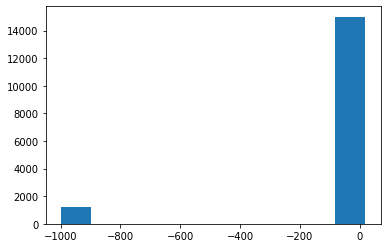

In [23]:
X_test_hierarchical_gr = X_test_hierarchical.join(df_feat[['Mean_1','Mean_2']],how='left')

X_test_hierarchical_gr = X_test_hierarchical_gr[(X_test_hierarchical_gr['Mean_1']>-900) & (X_test_hierarchical_gr['Mean_2']>-900)]
y_test_original_gr = y_test_original[X_test_hierarchical_gr.index]


X_test_hierarchical_gr = X_test_hierarchical_gr.drop(['Mean_1','Mean_2'],axis=1)
r_feat = [f for f in X_test_hierarchical_gr.columns if (f[-2:]=="_2") or (f=='g-r_max') or (f=='g-r_mean') or (f=='r-W2') or (f=='r-W3')]
g_feat = [f for f in X_test_hierarchical_gr.columns if (f[-2:]=="_1") or (f=='g-r_max') or (f=='g-r_mean') or (f=='g-W2') or (f=='g-W3')]


X_test_hierarchical_g = X_test_hierarchical_gr.copy()
print(X_test_hierarchical_g)
X_test_hierarchical_g[r_feat] = -999
print(X_test_hierarchical_g)

X_test_hierarchical_r = X_test_hierarchical_gr.copy()
X_test_hierarchical_r[g_feat] = -999

plt.hist(X_test_hierarchical_g['g-W2'].values)

In [24]:
Accuracy_first_layer = np.array(list_Accuracy_first_layer)
print(np.mean(Accuracy_first_layer), np.std(Accuracy_first_layer))

Balanced_Accuracy_first_layer = np.array(list_Balanced_Accuracy_first_layer)
print(np.mean(Balanced_Accuracy_first_layer), np.std(Balanced_Accuracy_first_layer))


Accuracy_last_layer = np.array(list_Accuracy_last_layer)
print("Accuracy ",np.mean(Accuracy_last_layer), np.std(Accuracy_last_layer))

Balanced_Accuracy_last_layer = np.array(list_Balanced_Accuracy_last_layer)
print("Balanced Accuracy ",np.mean(Balanced_Accuracy_last_layer), np.std(Balanced_Accuracy_last_layer))

precision_last_layer = np.array(list_precision_last_layer)
print("Precision", np.mean(precision_last_layer), np.std(precision_last_layer))

recall_last_layer = np.array(list_precision_last_layer)
print("Recall ",np.mean(precision_last_layer), np.std(precision_last_layer))



F1_last_layer = np.array(list_F1_Accuracy_last_layer)
print("F1 ", np.mean(F1_last_layer), np.std(F1_last_layer))


array_cnf_matrix = np.array(list_cnf_matrix)

array_cnf_matrix_hier = np.array(list_cnf_matrix_hier) 
#print(array_cnf_matrix_hier)

#print(np.mean(array_cnf_matrix_hier,axis=0))
#print(np.std(array_cnf_matrix_hier,axis=0))

0.9844332148516124 0.000573835247333161
0.9853143187220421 0.0019420041721929327
Accuracy  0.8333797267782964 0.0025809799109985697
Balanced Accuracy  0.7181752259222599 0.0116954841923182
Precision 0.9197358291363351 0.0014277287670832449
Recall  0.9197358291363351 0.0014277287670832449
F1  0.8664577124811361 0.002059088204021289


Normalized confusion matrix


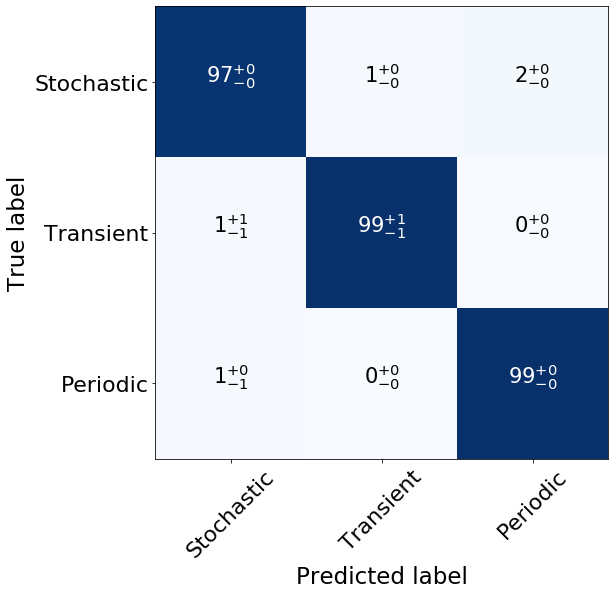

In [47]:
#hierarchical conf matrix
plot_confusion_matrix(np.median(array_cnf_matrix_hier,axis=0), np.percentile(array_cnf_matrix_hier,5,axis=0),np.percentile(array_cnf_matrix_hier,95,axis=0),cm_classes_hierachical,'../../paper_late_classifier/paper_plots/conf_matrix_hierarchical.pdf',font=21,fig_x = 10, fig_y = 8)
#plt.savefig('../../paper_late_classifier/paper_plots/conf_matrix_hierarchical.pdf')


Normalized confusion matrix


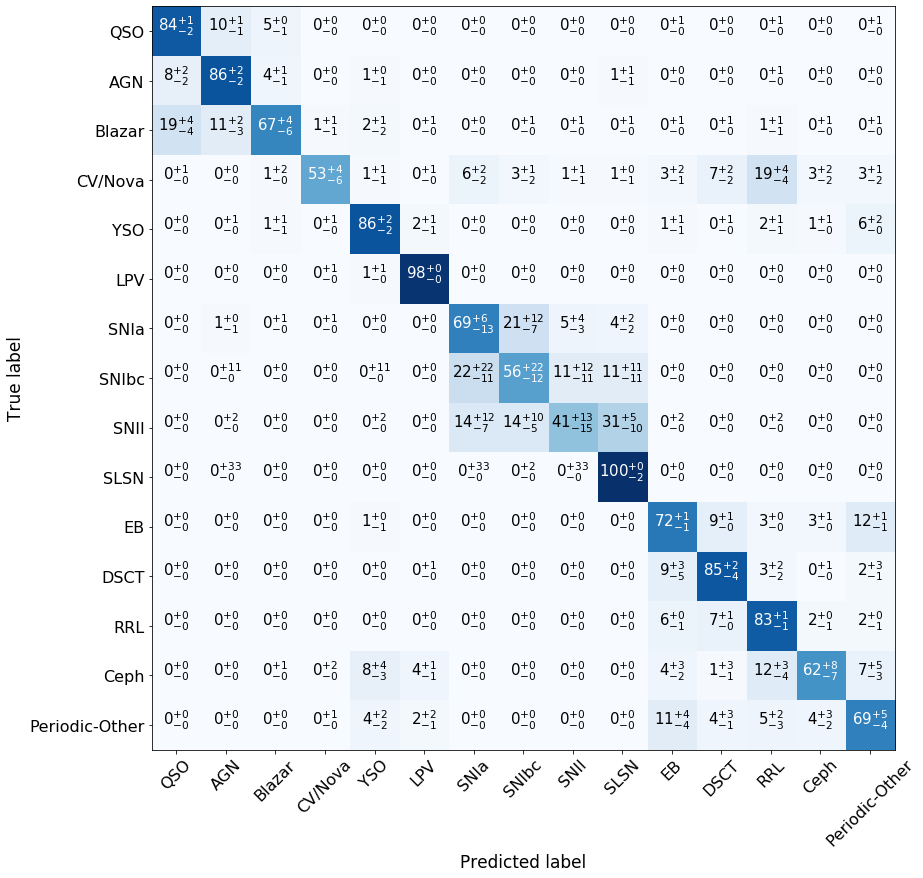

In [48]:
#multiclass conf matrix
#print(np.percentile(array_cnf_matrix,95,axis=0))
#print(np.percentile(array_cnf_matrix,50,axis=0))
plot_confusion_matrix(np.median(array_cnf_matrix,axis=0), np.percentile(array_cnf_matrix,5,axis=0),np.percentile(array_cnf_matrix,95,axis=0),label_order, '../../paper_late_classifier/paper_plots/conf_matrix_multiclass.pdf',font=15,fig_x = 20, fig_y = 12)
#plt.savefig('../../paper_late_classifier/paper_plots/conf_matrix_multiclass.pdf')


In [27]:
#function to create plots for each class

def plot_accuracy_1class(bins, gr_array, g_array, r_array, gr_nsamp, g_nsamp, r_nsamp,label,ax = None, xlabel = True, ylabel = True, xlabel_name ='average magnitude',xlimit=(13.5, 20.5),lowper=5,highper=95,nsam_perbin=10):
    ax = ax or plt.gca()
    
    
    mask = (gr_nsamp<nsam_perbin)
    gr_array[mask] = np.nan
    
    gr_median = np.nanmedian(gr_array,axis=0)
    gr_low = np.nanpercentile(gr_array,lowper,axis=0)
    gr_high = np.nanpercentile(gr_array,highper,axis=0)
    
    gr_n = np.where(gr_median>-1)
    
    gr_median = gr_median[gr_n[0]]
    gr_low = gr_low[gr_n[0]]
    gr_high = gr_high[gr_n[0]]
    gr_bins = bins[gr_n[0]]
    
    ax.plot(gr_bins,gr_median,'ko-',label=r'g+r')
    ax.fill_between(gr_bins, gr_low, gr_high,alpha=0.2,  facecolor='black')

    mask = (g_nsamp<nsam_perbin)
    g_array[mask] = np.nan
    
    g_median = np.nanmedian(g_array,axis=0)
    g_low = np.nanpercentile(g_array,lowper,axis=0)
    g_high = np.nanpercentile(g_array,highper,axis=0)
    
    g_n = np.where(g_median>-1)
    g_median = g_median[g_n[0]]
    g_low = g_low[g_n[0]]
    g_high = g_high[g_n[0]]
    g_bins = bins[g_n[0]]
    
    
    ax.plot(g_bins,g_median,'b>-',label=r'g')
    ax.fill_between(g_bins, g_low, g_high,alpha=0.2,  facecolor='blue')
    
    mask = (r_nsamp<nsam_perbin)
    r_array[mask] = np.nan
    
    r_median = np.nanmedian(r_array,axis=0)
    r_low = np.nanpercentile(r_array,lowper,axis=0)
    r_high = np.nanpercentile(r_array,highper,axis=0)
    
    r_n = np.where(r_median>-1)
    
    r_median = r_median[r_n[0]]
    r_low = r_low[r_n[0]]
    r_high = r_high[r_n[0]]
    r_bins = bins[r_n[0]]
    
    ax.plot(r_bins,r_median,'rs-',label=r'r')
    ax.fill_between(r_bins, r_low, r_high,alpha=0.2,  facecolor='red')
    
    ax.set_title(label)
    ax.set_ylim(0,1.1)
    ax.set_xlim(xlimit)
    plt.legend(loc= 'lower right',fontsize=15)
    if xlabel: ax.set_xlabel(xlabel_name,fontsize=12)
    if ylabel: ax.set_ylabel('Recall',fontsize=12)
    
    

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


(20, 18)
(18,)


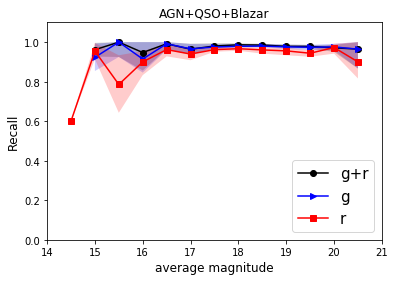

In [28]:
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_AQB, array_acc_mag_gband_AQB, array_acc_mag_rband_AQB, array_nsamp_mag_grband_AQB, array_nsamp_mag_gband_AQB, array_nsamp_mag_rband_AQB,'AGN+QSO+Blazar',xlimit=(14,21))
plt.savefig('../../paper_late_classifier/paper_plots/recall_agn_qso_blazar_for_mag.pdf',bbox_inches='tight')
print((array_acc_mag_grband_AQB).shape)
print(bins_mag_r.shape)

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


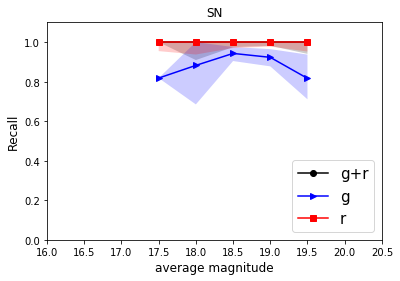

In [29]:
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_transients, array_acc_mag_gband_transients, array_acc_mag_rband_transients, array_nsamp_mag_grband_transients, array_nsamp_mag_gband_transients, array_nsamp_mag_rband_transients,'SN',xlimit=(16,20.5))



/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


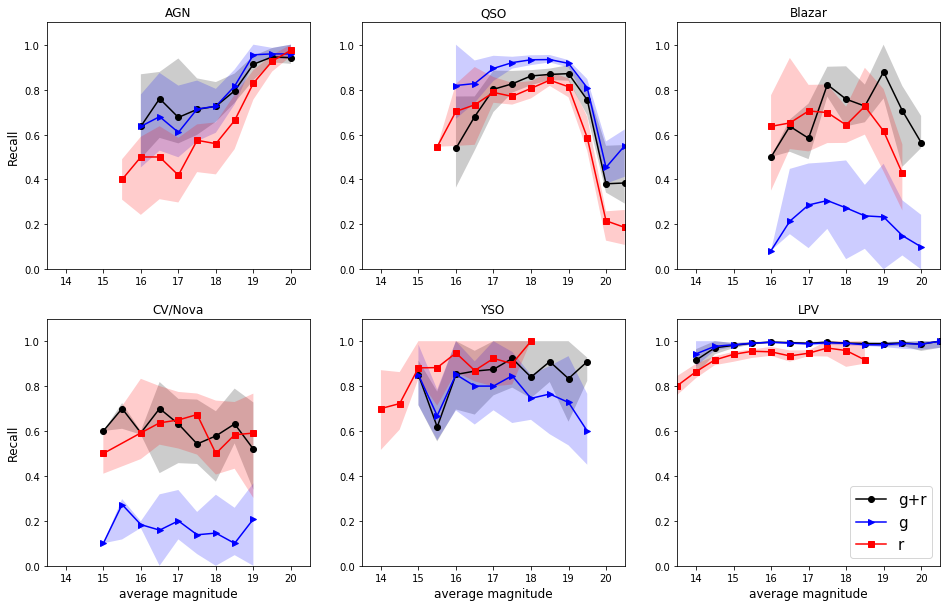

In [30]:
fig, axarr = plt.subplots(2, 3, figsize=(16,10))
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_AGN, array_acc_mag_gband_AGN, array_acc_mag_rband_AGN, array_nsamp_mag_grband_AGN, array_nsamp_mag_gband_AGN, array_nsamp_mag_rband_AGN,'AGN',ax=axarr[0,0],xlabel=False)
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_QSO, array_acc_mag_gband_QSO, array_acc_mag_rband_QSO, array_nsamp_mag_grband_QSO, array_nsamp_mag_gband_QSO, array_nsamp_mag_rband_QSO,'QSO',ax=axarr[0,1],xlabel=False, ylabel=False)
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_Blazar, array_acc_mag_gband_Blazar, array_acc_mag_rband_Blazar, array_nsamp_mag_grband_Blazar, array_nsamp_mag_gband_Blazar, array_nsamp_mag_rband_Blazar,'Blazar',ax=axarr[0,2],xlabel=False, ylabel=False)
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_CV, array_acc_mag_gband_CV, array_acc_mag_rband_CV, array_nsamp_mag_grband_CV, array_nsamp_mag_gband_CV, array_nsamp_mag_rband_CV,'CV/Nova',ax=axarr[1,0])
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_YSO, array_acc_mag_gband_YSO, array_acc_mag_rband_YSO, array_nsamp_mag_grband_YSO, array_nsamp_mag_gband_YSO, array_nsamp_mag_rband_YSO,'YSO',ax=axarr[1,1],ylabel=False)
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_LPV, array_acc_mag_gband_LPV, array_acc_mag_rband_LPV, array_nsamp_mag_grband_LPV, array_nsamp_mag_gband_LPV, array_nsamp_mag_rband_LPV,'LPV',ax=axarr[1,2],ylabel=False)


plt.savefig('../../paper_late_classifier/paper_plots/recall_stochastics_for_mag.pdf',bbox_inches='tight')


            




/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


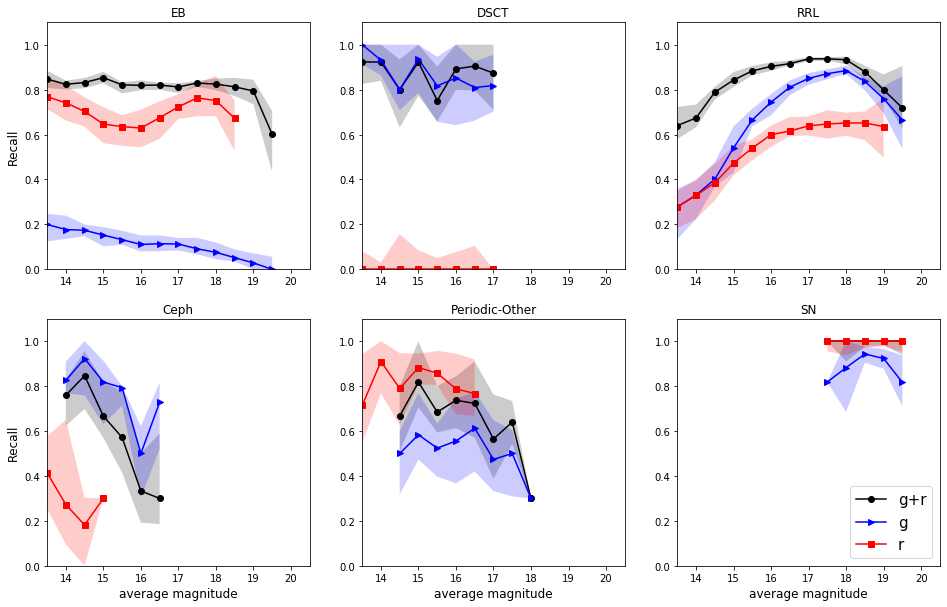

In [31]:
#print(bins_mag_r)
#print(array_acc_mag_rband_Ceph)
#print(array_nsamp_mag_rband_Ceph)

fig, axarr = plt.subplots(2, 3, figsize=(16,10))
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_EB, array_acc_mag_gband_EB, array_acc_mag_rband_EB, array_nsamp_mag_grband_EB, array_nsamp_mag_gband_EB, array_nsamp_mag_rband_EB,'EB',ax=axarr[0,0],xlabel=False)
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_DSCT, array_acc_mag_gband_DSCT, array_acc_mag_rband_DSCT, array_nsamp_mag_grband_DSCT, array_nsamp_mag_gband_DSCT, array_nsamp_mag_rband_DSCT,'DSCT',ax=axarr[0,1],xlabel=False, ylabel=False)
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_RRL, array_acc_mag_gband_RRL, array_acc_mag_rband_RRL, array_nsamp_mag_grband_RRL, array_nsamp_mag_gband_RRL, array_nsamp_mag_rband_RRL,'RRL',ax=axarr[0,2],xlabel=False, ylabel=False)
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_Ceph, array_acc_mag_gband_Ceph, array_acc_mag_rband_Ceph, array_nsamp_mag_grband_Ceph, array_nsamp_mag_gband_Ceph, array_nsamp_mag_rband_Ceph,'Ceph',ax=axarr[1,0])
#plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_RSCVn, array_acc_mag_gband_RSCVn, array_acc_mag_rband_RSCVn, array_nsamp_mag_grband_RSCVn, array_nsamp_mag_gband_RSCVn, array_nsamp_mag_rband_RSCVn,'RSCVn',ax=axarr[1,1])
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_Other, array_acc_mag_gband_Other, array_acc_mag_rband_Other, array_nsamp_mag_grband_Other, array_nsamp_mag_gband_Other, array_nsamp_mag_rband_Other,'Periodic-Other',ax=axarr[1,1],ylabel=False)
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_transients, array_acc_mag_gband_transients, array_acc_mag_rband_transients, array_nsamp_mag_grband_transients, array_nsamp_mag_gband_transients, array_nsamp_mag_rband_transients,'SN',ax=axarr[1,2],ylabel=False)


plt.savefig('../../paper_late_classifier/paper_plots/recall_periodic_transients_for_mag.pdf',bbox_inches='tight')



/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.

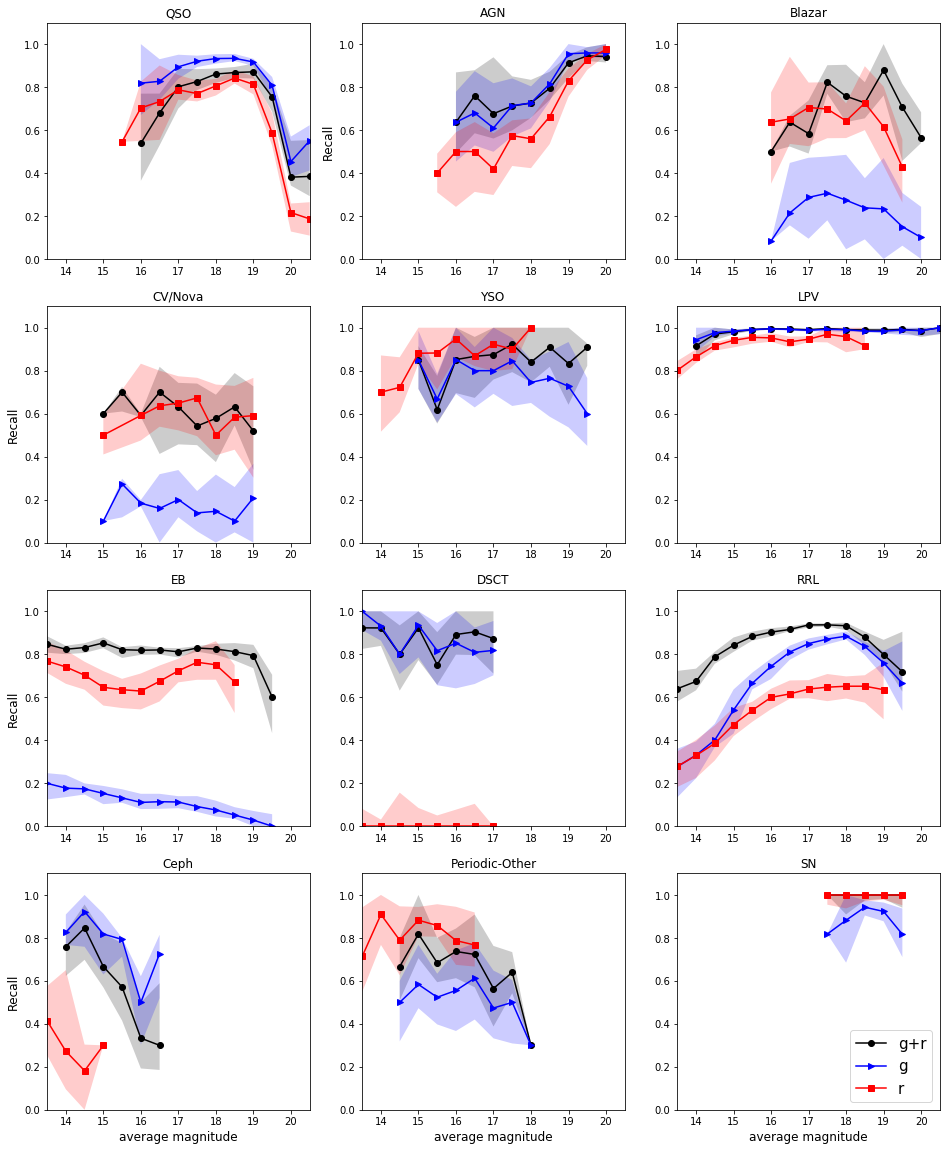

In [32]:
fig, axarr = plt.subplots(4, 3, figsize=(16,20))

plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_QSO, array_acc_mag_gband_QSO, array_acc_mag_rband_QSO, array_nsamp_mag_grband_QSO, array_nsamp_mag_gband_QSO, array_nsamp_mag_rband_QSO,'QSO',ax=axarr[0,0],xlabel=False, ylabel=False)
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_AGN, array_acc_mag_gband_AGN, array_acc_mag_rband_AGN, array_nsamp_mag_grband_AGN, array_nsamp_mag_gband_AGN, array_nsamp_mag_rband_AGN,'AGN',ax=axarr[0,1],xlabel=False)
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_Blazar, array_acc_mag_gband_Blazar, array_acc_mag_rband_Blazar, array_nsamp_mag_grband_Blazar, array_nsamp_mag_gband_Blazar, array_nsamp_mag_rband_Blazar,'Blazar',ax=axarr[0,2],xlabel=False, ylabel=False)
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_CV, array_acc_mag_gband_CV, array_acc_mag_rband_CV, array_nsamp_mag_grband_CV, array_nsamp_mag_gband_CV, array_nsamp_mag_rband_CV,'CV/Nova',ax=axarr[1,0],xlabel=False)
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_YSO, array_acc_mag_gband_YSO, array_acc_mag_rband_YSO, array_nsamp_mag_grband_YSO, array_nsamp_mag_gband_YSO, array_nsamp_mag_rband_YSO,'YSO',ax=axarr[1,1],ylabel=False,xlabel=False)
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_LPV, array_acc_mag_gband_LPV, array_acc_mag_rband_LPV, array_nsamp_mag_grband_LPV, array_nsamp_mag_gband_LPV, array_nsamp_mag_rband_LPV,'LPV',ax=axarr[1,2],ylabel=False,xlabel=False)



plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_EB, array_acc_mag_gband_EB, array_acc_mag_rband_EB, array_nsamp_mag_grband_EB, array_nsamp_mag_gband_EB, array_nsamp_mag_rband_EB,'EB',ax=axarr[2,0],xlabel=False)
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_DSCT, array_acc_mag_gband_DSCT, array_acc_mag_rband_DSCT, array_nsamp_mag_grband_DSCT, array_nsamp_mag_gband_DSCT, array_nsamp_mag_rband_DSCT,'DSCT',ax=axarr[2,1],xlabel=False, ylabel=False)
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_RRL, array_acc_mag_gband_RRL, array_acc_mag_rband_RRL, array_nsamp_mag_grband_RRL, array_nsamp_mag_gband_RRL, array_nsamp_mag_rband_RRL,'RRL',ax=axarr[2,2],xlabel=False, ylabel=False)
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_Ceph, array_acc_mag_gband_Ceph, array_acc_mag_rband_Ceph, array_nsamp_mag_grband_Ceph, array_nsamp_mag_gband_Ceph, array_nsamp_mag_rband_Ceph,'Ceph',ax=axarr[3,0])
#plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_RSCVn, array_acc_mag_gband_RSCVn, array_acc_mag_rband_RSCVn, array_nsamp_mag_grband_RSCVn, array_nsamp_mag_gband_RSCVn, array_nsamp_mag_rband_RSCVn,'RSCVn',ax=axarr[1,1])
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_Other, array_acc_mag_gband_Other, array_acc_mag_rband_Other, array_nsamp_mag_grband_Other, array_nsamp_mag_gband_Other, array_nsamp_mag_rband_Other,'Periodic-Other',ax=axarr[3,1],ylabel=False)
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_transients, array_acc_mag_gband_transients, array_acc_mag_rband_transients, array_nsamp_mag_grband_transients, array_nsamp_mag_gband_transients, array_nsamp_mag_rband_transients,'SN',ax=axarr[3,2],ylabel=False)

plt.savefig('../../paper_late_classifier/paper_plots/recall_all_for_mag.pdf',bbox_inches='tight')



In [33]:
def plot_accuracy_1class_nsamps(bins_gr, bins_g, bins_r, gr_array, g_array, r_array, gr_nsamp, g_nsamp, r_nsamp,label,ax = None, xlabel = True, ylabel = True, xlabel_name =r'$\mathrm{log(\# \mathrm{detections})}$',xlimit=(5,150),lowper=5,highper=95,nsam_perbin=10):
    
    ax = ax or plt.gca()
    #print(bins)
    #print(gr_array)
    
    mask = (gr_nsamp<nsam_perbin)
    gr_array[mask] = np.nan
    
    gr_median = np.nanmedian(gr_array,axis=0)
    gr_low = np.nanpercentile(gr_array,lowper,axis=0)
    gr_high = np.nanpercentile(gr_array,highper,axis=0)
    
    gr_n = np.where(gr_median>-1)
    
    gr_median = gr_median[gr_n[0]]
    gr_low = gr_low[gr_n[0]]
    gr_high = gr_high[gr_n[0]]
    gr_bins = bins_gr[gr_n[0]]
    
    ax.plot(gr_bins,gr_median,'ko-',label=r'g+r')
    ax.fill_between(gr_bins, gr_low, gr_high,alpha=0.2,  facecolor='black')

    mask = (g_nsamp<nsam_perbin)
    g_array[mask] = np.nan
    
    g_median = np.nanmedian(g_array,axis=0)
    g_low = np.nanpercentile(g_array,lowper,axis=0)
    g_high = np.nanpercentile(g_array,highper,axis=0)
    
    g_n = np.where(g_median>-1)
    g_median = g_median[g_n[0]]
    g_low = g_low[g_n[0]]
    g_high = g_high[g_n[0]]
    g_bins = bins_g[g_n[0]]
    
    
    ax.plot(g_bins,g_median,'b>-',label=r'g')
    ax.fill_between(g_bins, g_low, g_high,alpha=0.2,  facecolor='blue')
    
    mask = (r_nsamp<nsam_perbin)
    r_array[mask] = np.nan
    
    r_median = np.nanmedian(r_array,axis=0)
    r_low = np.nanpercentile(r_array,lowper,axis=0)
    r_high = np.nanpercentile(r_array,highper,axis=0)
    
    r_n = np.where(r_median>-1)
    
    r_median = r_median[r_n[0]]
    r_low = r_low[r_n[0]]
    r_high = r_high[r_n[0]]
    r_bins = bins_r[r_n[0]]
    
    ax.plot(r_bins,r_median,'rs-',label=r'r')
    ax.fill_between(r_bins, r_low, r_high,alpha=0.2,  facecolor='red')
    
    ax.set_title(label)
    ax.set_ylim(0,1.1)
    ax.set_xlim(xlimit)
    ax.set_xscale('log')
    plt.legend(loc='lower right', fontsize=15)
    if xlabel: ax.set_xlabel(xlabel_name,fontsize=12)
    if ylabel: ax.set_ylabel('Recall',fontsize=12)
    
    

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[  7.11513962   9.75993097  13.3878262   18.364258    25.19049521
  34.55413493  47.3983632   65.01696073  89.18462363 122.33572598
 167.80953085 230.18654951 315.74992974 433.11834833]
[0.62       0.68518519 0.72440945 0.61320755 0.58695652 0.76923077
 0.63736264 0.68103448 0.66666667 0.68627451 0.6        0.688
 0.69298246 0.74358974 0.65789474 0.66666667 0.70247934 0.7037037
 0.75510204 0.72072072]
[100 108 127 106  92 104  91 116  93 102 105 125 114 117 114 111 121 108
  98 111]


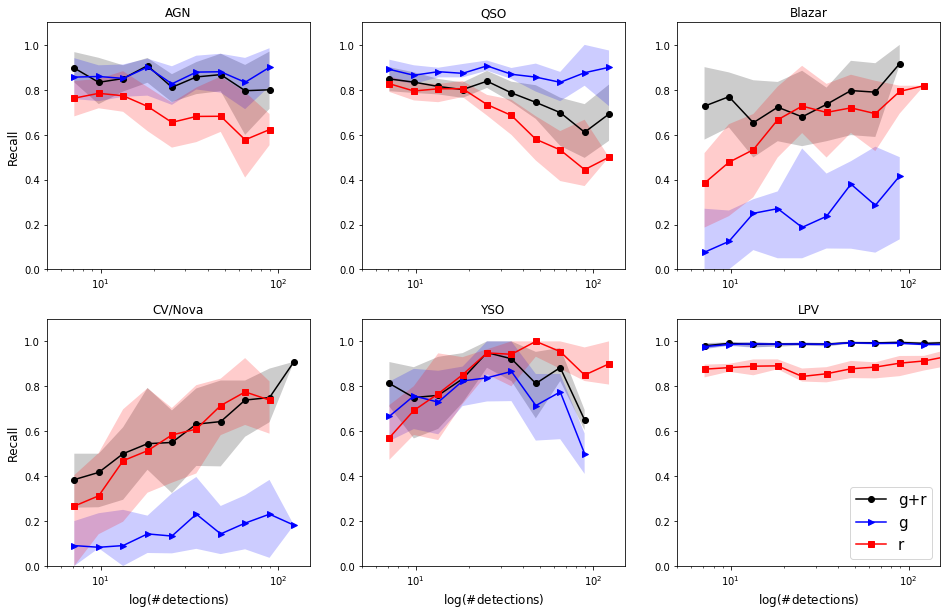

In [34]:
print(bins_nsamp_r)
print(array_acc_nsamp_rband_QSO[:,5])
print(array_nsamp_nsamp_rband_QSO[:,5])

fig2, axarr2 = plt.subplots(2, 3, figsize=(16,10))
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_AGN, array_acc_nsamp_gband_AGN, array_acc_nsamp_rband_AGN, array_nsamp_nsamp_grband_AGN, array_nsamp_nsamp_gband_AGN, array_nsamp_nsamp_rband_AGN,'AGN',ax=axarr2[0,0],xlabel=False)
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_QSO, array_acc_nsamp_gband_QSO, array_acc_nsamp_rband_QSO, array_nsamp_nsamp_grband_QSO, array_nsamp_nsamp_gband_QSO, array_nsamp_nsamp_rband_QSO,'QSO',ax=axarr2[0,1],xlabel=False, ylabel=False)
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_Blazar, array_acc_nsamp_gband_Blazar, array_acc_nsamp_rband_Blazar, array_nsamp_nsamp_grband_Blazar, array_nsamp_nsamp_gband_Blazar, array_nsamp_nsamp_rband_Blazar,'Blazar',ax=axarr2[0,2],xlabel=False, ylabel=False)
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_CV, array_acc_nsamp_gband_CV, array_acc_nsamp_rband_CV, array_nsamp_nsamp_grband_CV, array_nsamp_nsamp_gband_CV, array_nsamp_nsamp_rband_CV,'CV/Nova',ax=axarr2[1,0])
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_YSO, array_acc_nsamp_gband_YSO, array_acc_nsamp_rband_YSO, array_nsamp_nsamp_grband_YSO, array_nsamp_nsamp_gband_YSO, array_nsamp_nsamp_rband_YSO,'YSO',ax=axarr2[1,1],ylabel=False)
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_LPV, array_acc_nsamp_gband_LPV, array_acc_nsamp_rband_LPV, array_nsamp_nsamp_grband_LPV, array_nsamp_nsamp_gband_LPV, array_nsamp_nsamp_rband_LPV,'LPV',ax=axarr2[1,2],ylabel=False)

plt.savefig('../../paper_late_classifier/paper_plots/recall_stochastic_for_ndet.pdf',bbox_inches='tight')

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


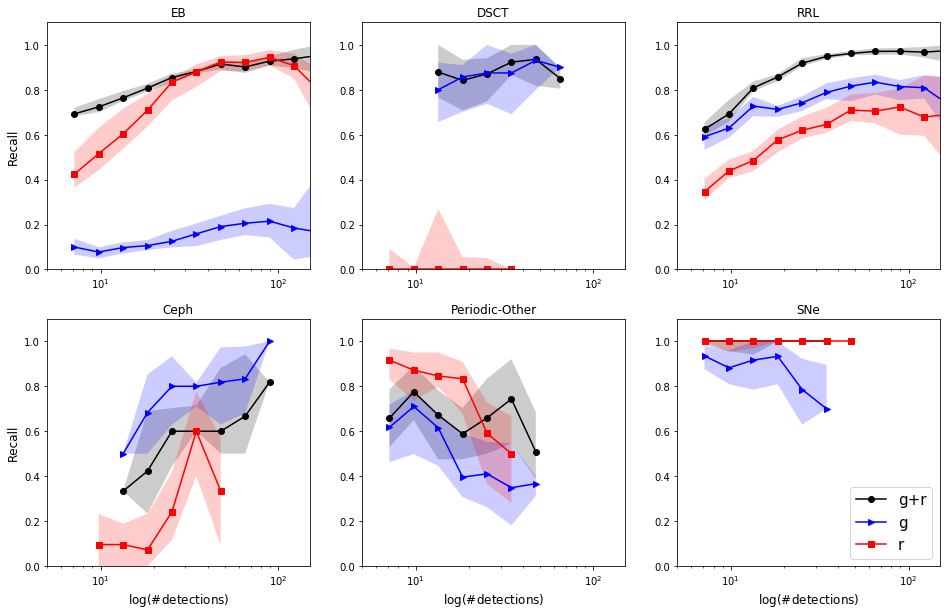

In [35]:
#print(bins_nsamp_r)
#print(array_acc_nsamp_gband_Other)
#print(array_nsamp_nsamp_gband_Other)

fig2, axarr2 = plt.subplots(2, 3, figsize=(16,10))
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_EB, array_acc_nsamp_gband_EB, array_acc_nsamp_rband_EB, array_nsamp_nsamp_grband_EB, array_nsamp_nsamp_gband_EB, array_nsamp_nsamp_rband_EB,'EB',ax=axarr2[0,0],xlabel=False)
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_DSCT, array_acc_nsamp_gband_DSCT, array_acc_nsamp_rband_DSCT, array_nsamp_nsamp_grband_DSCT, array_nsamp_nsamp_gband_DSCT, array_nsamp_nsamp_rband_DSCT,'DSCT',ax=axarr2[0,1],xlabel=False, ylabel=False)
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_RRL, array_acc_nsamp_gband_RRL, array_acc_nsamp_rband_RRL, array_nsamp_nsamp_grband_RRL, array_nsamp_nsamp_gband_RRL, array_nsamp_nsamp_rband_RRL,'RRL',ax=axarr2[0,2],xlabel=False, ylabel=False)
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_Ceph, array_acc_nsamp_gband_Ceph, array_acc_nsamp_rband_Ceph, array_nsamp_nsamp_grband_Ceph, array_nsamp_nsamp_gband_Ceph, array_nsamp_nsamp_rband_Ceph,'Ceph',ax=axarr2[1,0])
#plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_RSCVn, array_acc_nsamp_gband_RSCVn, array_acc_nsamp_rband_RSCVn, array_nsamp_nsamp_grband_RSCVn, array_nsamp_nsamp_gband_RSCVn, array_nsamp_nsamp_rband_RSCVn,'RSCVn',ax=axarr2[1,1],ylabel=False)
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_Other, array_acc_nsamp_gband_Other, array_acc_nsamp_rband_Other, array_nsamp_nsamp_grband_Other, array_nsamp_nsamp_gband_Other, array_nsamp_nsamp_rband_Other,'Periodic-Other',ax=axarr2[1,1],ylabel=False)
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_transients, array_acc_nsamp_gband_transients, array_acc_nsamp_rband_transients, array_nsamp_nsamp_grband_transients, array_nsamp_nsamp_gband_transients, array_nsamp_nsamp_rband_transients,'SNe',ax=axarr2[1,2],ylabel=False)



plt.savefig('../../paper_late_classifier/paper_plots/recall_periodic_transients_for_ndet.pdf',bbox_inches='tight')

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.

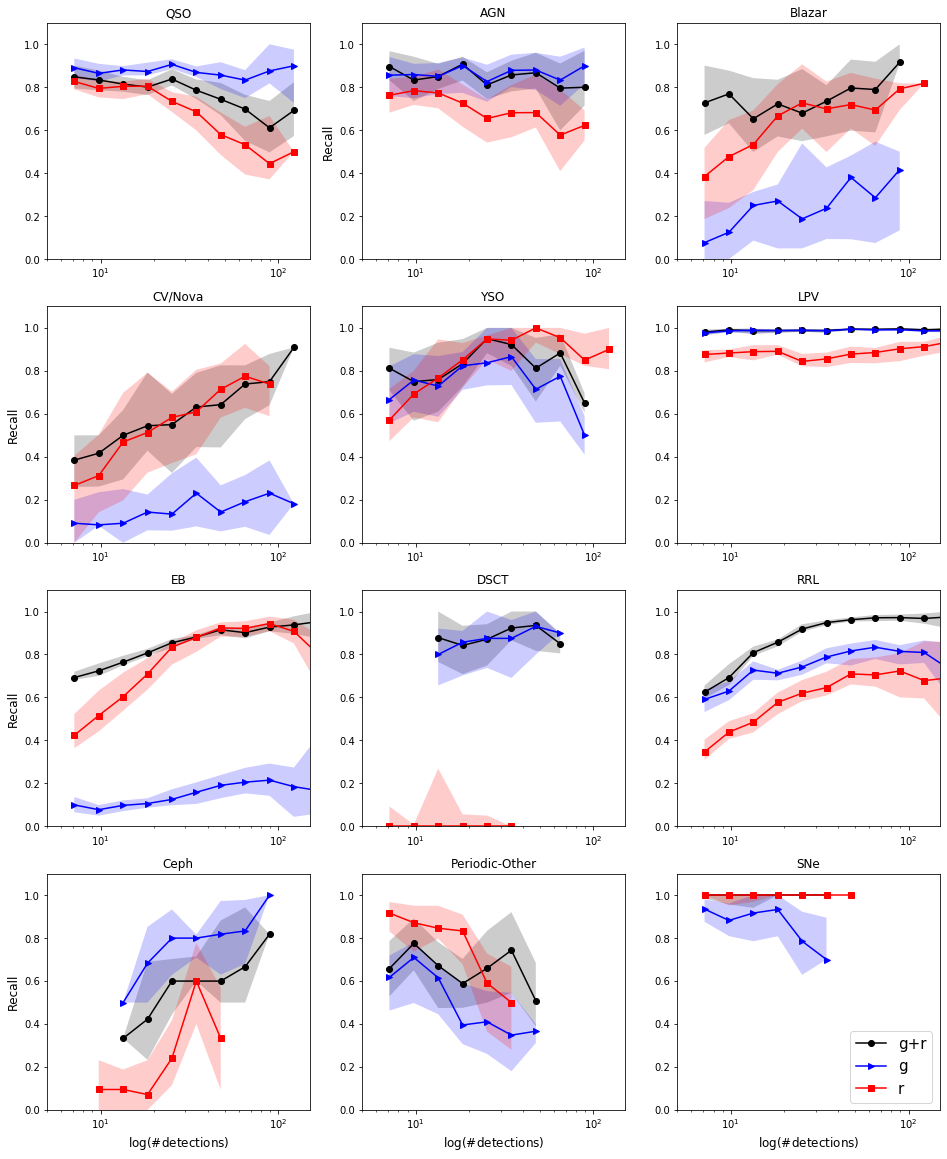

In [36]:
fig2, axarr2 = plt.subplots(4, 3, figsize=(16,20))
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_QSO, array_acc_nsamp_gband_QSO, array_acc_nsamp_rband_QSO, array_nsamp_nsamp_grband_QSO, array_nsamp_nsamp_gband_QSO, array_nsamp_nsamp_rband_QSO,'QSO',ax=axarr2[0,0],xlabel=False, ylabel=False)
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_AGN, array_acc_nsamp_gband_AGN, array_acc_nsamp_rband_AGN, array_nsamp_nsamp_grband_AGN, array_nsamp_nsamp_gband_AGN, array_nsamp_nsamp_rband_AGN,'AGN',ax=axarr2[0,1],xlabel=False)
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_Blazar, array_acc_nsamp_gband_Blazar, array_acc_nsamp_rband_Blazar, array_nsamp_nsamp_grband_Blazar, array_nsamp_nsamp_gband_Blazar, array_nsamp_nsamp_rband_Blazar,'Blazar',ax=axarr2[0,2],xlabel=False, ylabel=False)
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_CV, array_acc_nsamp_gband_CV, array_acc_nsamp_rband_CV, array_nsamp_nsamp_grband_CV, array_nsamp_nsamp_gband_CV, array_nsamp_nsamp_rband_CV,'CV/Nova',ax=axarr2[1,0],xlabel=False)
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_YSO, array_acc_nsamp_gband_YSO, array_acc_nsamp_rband_YSO, array_nsamp_nsamp_grband_YSO, array_nsamp_nsamp_gband_YSO, array_nsamp_nsamp_rband_YSO,'YSO',ax=axarr2[1,1],ylabel=False,xlabel=False)
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_LPV, array_acc_nsamp_gband_LPV, array_acc_nsamp_rband_LPV, array_nsamp_nsamp_grband_LPV, array_nsamp_nsamp_gband_LPV, array_nsamp_nsamp_rband_LPV,'LPV',ax=axarr2[1,2],ylabel=False,xlabel=False)

plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_EB, array_acc_nsamp_gband_EB, array_acc_nsamp_rband_EB, array_nsamp_nsamp_grband_EB, array_nsamp_nsamp_gband_EB, array_nsamp_nsamp_rband_EB,'EB',ax=axarr2[2,0],xlabel=False)
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_DSCT, array_acc_nsamp_gband_DSCT, array_acc_nsamp_rband_DSCT, array_nsamp_nsamp_grband_DSCT, array_nsamp_nsamp_gband_DSCT, array_nsamp_nsamp_rband_DSCT,'DSCT',ax=axarr2[2,1],xlabel=False, ylabel=False)
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_RRL, array_acc_nsamp_gband_RRL, array_acc_nsamp_rband_RRL, array_nsamp_nsamp_grband_RRL, array_nsamp_nsamp_gband_RRL, array_nsamp_nsamp_rband_RRL,'RRL',ax=axarr2[2,2],xlabel=False, ylabel=False)
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_Ceph, array_acc_nsamp_gband_Ceph, array_acc_nsamp_rband_Ceph, array_nsamp_nsamp_grband_Ceph, array_nsamp_nsamp_gband_Ceph, array_nsamp_nsamp_rband_Ceph,'Ceph',ax=axarr2[3,0])
#plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_RSCVn, array_acc_nsamp_gband_RSCVn, array_acc_nsamp_rband_RSCVn, array_nsamp_nsamp_grband_RSCVn, array_nsamp_nsamp_gband_RSCVn, array_nsamp_nsamp_rband_RSCVn,'RSCVn',ax=axarr2[1,1],ylabel=False)
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_Other, array_acc_nsamp_gband_Other, array_acc_nsamp_rband_Other, array_nsamp_nsamp_grband_Other, array_nsamp_nsamp_gband_Other, array_nsamp_nsamp_rband_Other,'Periodic-Other',ax=axarr2[3,1],ylabel=False)
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_transients, array_acc_nsamp_gband_transients, array_acc_nsamp_rband_transients, array_nsamp_nsamp_grband_transients, array_nsamp_nsamp_gband_transients, array_nsamp_nsamp_rband_transients,'SNe',ax=axarr2[3,2],ylabel=False)



plt.savefig('../../paper_late_classifier/paper_plots/recall_all_for_ndet.pdf',bbox_inches='tight')

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


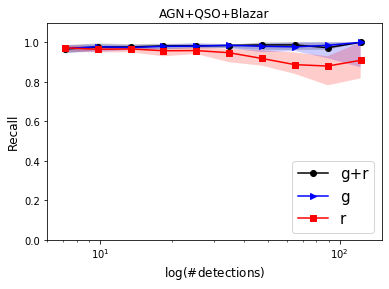

In [37]:
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_AQB, array_acc_nsamp_gband_AQB, array_acc_nsamp_rband_AQB, array_nsamp_nsamp_grband_AQB, array_nsamp_nsamp_gband_AQB, array_nsamp_nsamp_rband_AQB,'AGN+QSO+Blazar',xlimit=(6,150))

plt.savefig('../../paper_late_classifier/paper_plots/recall_agn_qso_blazar_for_ndet.pdf',bbox_inches='tight')

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


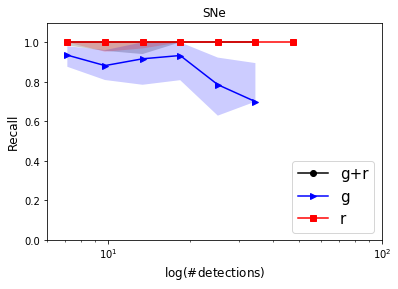

In [38]:
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_transients, array_acc_nsamp_gband_transients, array_acc_nsamp_rband_transients, array_nsamp_nsamp_grband_transients, array_nsamp_nsamp_gband_transients, array_nsamp_nsamp_rband_transients,'SNe',xlimit=(6,100))



In [39]:
df_for_figures = df.copy()
df_for_figures = df_for_figures.join(labels)
df_for_figures.head()

,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,class_original,class_hierachical
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18abcoxgp,1.777660,1.612033,1.0,1.0,6.0,8.0,0.607143,0.626866,0.018519,0.000000,...,0.886667,0.983125,-999.000,-999.000,-999.000000,-999.000000,-999.000000,-999.000000,CV/Nova,Stochastic
ZTF18aaavxnm,1.545494,1.355183,1.0,1.0,1.0,1.0,0.100000,0.163636,0.000000,0.018868,...,0.808571,1.000000,0.439,1.925,4.700925,2.775925,4.654902,2.729902,CV/Nova,Stochastic
ZTF18abmefme,1.741148,1.508885,1.0,1.0,1.0,1.0,0.529412,0.521739,0.000000,0.000000,...,0.912857,0.996042,0.168,2.829,4.799764,1.970764,4.865939,2.036939,CV/Nova,Stochastic
ZTF17aabumpu,1.689769,1.102787,1.0,1.0,1.0,1.0,0.176471,0.315789,0.000000,0.000000,...,0.846667,0.790198,0.026,0.576,2.432245,1.856245,2.667624,2.091624,CV/Nova,Stochastic
ZTF18aazmwvg,2.734478,2.477687,1.0,1.0,2.0,3.0,0.428571,0.442623,0.021277,0.000000,...,0.807857,0.980625,0.440,3.472,4.365933,0.893933,4.910711,1.438711,CV/Nova,Stochastic


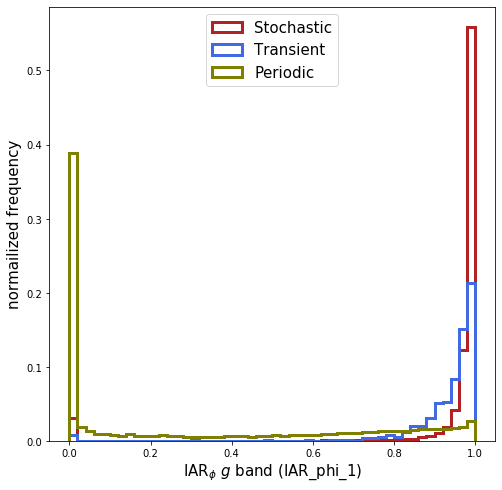

In [40]:
bins_hist = np.arange(0,1.01,0.02)

fi = plt.figure(figsize=(8,8))
weights = np.ones_like(df_for_figures['IAR_phi_1'][df_for_figures['class_hierachical']=='Stochastic'].values)/float(len(df_for_figures['IAR_phi_1'][df_for_figures['class_hierachical']=='Stochastic'].values))
binss,hist,p = plt.hist(df_for_figures['IAR_phi_1'][df_for_figures['class_hierachical']=='Stochastic'].values,weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label='Stochastic', alpha=1.0)

weights = np.ones_like(df_for_figures['IAR_phi_1'][df_for_figures['class_hierachical']=='Transient'].values)/float(len(df_for_figures['IAR_phi_1'][df_for_figures['class_hierachical']=='Transient'].values))
binss,hist,p = plt.hist(df_for_figures['IAR_phi_1'][df_for_figures['class_hierachical']=='Transient'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='Transient', alpha=1.0)

weights = np.ones_like(df_for_figures['IAR_phi_1'][df_for_figures['class_hierachical']=='Periodic'].values)/float(len(df_for_figures['IAR_phi_1'][df_for_figures['class_hierachical']=='Periodic'].values))  
binss,hist,p = plt.hist(df_for_figures['IAR_phi_1'][df_for_figures['class_hierachical']=='Periodic'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "blueviolet", ec="olive",label='Periodic', alpha=1.0)

    
plt.legend(loc='upper center',fontsize=15)
plt.xlabel(r'IAR$_{\phi}$ $g$ band (IAR_phi_1)',fontsize=15)
plt.ylabel(r'normailized frequency',fontsize=15)

plt.savefig('../../paper_late_classifier/paper_plots/IAR_phi_1_hierarchical.pdf',bbox_inches='tight')

[5.00000000e-08 1.34332033e-07 3.60901902e-07 9.69613724e-07
 2.60500365e-06 6.99870874e-06 1.88030155e-05 5.05169459e-05
 1.35720881e-04 3.64633237e-04 9.79638480e-04 2.63193657e-03
 7.07106781e-03 1.89974183e-02 5.10392364e-02 1.37124088e-01
 3.68403150e-01 9.89766882e-01 2.65914795e+00 7.14417500e+00
 1.91938310e+01 5.15669269e+01 1.38541802e+02 3.72212040e+02
 1.00000000e+03]


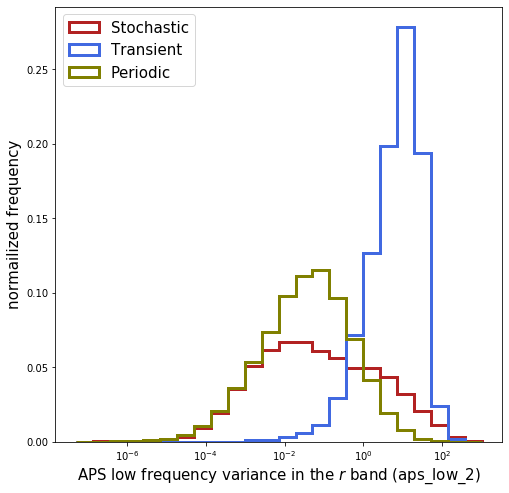

In [41]:
#bins_hist = np.arange(0,1.01,0.02)
bins_hist = np.logspace(np.log10(5e-8),np.log10(1000),25, base=10.0,endpoint=True)
print(bins_hist)
fi = plt.figure(figsize=(8,8))
weights = np.ones_like(df_for_figures['aps_low_2'][df_for_figures['class_hierachical']=='Stochastic'].values)/float(len(df_for_figures['aps_low_2'][df_for_figures['class_hierachical']=='Stochastic'].values))
plt.hist(df_for_figures['aps_low_2'][df_for_figures['class_hierachical']=='Stochastic'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label='Stochastic', alpha=1.0)
weights = np.ones_like(df_for_figures['aps_low_2'][df_for_figures['class_hierachical']=='Transient'].values)/float(len(df_for_figures['aps_low_2'][df_for_figures['class_hierachical']=='Transient'].values))
plt.hist(df_for_figures['aps_low_2'][df_for_figures['class_hierachical']=='Transient'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='Transient', alpha=1.0)
weights = np.ones_like(df_for_figures['aps_low_2'][df_for_figures['class_hierachical']=='Periodic'].values)/float(len(df_for_figures['aps_low_2'][df_for_figures['class_hierachical']=='Periodic'].values))
plt.hist(df_for_figures['aps_low_2'][df_for_figures['class_hierachical']=='Periodic'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "blueviolet", ec="olive",label='Periodic', alpha=1.0)
plt.legend(loc='upper left',fontsize=15)
plt.xlabel(r'APS low frequency variance in the $r$ band (aps_low_2)',fontsize=15)
plt.ylabel(r'normailized frequency',fontsize=15)
plt.xscale('log')
plt.savefig('../../paper_late_classifier/paper_plots/aps_low_2_hierarchical.pdf',bbox_inches='tight')

[5.00000000e-08 1.34332033e-07 3.60901902e-07 9.69613724e-07
 2.60500365e-06 6.99870874e-06 1.88030155e-05 5.05169459e-05
 1.35720881e-04 3.64633237e-04 9.79638480e-04 2.63193657e-03
 7.07106781e-03 1.89974183e-02 5.10392364e-02 1.37124088e-01
 3.68403150e-01 9.89766882e-01 2.65914795e+00 7.14417500e+00
 1.91938310e+01 5.15669269e+01 1.38541802e+02 3.72212040e+02
 1.00000000e+03]


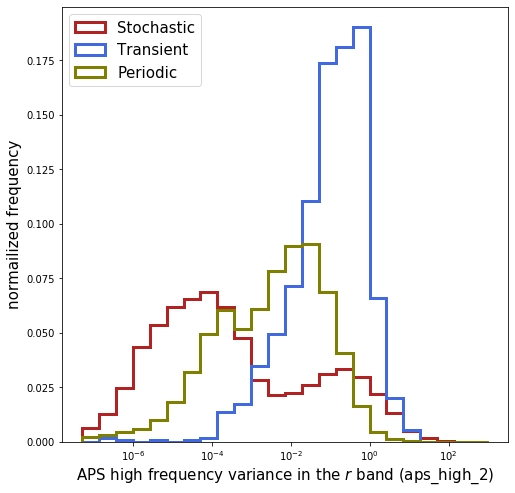

In [42]:
#bins_hist = np.arange(0,1.01,0.02)
bins_hist = np.logspace(np.log10(5e-8),np.log10(1000),25, base=10.0,endpoint=True)
print(bins_hist)
fi = plt.figure(figsize=(8,8))
weights = np.ones_like(df_for_figures['aps_high_2'][df_for_figures['class_hierachical']=='Stochastic'].values)/float(len(df_for_figures['aps_high_2'][df_for_figures['class_hierachical']=='Stochastic'].values))
plt.hist(df_for_figures['aps_high_2'][df_for_figures['class_hierachical']=='Stochastic'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label='Stochastic', alpha=1.0)
weights = np.ones_like(df_for_figures['aps_high_2'][df_for_figures['class_hierachical']=='Transient'].values)/float(len(df_for_figures['aps_high_2'][df_for_figures['class_hierachical']=='Transient'].values))
plt.hist(df_for_figures['aps_high_2'][df_for_figures['class_hierachical']=='Transient'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='Transient', alpha=1.0)
weights = np.ones_like(df_for_figures['aps_high_2'][df_for_figures['class_hierachical']=='Periodic'].values)/float(len(df_for_figures['aps_high_2'][df_for_figures['class_hierachical']=='Periodic'].values))
plt.hist(df_for_figures['aps_high_2'][df_for_figures['class_hierachical']=='Periodic'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "blueviolet", ec="olive",label='Periodic', alpha=1.0)
plt.legend(loc='upper left',fontsize=15)
plt.xlabel(r'APS high frequency variance in the $r$ band (aps_high_2)',fontsize=15)
plt.ylabel(r'normailized frequency',fontsize=15)
plt.xscale('log')
plt.savefig('../../paper_late_classifier/paper_plots/aps_high_2_hierarchical.pdf',bbox_inches='tight')

[5.00000000e-08 1.34332033e-07 3.60901902e-07 9.69613724e-07
 2.60500365e-06 6.99870874e-06 1.88030155e-05 5.05169459e-05
 1.35720881e-04 3.64633237e-04 9.79638480e-04 2.63193657e-03
 7.07106781e-03 1.89974183e-02 5.10392364e-02 1.37124088e-01
 3.68403150e-01 9.89766882e-01 2.65914795e+00 7.14417500e+00
 1.91938310e+01 5.15669269e+01 1.38541802e+02 3.72212040e+02
 1.00000000e+03]


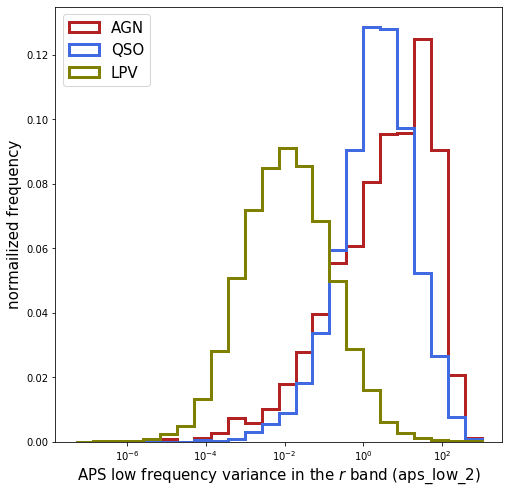

In [43]:
#bins_hist = np.arange(0,1.01,0.02)
bins_hist = np.logspace(np.log10(5e-8),np.log10(1000),25, base=10.0,endpoint=True)
print(bins_hist)
fi = plt.figure(figsize=(8,8))
weights = np.ones_like(df_for_figures['aps_low_2'][df_for_figures['class_original']=='AGN'].values)/float(len(df_for_figures['aps_low_2'][df_for_figures['class_original']=='AGN'].values))
plt.hist(df_for_figures['aps_low_2'][df_for_figures['class_original']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label='AGN', alpha=1.0)
weights = np.ones_like(df_for_figures['aps_low_2'][df_for_figures['class_original']=='QSO'].values)/float(len(df_for_figures['aps_low_2'][df_for_figures['class_original']=='QSO'].values))
plt.hist(df_for_figures['aps_low_2'][df_for_figures['class_original']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='QSO', alpha=1.0)
weights = np.ones_like(df_for_figures['aps_low_2'][df_for_figures['class_original']=='LPV'].values)/float(len(df_for_figures['aps_low_2'][df_for_figures['class_original']=='LPV'].values))
plt.hist(df_for_figures['aps_low_2'][df_for_figures['class_original']=='LPV'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "blueviolet", ec="olive",label='LPV', alpha=1.0)
plt.legend(loc='upper left',fontsize=15)
plt.xlabel(r'APS low frequency variance in the $r$ band (aps_low_2)',fontsize=15)
plt.ylabel(r'normailized frequency',fontsize=15)
plt.xscale('log')
plt.savefig('../../paper_late_classifier/paper_plots/aps_low_2_stochastics.pdf',bbox_inches='tight')

[5.00000000e-08 1.34332033e-07 3.60901902e-07 9.69613724e-07
 2.60500365e-06 6.99870874e-06 1.88030155e-05 5.05169459e-05
 1.35720881e-04 3.64633237e-04 9.79638480e-04 2.63193657e-03
 7.07106781e-03 1.89974183e-02 5.10392364e-02 1.37124088e-01
 3.68403150e-01 9.89766882e-01 2.65914795e+00 7.14417500e+00
 1.91938310e+01 5.15669269e+01 1.38541802e+02 3.72212040e+02
 1.00000000e+03]


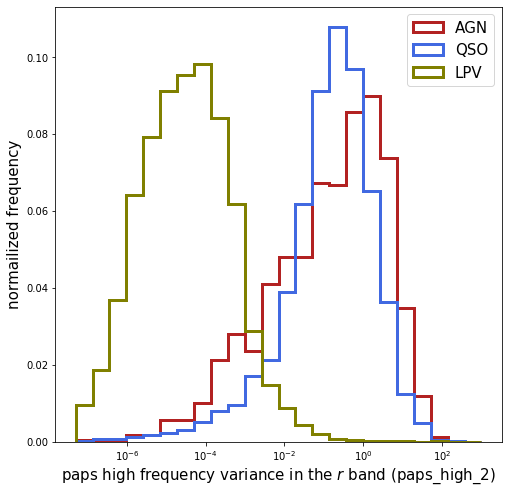

In [49]:
#bins_hist = np.arange(0,1.01,0.02)
bins_hist = np.logspace(np.log10(5e-8),np.log10(1000),25, base=10.0,endpoint=True)
print(bins_hist)
fi = plt.figure(figsize=(8,8))
weights = np.ones_like(df_for_figures['aps_high_2'][df_for_figures['class_original']=='AGN'].values)/float(len(df_for_figures['aps_high_2'][df_for_figures['class_original']=='AGN'].values))
plt.hist(df_for_figures['aps_high_2'][df_for_figures['class_original']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label='AGN', alpha=1.0)
weights = np.ones_like(df_for_figures['aps_high_2'][df_for_figures['class_original']=='QSO'].values)/float(len(df_for_figures['aps_high_2'][df_for_figures['class_original']=='QSO'].values))
plt.hist(df_for_figures['aps_high_2'][df_for_figures['class_original']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='QSO', alpha=1.0)
weights = np.ones_like(df_for_figures['aps_high_2'][df_for_figures['class_original']=='LPV'].values)/float(len(df_for_figures['aps_high_2'][df_for_figures['class_original']=='LPV'].values))
plt.hist(df_for_figures['aps_high_2'][df_for_figures['class_original']=='LPV'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "blueviolet", ec="olive",label='LPV', alpha=1.0)
plt.legend(loc='upper right',fontsize=15)
plt.xlabel(r'paps high frequency variance in the $r$ band (paps_high_2)',fontsize=15)
plt.ylabel(r'normailized frequency',fontsize=15)
plt.xscale('log')
plt.savefig('../../paper_late_classifier/paper_plots/paps_high_2_stochastics.pdf',bbox_inches='tight')

[ 2.          2.27586207  2.55172414  2.82758621  3.10344828  3.37931034
  3.65517241  3.93103448  4.20689655  4.48275862  4.75862069  5.03448276
  5.31034483  5.5862069   5.86206897  6.13793103  6.4137931   6.68965517
  6.96551724  7.24137931  7.51724138  7.79310345  8.06896552  8.34482759
  8.62068966  8.89655172  9.17241379  9.44827586  9.72413793 10.        ]


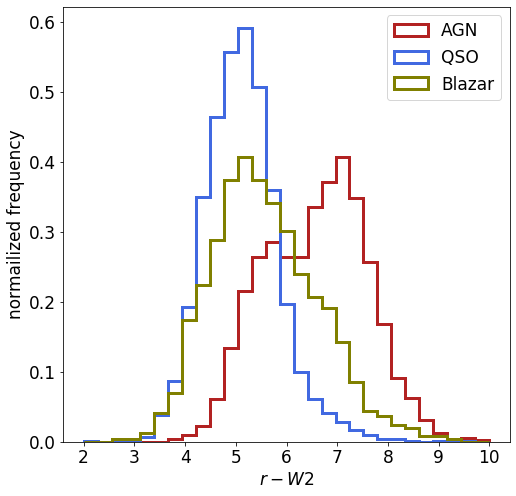

In [111]:
#bins_hist = np.arange(0,1.01,0.02)
feature='r-W2'
bins_hist = np.linspace(2,10,30)#np.logspace(np.log10(5e-8),np.log10(1000),25, base=10.0,endpoint=True)
print(bins_hist)
fi = plt.figure(figsize=(8,8))
plt.hist(df_for_figures[feature][df_for_figures['class_original']=='AGN'].values, cumulative=False, stacked=False, density=True, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label='AGN', alpha=1.0)
plt.hist(df_for_figures[feature][df_for_figures['class_original']=='QSO'].values, cumulative=False, stacked=False, density=True, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='QSO', alpha=1.0)
plt.hist(df_for_figures[feature][df_for_figures['class_original']=='Blazar'].values, cumulative=False, stacked=False, density=True, histtype='step', bins=bins_hist, lw=3, color = "blueviolet", ec="olive",label='Blazar', alpha=1.0)
plt.legend(loc='upper right',fontsize=17)
plt.xlabel(r'$r-W2$',fontsize=17)
plt.ylabel(r'normailized frequency',fontsize=17)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
#plt.xscale('log')
plt.savefig('../../paper_late_classifier/paper_plots/r_W2_agn_classes.pdf',bbox_inches='tight')

[5.00000000e-03 6.66760716e-03 8.89139705e-03 1.18568685e-02
 1.58113883e-02 2.10848252e-02 2.81170663e-02 3.74947105e-02
 5.00000000e-02 6.66760716e-02 8.89139705e-02 1.18568685e-01
 1.58113883e-01 2.10848252e-01 2.81170663e-01 3.74947105e-01
 5.00000000e-01 6.66760716e-01 8.89139705e-01 1.18568685e+00
 1.58113883e+00 2.10848252e+00 2.81170663e+00 3.74947105e+00
 5.00000000e+00]


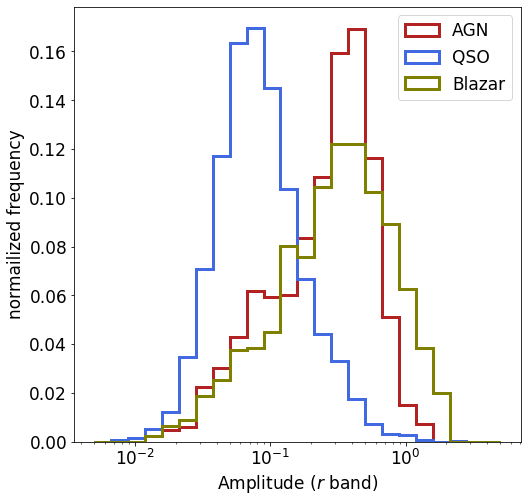

In [104]:
#bins_hist = np.arange(0,1.01,0.02)
feature='Amplitude_2'
bins_hist = np.logspace(np.log10(5e-3),np.log10(5),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
print(bins_hist)
fi = plt.figure(figsize=(8,8))
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values)/float(len(df_for_figures_aux['aps_high_2'][df_for_figures_aux['class_original']=='AGN'].values))
plt.hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label='AGN', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values)/float(len(df_for_figures_aux['aps_high_2'][df_for_figures_aux['class_original']=='QSO'].values))
plt.hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='QSO', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values)/float(len(df_for_figures_aux['aps_high_2'][df_for_figures_aux['class_original']=='Blazar'].values))
plt.hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "blueviolet", ec="olive",label='Blazar', alpha=1.0)
plt.legend(loc='upper right',fontsize=17)
plt.xlabel(r'Amplitude ($r$ band)',fontsize=17)
plt.ylabel(r'normailized frequency',fontsize=17)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)

plt.xscale('log')
plt.savefig('../../paper_late_classifier/paper_plots/amplitude_rband_agn_classes.pdf',bbox_inches='tight')

[2.00000000e-04 3.04984309e-04 4.65077144e-04 7.09206156e-04
 1.08148375e-03 1.64917787e-03 2.51486686e-03 3.83497466e-03
 5.84803548e-03 8.91779529e-03 1.35989382e-02 2.07373138e-02
 3.16227766e-02 4.82222533e-02 7.35351531e-02 1.12135339e-01
 1.70997595e-01 2.60757916e-01 3.97635364e-01 6.06362734e-01
 9.24655597e-01 1.41002724e+00 2.15018092e+00 3.27885721e+00
 5.00000000e+00]


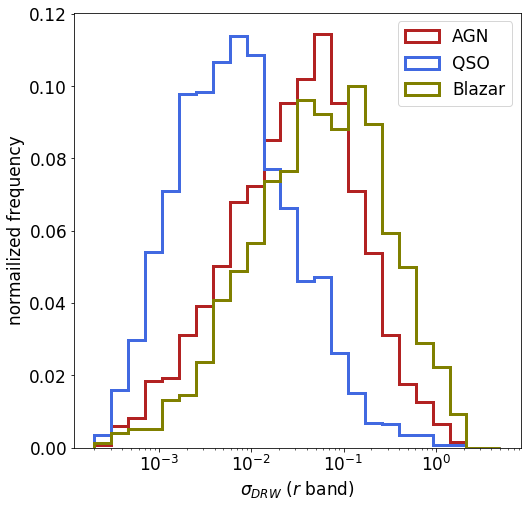

In [112]:
#bins_hist = np.arange(0,1.01,0.02)
feature='GP_DRW_sigma_2'
bins_hist = np.logspace(np.log10(2e-4),np.log10(5),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
print(bins_hist)
fi = plt.figure(figsize=(8,8))
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values)/float(len(df_for_figures_aux['aps_high_2'][df_for_figures_aux['class_original']=='AGN'].values))
plt.hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label='AGN', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values)/float(len(df_for_figures_aux['aps_high_2'][df_for_figures_aux['class_original']=='QSO'].values))
plt.hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='QSO', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values)/float(len(df_for_figures_aux['aps_high_2'][df_for_figures_aux['class_original']=='Blazar'].values))
plt.hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "blueviolet", ec="olive",label='Blazar', alpha=1.0)
plt.legend(loc='upper right',fontsize=17)
plt.xlabel(r'$\sigma_{DRW}$ ($r$ band)',fontsize=17)
plt.ylabel(r'normailized frequency',fontsize=17)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.xscale('log')
plt.savefig('../../paper_late_classifier/paper_plots/drw_sigma_rband_agn_classes.pdf',bbox_inches='tight')

[   5.            6.6059014     8.72758666   11.53071539   15.23415379
   20.12706357   26.59147948   35.13213831   46.41588834   61.32375635
   81.01973759  107.0416796   141.42135624  186.84310704  246.85342849
  326.13788179  430.88693801  569.27932543  752.12061862  993.68692955
 1312.83957589 1734.49775857 2291.58423445 3027.59590068 4000.        ]


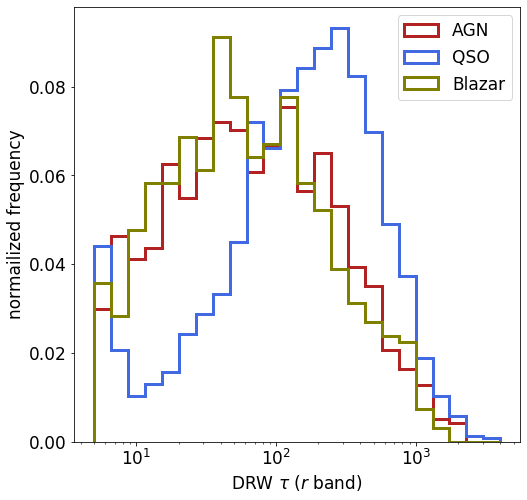

In [106]:
#bins_hist = np.arange(0,1.01,0.02)
feature='GP_DRW_tau_2'
bins_hist = np.logspace(np.log10(5),np.log10(4000),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
print(bins_hist)
fi = plt.figure(figsize=(8,8))
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values)/float(len(df_for_figures_aux['aps_high_2'][df_for_figures_aux['class_original']=='AGN'].values))
plt.hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label='AGN', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values)/float(len(df_for_figures_aux['aps_high_2'][df_for_figures_aux['class_original']=='QSO'].values))
plt.hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='QSO', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values)/float(len(df_for_figures_aux['aps_high_2'][df_for_figures_aux['class_original']=='Blazar'].values))
plt.hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "blueviolet", ec="olive",label='Blazar', alpha=1.0)
plt.legend(loc='upper right',fontsize=17)
plt.xlabel(r'DRW $\tau$ ($r$ band)',fontsize=17)
plt.ylabel(r'normailized frequency',fontsize=17)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.xscale('log')
plt.savefig('../../paper_late_classifier/paper_plots/drw_tau_rband_agn_classes.pdf',bbox_inches='tight')